__Feature Importance__

# Table of Contents

# 1. Introduction

from Notebook Filtering.ipynb after statistical Analyis, we continue this notebook with 5 dataframes :
**original** dataframe as baseline for comparison. Contains 880 genera         
**uniques** unfiltered exclusive genera, contains 341 genera  
**uniques23** unfiltered exclusive genera plus common from categories 2 and 3, contains 773 genera      
**Influencers_OLS** filtered from original by threshold 0.2% abundance and frequency minimum of 3, selected genera using Ordinary Least Squares     
**OLS_all** selected data from the original underwent selection of significance by OLS.  
**uniques_OLS** selected from the original uniques Genera for each category were selected, posterior underwent selection of significance by OLS.   
**uniques_23_OLS** selected data from the original uniques Genera for each category, plus the common genera from category 2 and 3, posterior OLS.     
This notebook selects from original, uniques and uniques23 the 50 most influential features per pca analyis for the following df
**original_pca** from original after pca, made in this notebook and contains 51 genera
**uniques_pca** from uniques after pca, made in this notebook, contains 51 genera      
**uniques23_pca** from uniques23 after pca, contains 51 genera 
**Influencers_uniques** from the mix of Influencers_OLS and uniques_OLS, contains 27 genera
**Influencers_uniques_selected** top 20 genera from the mix of Influencers_OLS and uniques_OLS
**Merged_selected** 10 Top, coming from the combination of original_pca, uniques_pca, uniques23_pca, uniques23_OLS and OLS_all
**old_new_1 and 2** OLS_all old analysis that combined filtering by OLS and pca with the added column of frequency of occurency

Starting with 5 different df: OLS_all, Influencers_OLS, uniques_OLS, uniques_23_OLS, original apply the following pipelines
1. Apply Pipelines:
   * PCA visual scree plot and PCA scatterplot:
        These focus on the dimensionality reduction aspect and the structure of the data in the reduced space.  
   * PCA  Feature Influence , explained variance
     This focuses on how each feature contributes to the variance explained by the principal components.
   * Random Forest Regression- Feature importance
   * Random Forest Classification- Feature importance
2. Visually comparing Feature Importances and Influences:
   * Extract feature importances from the Random Forest models. This focuses on the predictive power of each feature in the context of a Random Forest model
   * Extract feature influences from the PCA pipeline. 
3. Combine and Select Most Influential Features:
   * Combine the results from different pipelines according to importance, influence and frequency into a DataFrame.
   * Select the top influential features : This is the case with Influencers_uniques and Merged_selected
4. Replace IDs/GIDs with Biological Names:
   * Map the feature IDs to their corresponding biological names.
   * Analyze the biological significance of the selected features. For each dataframe and see if they make sense.

__Logistic Regression with L1 Regularization:__ This can help in feature selection by shrinking the coefficients of less important features to zero.
Random Forest or Gradient Boosting: These tree-based models can provide a feature importance score for each GID.
__Influence:__ Since the 'Influence' feature accounts for both abundance and frequency, it might be worthwhile to also consider this feature in the analysis. We can repeat the above steps using 'Influence' as the dependent variable instead of 'Abundance' to see if it provides any additional insights. Additionally at the end we have a list of most relevant Genera to continue to book 4.

# 2. Data Loading and Preproccessing

In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import braycurtis
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error
from IPython.display import display, HTML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight  
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score
from umap import UMAP
import umap.umap_ as umap
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest

In [196]:
pd.options.display.float_format = '{:.4f}'.format
#Reading the data
original  = pd.read_excel('data/original.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques   = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques23 = pd.read_excel('data/uniques_unfiltered.xlsx', sheet_name='uniques23', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_OLS = pd.read_excel('data/uniques_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques23_OLS = pd.read_excel('data/uniques23_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [197]:
def clean_dataframe(df):
    return (df.drop(columns='Unnamed: 0', axis=1)
        .astype({'Sites': str, 'Category': int})
        .set_index("Sites"))

original = clean_dataframe(original)
uniques = clean_dataframe(uniques)
uniques23 = clean_dataframe(uniques23)
OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
uniques_OLS= clean_dataframe(uniques_OLS)
uniques23_OLS= clean_dataframe(uniques23_OLS)

# 3. Pipelines PCA
## 3.1. PCA explained_variance_ratio -Screeplot and PCA plot- Pipeline

In [198]:
def prepare_data(df, category_column, index_column=None):
    df_prepared = df.copy()
    if index_column:
        df_prepared = df_prepared.set_index(index_column)
    category = df_prepared[category_column]
    df_prepared = df_prepared.drop(columns=[category_column], axis=1)
    return df_prepared, category

def standardize_data(df):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df)
    return pd.DataFrame(X_scaled, columns=df.columns)

def perform_pca(X_scaled, n_components=None):
    if n_components is None:
        pca = PCA()
    else:
        pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio

def plot_scree(pca, title):
    explained_var = pca.explained_variance_ratio_
    plt.figure(figsize=(7, 5))
    plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.title(title) # "Explained Variance Ratio by Principal Components"
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def plot_pca_2d(X_pca, category, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Category'] = category.values
    colors = ['green', 'orange', 'red']
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", hue="Category", data=pca_df, palette=colors)
    plt.title(title)# "Data Points in Reduced Dimensional Space (PCA)"
    plt.show()

def pca_pipeline(df, category_column, index_column=None, n_components=None, dataset_name=None):
    df_prepared, category = prepare_data(df, category_column, index_column)
    X_scaled = standardize_data(df_prepared)

    # Perform PCA with all components for scree plot
    pca_all = PCA()
    pca_all.fit(X_scaled)
    explained_variance_ratio = pca_all.explained_variance_ratio_
    
    # Perform PCA with selected components for visualization
    pca, X_pca, explained_variance_ratio, cumulative_variance_ratio = perform_pca(X_scaled, n_components)
    
    if dataset_name:
        plot_scree(pca_all, f"Scree Plot for {dataset_name}")
        plot_pca_2d(X_pca, category, f"PCA 2D Visualization for {dataset_name}")
    
    results = {
        f'pca_{dataset_name}': pca,
        f'explained_variance_ratio_{dataset_name}': explained_variance_ratio,
        f'cumulative_variance_ratio_{dataset_name}': cumulative_variance_ratio,
        f'X_pca_{dataset_name}': X_pca
    }
    return results

## 3.2. PCA Feature Importance and Explained Variance by Original Feature Pipeline

In [199]:
def apply_pipeline_pca(df, dataset_name, n_components, n_top_features=20):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()  
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target - STORE ORIGINAL COLUMN NAMES
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    pca_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95))
    ])

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
                    
    # Fit the pipeline to the training data
    pca_pipeline.fit(X_train)

    # Extract the number of components and explained variance
    n_components = pca_pipeline.named_steps['pca'].n_components_
    
    # Get the loadings from the PCA object
    loadings = pca_pipeline.named_steps['pca'].components_
    
    # Calculate the absolute sum of loadings for each feature
    feature_influence = np.sum(np.abs(loadings), axis=0)
    
    # Create DataFrame with feature influences using original feature names
    df_pca_influence = pd.DataFrame({
        'Features':  feature_names,
        'Influence': feature_influence
    }).sort_values(by='Influence', ascending=False)

   # Explained variance by original feature
    explained_variance = pd.DataFrame({
        'Component': range(1, n_components + 1),
        'Explained Variance Ratio':  pca_pipeline.named_steps['pca'].explained_variance_ratio_
    })
    
    # Return results
    return pca_pipeline, df_pca_influence, explained_variance, n_components

## 3.3. Diplaying the Results script

In [200]:
def display_side_by_side(*args):
    html_str = '<div style="display:flex;">'
    for df in args:
        html_str += '<div style="margin-right:20px;">' + df.to_html() + '</div>'
    html_str += '</div>'
    display(HTML(html_str))

# 4. Results PCA

## 4.1. Original: Computing PCA and Varianza -Scree Plots
Original dataframe as baseline for comparison

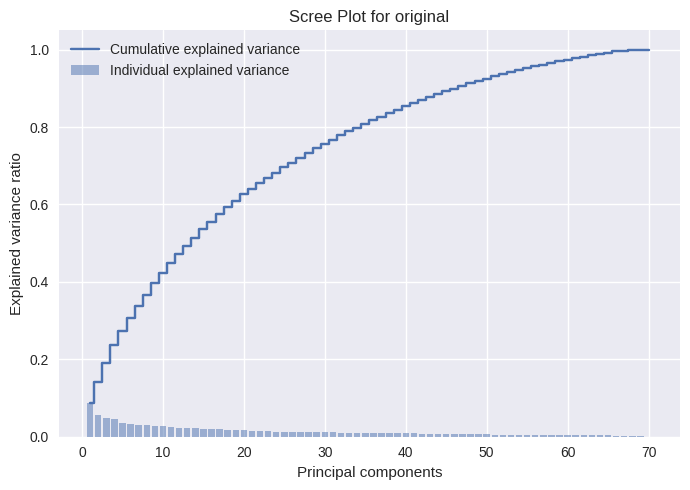

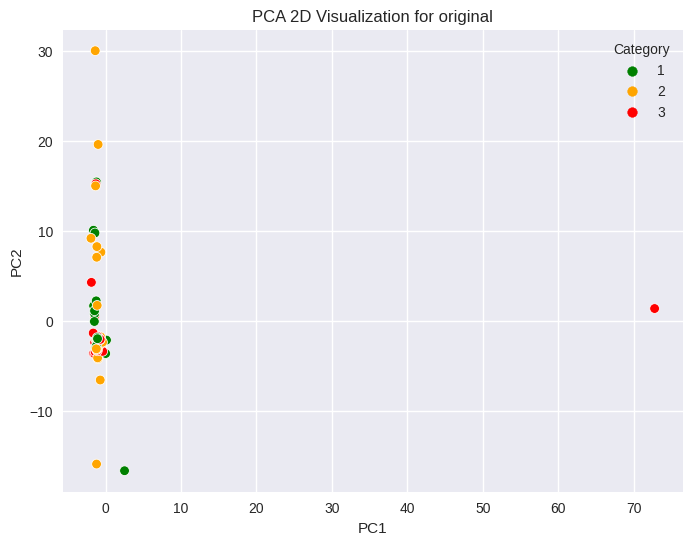

original_pipeline:


,Features,Influence
139,140,1.5668
574,575,1.5638
686,687,1.5264
464,465,1.5239
299,300,1.5232
528,529,1.5219
608,609,1.5073
563,564,1.4963
249,250,1.4956
473,474,1.4894


In [201]:
# Aply pipeline for visual results
results_original_pca= pca_pipeline(original, 'Category', n_components=2, dataset_name='original')

# Apply the pipeline for numerical results
original_pca_pipeline, df_pca_influence_original, explained_variance_original, n_components = apply_pipeline_pca(original, "original", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_original.head(10), explained_variance_original.head(10))

### original impressions:
   - original shows no aglomeration nor useful information which is expected the noise due to the large amount of data and features/sample ratio. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named original_pca and is composed of 51 features.
### original_pca: Making up a dataframe from the feature_influencers from pca results

In [227]:
df_pca_influence_columns = df_pca_influence_original["Features"].head(50).values.tolist()
original_pca = original[["Category"] + df_pca_influence_columns]  

In [228]:
original_pca.head()

,Category,140,575,687,465,300,529,609,564,250,...,127,44,155,503,41,236,542,259,516,289
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0431,0.0862,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_2,1,0.0000,0.0379,0.1138,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_3,1,0.0000,0.0614,0.1719,0.0000,0.0000,0.0123,0.0000,0.0123,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_4,1,0.0000,0.0176,0.1036,0.0044,0.0000,0.0066,0.0000,0.0154,0.0000,...,0.0000,0.0000,0.0044,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_5,1,0.0000,0.0479,0.0847,0.0000,0.0000,0.0110,0.0000,0.0331,0.0000,...,0.0000,0.0000,0.0350,0.0074,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## 4.2. uniques: Computing PCA and Varianza -Scree Plots
selected data from the original only unique genera per category is in this dataframe of 343 genera.

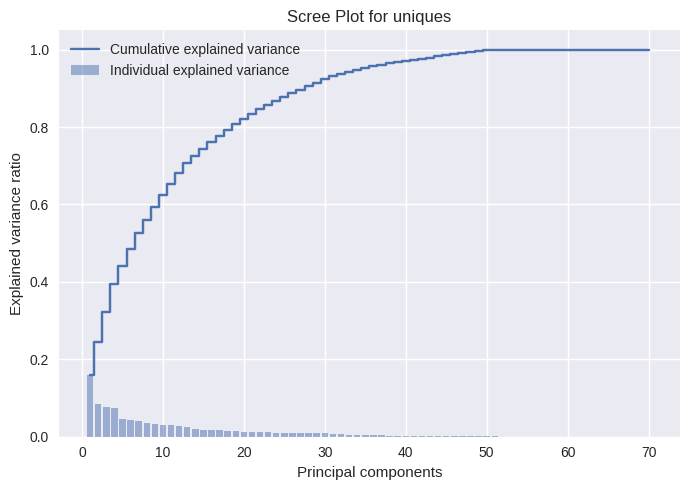

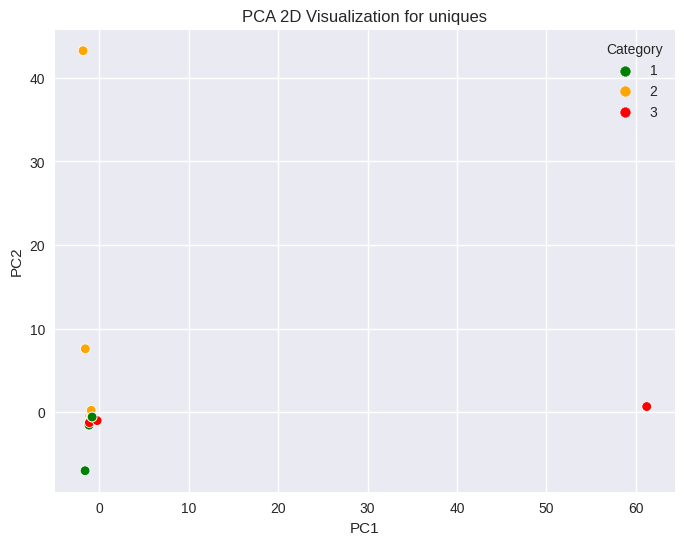

uniques_pipeline:


,Features,Influence
243,704,1.6067
36,87,1.6067
86,238,1.6065
148,442,1.6056
224,649,1.5352
73,201,1.4858
77,211,1.4858
233,680,1.4826
237,690,1.4072
201,578,1.3929


In [203]:
# Aply pipeline for visual results
results_uniques_pca = pca_pipeline(uniques, 'Category', n_components=2, dataset_name='uniques')

# Apply the pipeline for numerical results
uniques_pca_pipeline, df_pca_influence_uniques, explained_variance_uniques, n_components = apply_pipeline_pca(uniques, "uniques", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques.head(10), explained_variance_uniques.head(10))

### uniques insides
The explained variance improves referent to original df but the pca plot show very little diferenciation. However the first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques_pca and is composed of 51 features.
### uniques_pca: Making up a dataframe from the feature_influencers from pca results

In [204]:
# print the genera from this pca to check #print(f"Genera uniques : {df_pca_influence['Features'].values.tolist()}")
print(*df_pca_influence_uniques['Features'].values.tolist())

704 87 238 442 649 201 211 680 690 578 621 160 696 190 457 361 594 396 240 123 857 85 494 558 132 635 436 410 477 427 46 399 244 571 122 698 22 287 239 576 382 856 406 412 645 872 104 225 636 78 355 511 541 372 580 242 879 547 496 385 2 50 142 446 642 499 548 458 301 778 672 793 803 710 105 459 498 468 409 464 726 539 612 5 97 524 159 544 450 492 131 348 448 293 288 407 340 256 418 552 583 208 478 435 298 713 839 515 667 106 513 326 221 665 345 815 215 220 262 877 303 133 346 342 25 80 527 476 779 682 593 403 840 860 849 14 138 10 291 177 693 21 252 673 485 170 213 381 439 119 333 203 15 116 115 60 772 76 823 16 824 93 545 825 861 59 814 692 798 70 188 763 799 452 788 517 826 472 579 185 852 868 501 827 363 795 811 790 786 836 782 832 781 833 834 776 835 806 756 738 810 797 792 63 62 61 366 222 516 874 241 187 176 473 536 679 755 780 56 58 57 744 283 619 764 749 791 689 774 502 505 568 264 623 846 383 813 353 629 821 624 700 843 841 783 796 397 844 338 627 718 560 54 19 842 559 818 838

In [229]:
df_pca_influence_columns = df_pca_influence_uniques["Features"].head(50).values.tolist()
uniques_pca = uniques[["Category"] + df_pca_influence_columns]  

## 4.3. uniques23 Computing PCA and Varianza -Scree Plots
selected data from the original only unique genera per category is in this dataframe plus the common genera between 2 and 3 categories, contains 771 genera.

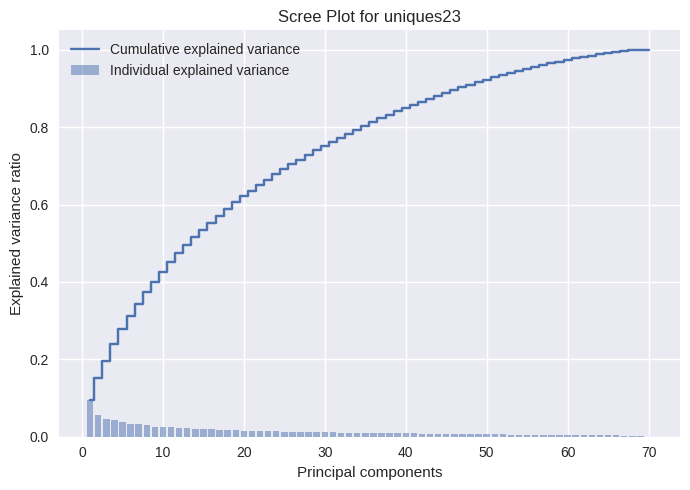

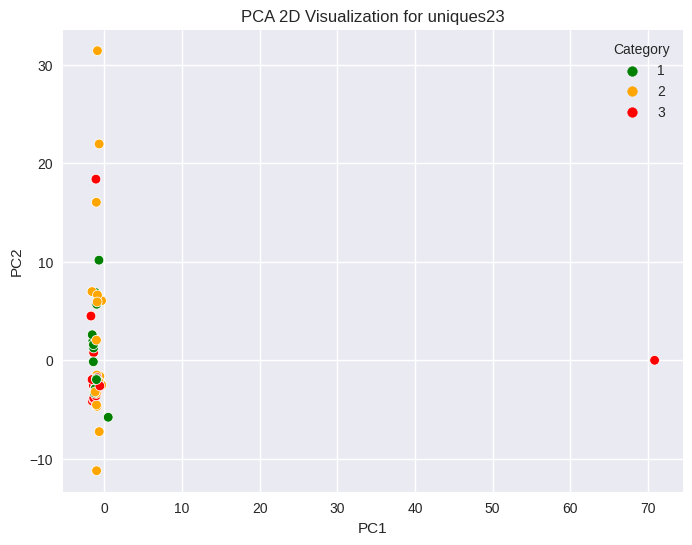

uniques23_pipeline:


,Features,Influence
203,236,1.7136
223,259,1.7136
476,542,1.7136
34,41,1.7136
165,194,1.6709
496,566,1.6660
405,465,1.6643
450,512,1.6622
250,289,1.6473
278,323,1.6459


In [206]:
# Aply pipeline for visual results
results_uniques23_pca = pca_pipeline(uniques23, 'Category', n_components=2, dataset_name='uniques23')

# Apply the pipeline for numerical results
uniques23_pca_pipeline, df_pca_influence_uniques23_pca, explained_variance_uniques23_pca, n_components = apply_pipeline_pca(uniques23, "uniques23", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23_pca.head(10), explained_variance_uniques23_pca.head(10))

### uniques23
The explained variance is worse than uniques df and the pca plot show very little diferenciation. Notive that some influencer genera that are in original_pca are also on unique_pca. The first 50 features by influence will be taken to make up a dataframe to see if these data gives important information all together. New dataframe named uniques23_pca and is composed of 51 features.
### uniques23_pca: Making up a dataframe from the feature_influencers from pca results

In [ ]:
print(*df_pca_influence_uniques23_pca["Features"].head(50).values.tolist())

236 259 542 41 194 566 465 512 289 323 127 110 358 621 270 330 687 720 284 265 529 456 634 276 250 140 497 214 413 139 300 223 655 243 606 575 607 81 552 591 44 39 389 86 108 526 195 308 343 614 705 856 382 239 576 176 875 96 660 362 484 503 516 379 324 587 33 344 432 271 474 581 332 719 151 445 366 494 411 695 360 336 145 337 388 190 491 530 356 229 154 680 471 455 717 91 18 227 8 543 20 440 398 457 594 361 649 733 519 551 386 645 412 406 556 78 335 466 211 172 201 82 254 387 32 641 355 511 865 731 704 87 408 572 277 631 414 879 385 496 242 547 514 709 2 663 354 125 626 349 46 427 410 477 155 216 369 628 863 84 609 539 464 612 726 5 611 703 449 647 97 118 582 171 351 244 698 122 571 22 314 315 200 433 664 716 574 577 222 304 613 192 646 853 569 17 107 373 83 248 327 375 881 544 671 737 273 384 438 561 238 442 585 509 727 88 376 557 584 541 401 322 143 279 652 636 872 104 225 237 89 417 51 245 34 518 431 226 430 588 715 869 339 625 101 113 421 329 161 712 674 548 206 235 166 871 725 28

In [230]:
df_pca_influence_columns = df_pca_influence_uniques23_pca["Features"].head(50).values.tolist()
uniques23_pca = uniques23[["Category"] + df_pca_influence_columns] 

## 4.4. Influencers_OLS: Computing PCA and Varianza -Scree Plots
selected data from the original with abundance threshold of 0,2% and frequency of 3, underwent selection of significance by OLS

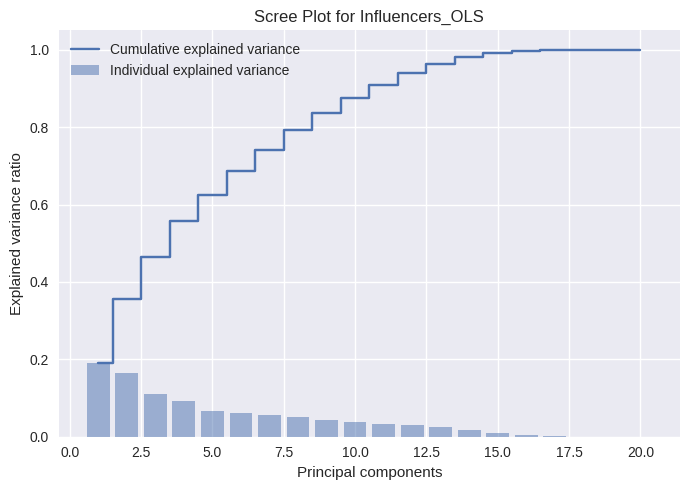

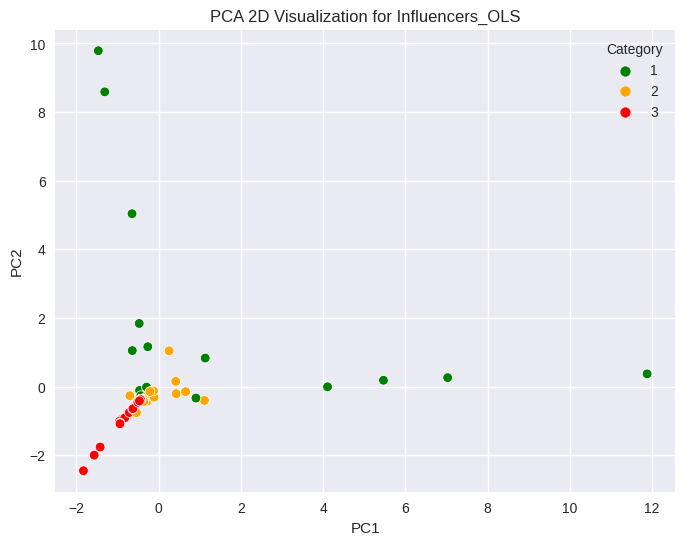

Influencers_OLS_pipeline:


,Features,Influence
14,408,2.9940
7,526,2.7758
3,351,2.7268
18,471,2.6385
8,584,2.4949
17,375,2.3507
5,91,2.2462
12,678,2.2045
15,334,2.0886
6,863,2.0526


In [209]:
# Aply pipeline for visual results
results_Influencers_OLS_pca = pca_pipeline(Influencers_OLS, 'Category', n_components=2, dataset_name='Influencers_OLS')
# Apply the pipeline for numerical results
Influencers_OLS_pca_pipeline, df_pca_influence_Influencers_OLS, explained_variance_Influencers_OLS, n_components = apply_pipeline_pca(Influencers_OLS, "Influencers_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_OLS.head(10), explained_variance_Influencers_OLS.head(10))

### Influencers_OLS 
   - This dataframe, representing the most influential genera both statistically and quantitatively, shows a clearer separation among the categories, especially between category 3 and 1. 
   - Category 3 There is a clear regression trend in category 3 
   - Category 2 dots align in the middle, indicating they share some characteristics with category 3 but also have distinct features.
   - Category 1 displays a 'v' shape, with category 3 forming the root, category 2 at the intersection, and the two arms of the 'Y' representing the spread of category 1. This pattern might indicate that category 1 encompasses a broader range of variance or interactions compared to the other categories.  

__Scree Plots:__ The Influencers_OLS dataset appears to decrease its explained variance more steeply compared to the OLS_all dataset.

## 4.5.  OLS_all: Computing PCA and Varianza -Scree Plots
selected data from the original underwent selection of significance by OLS.

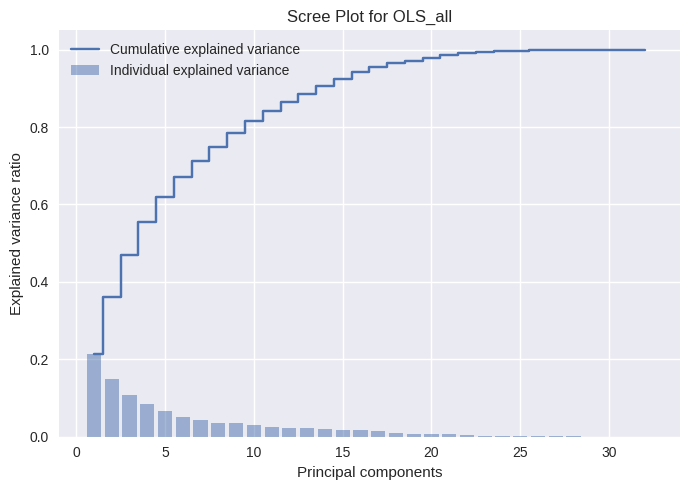

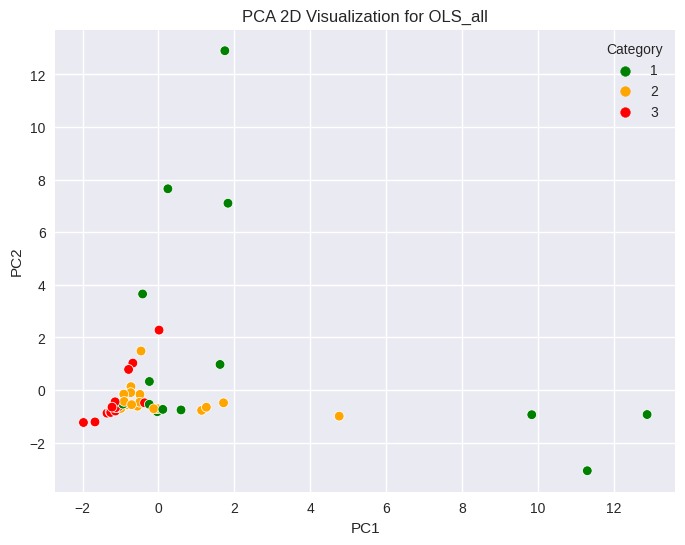

OLS_all_pipeline:


,Features,Influence
31,229,2.4905
7,91,2.4232
26,334,2.4185
4,470,2.2937
3,214,2.2573
17,494,2.1636
10,584,2.1621
25,92,2.1547
15,337,1.8287
27,140,1.7922


In [210]:
# Aply pipeline for visual results
Results_OLS_all_pca = pca_pipeline(OLS_all, 'Category', n_components=2, dataset_name='OLS_all')
# Apply the pipeline for numerical results
OLS_all_pca_pipeline, df_pca_influence_OLS_all, explained_variance_OLS_all, n_components = apply_pipeline_pca(OLS_all, "OLS_all", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_OLS_all.head(10), explained_variance_OLS_all.head(10))

### OLS_all
   - The scenario for the whole data is more intricate. The categories are not as distinctly separated, indicating a more complex interplay of features.
   - While category 1 also forms a 'Y' shape, the distinction is less clear due to the overlap with categories 2 and 3. This overlap suggests shared characteristics or interactions among the categories.

In both scree plots, OLS_all and Influencers_OLS a clear "elbow point" is observed around the 5th principal component. This suggests that retaining the first 5 components captures a significant portion of the variance in the data. However, Influencers_OLS seems to achieve a higher explanatory power with fewer features compared to OLS_all, moreover the differentiation on the labels makes this dataset more relevant. According to the principle of parsimony or Occam's Razor, which states that among competing hypotheses, the one with the fewest assumptions should be selected, in this case Influencers_OLS. Until the biological significance is not accounted for, the datasets are to be retained for comparison.

## 4.6. uniques_OLS Computing PCA and Varianza -Scree Plots
selected data from the original only Genera samples that do no share category were selected, posterior underwent selection of significance by OLS.

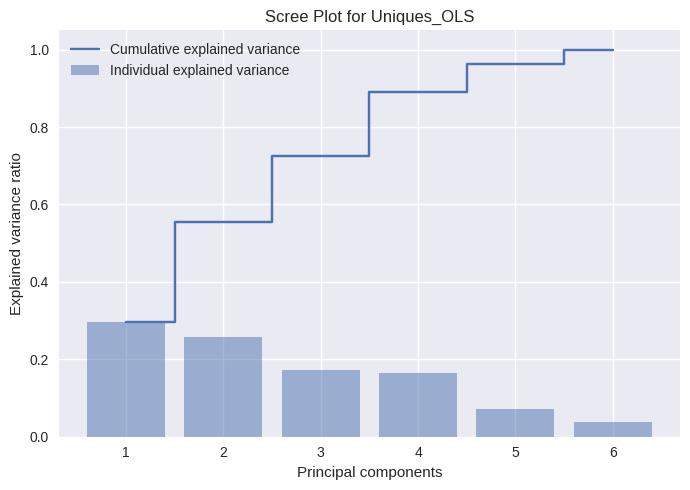

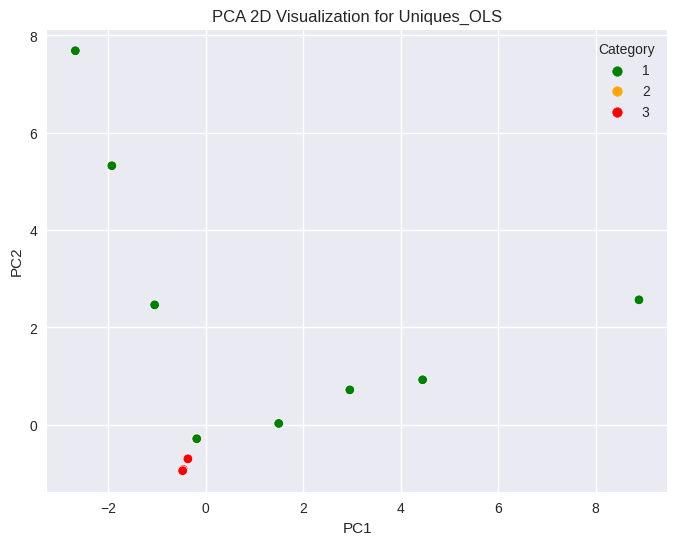

Uniques_OLS_pipeline:


,Features,Influence
0,541,1.7063
1,494,1.6987
2,201,1.4997
4,410,1.4997
5,799,1.0094
3,342,0.9827
,Component,Explained Variance Ratio
0,1,0.2935
1,2,0.2711
2,3,0.1697


In [211]:
# Aply pipeline for visual results
Results_uniques_OLS_pca = pca_pipeline(uniques_OLS, 'Category', n_components=2, dataset_name='Uniques_OLS')
# Apply the pipeline for numerical results
uniques_OLS_pca_pipeline, df_pca_influence_uniques_OLS, explained_variance_uniques_OLS, n_components = apply_pipeline_pca(uniques_OLS, "Uniques_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques_OLS.head(10), explained_variance_uniques_OLS.head(10))

### uniques_OLS:
   - Uniques_OLS is compound of only 6 features and interestingly it shows the best differenciation on the pca of the components. Also the varianza increases from 0.2 on the previous dfs to 0.3 explained variance. Showing that this features can explain better the dataset in reference to the corrosion rick label. 
   - The v shape of the category 1 is very clear and so is the lineal presence of category 3.  

## 4.7. uniques_23_OLS: Computing PCA and Varianza -Scree Plots
selected data from the original only Genera samples that do no share category were selected, plus the common genera from category 2 and 3, posterior underwent selection of significance by OLS.

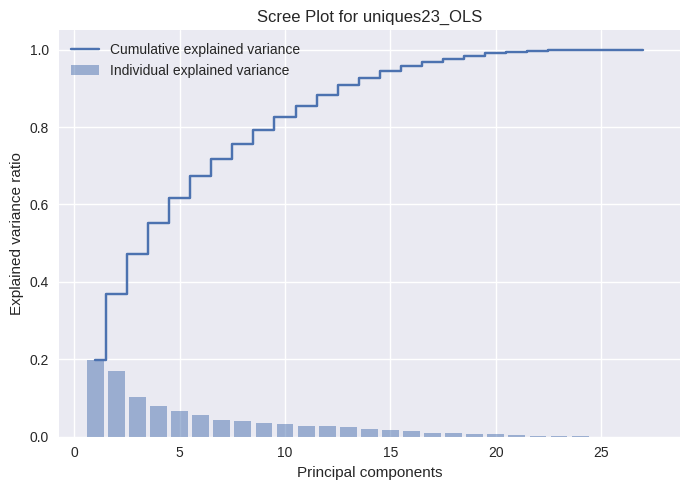

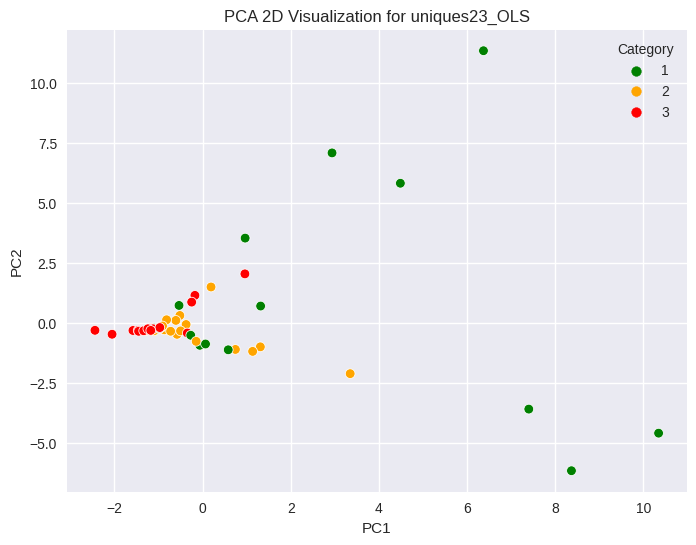

uniques23_OLS_pipeline:


,Features,Influence
26,229,2.5147
6,91,2.4703
4,470,2.3543
22,334,2.3338
3,214,2.2134
9,584,2.1912
13,337,2.1693
18,678,2.0656
11,799,1.9529
15,494,1.8830


In [212]:
# Aply pipeline for visual results
results_uniques23_OLS_pca = pca_pipeline(uniques23_OLS, 'Category', n_components=2, dataset_name='uniques23_OLS')
# Apply the pipeline for numerical results
uniques23_OLS_pca_pipeline, df_pca_influence_uniques23_OLS, explained_variance_uniques23_OLS, n_components = apply_pipeline_pca(uniques23_OLS, "uniques23_OLS", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_uniques23_OLS.head(10), explained_variance_uniques23_OLS.head(10))

### uniques23__OLS:
   - Uniques_23 is compose of more as 300 features and interestingly shows the worst differenciation blobs on the pca components. Also the varianza decreases from 0.3 on the previous df to 0.2 explained variance. Showing that this features have to be decreased in order to increase significance in reference to the corrosion rick label. 
   - Category 1 has very clear separation similar to the previous dataframes, however 2 and 3 are overlaped yet feature 3 continues to present a lineal regresion between the two PC.

# 5. Pipelines Predictive Analysis
## 5.1 Pipeline for Regression script

In [231]:
def apply_pipeline_regressor(df, dataset_name):
    print(f"{dataset_name}_pipeline:")
    '''
    Pipeline for regression that handles the imbalanced data
    '''
    
    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()
    
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)
    
    # Separate features and target Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Compute sample weights for the entire training set
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    
    # Reshape target variables
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    # K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rf_mae_scores = []
    
    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    
    for train_index, val_index in kf.split(X_train):
        # Split the current fold's train and validation sets
        X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val = y_train[train_index], y_train[val_index]
        
        # Compute sample weights for the current fold
        fold_weights = compute_sample_weight(class_weight='balanced', y=y_train_fold)
        
        # Train and predict with sample weights
        rf_pipeline.fit(X_train_fold, y_train_fold, rf__sample_weight=fold_weights)
        y_pred = rf_pipeline.predict(X_val)
        
        # Calculate and store MAE
        mae = mean_absolute_error(y_val, y_pred).round(4)
        rf_mae_scores.append(mae)
    
    print(f"Cross-Validation MAE Scores for RF: {rf_mae_scores}")
    print(f"Average MAE for RF: {np.mean(rf_mae_scores).round(4)}")
    
    # Evaluate on the initial test split with sample weights
    rf_pipeline.fit(X_train, y_train, rf__sample_weight=sample_weights)
    y_test_pred = rf_pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_test_pred).round(4)
    print(f'Mean Squared Error: {mse}')
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(4)
    print(f'Root Mean Squared Error: {rmse}')
    mae = mean_absolute_error(y_test, y_test_pred).round(4)
    print(f'Mean Absolute Error: {mae}')
    
    # Extract feature importances from RandomForestRegressor
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create a DataFrame to view the results
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(f'Feature Importance by RF: {df_importances_rf.head(25)}')
    
    return rf_pipeline, df_importances_rf

* **MSE (Mean Squared Error):** Measures the average of the squares of the errors.
* __RMSE (Root Mean Squared Error):__ Square root of MSE. It's in the same units as the output variable and gives a higher penalty for larger errors.
* __MAE (Mean Absolute Error):__ Measures the average of the absolute errors.

## 5.2. Pipeline for Clasification script

In [232]:
def apply_classification_pipeline_classif(df, dataset_name):
    print(f"{dataset_name}_pipeline:") 

    # Reset the index and move the "Sites" index to a column
    df = df.reset_index()
    
    # Ensure that "Sites" is explicitly treated as a string
    df['Sites'] = df['Sites'].astype(str)

    # Separate features and target  Store original feature names and separate features and target
    feature_names = [col for col in df.columns if col not in ['Category', 'Sites']]
    X = df[feature_names]
    y = df['Category']
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    # Reshape target variables for consistency
    y_train = y_train.values
    y_test = y_test.values 

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize lists to store performance metrics
    cv_accuracy_scores = []
    cv_precision_scores = []
    cv_recall_scores = []
    cv_f1_scores = []

    rf_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            class_weight=class_weight_dict  # Use computed class weights
        ))
    ])
    
    # Perform cross-validation
    for train_index, val_index in skf.split(X_train, y_train):
        # Split training data
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Fit pipeline on training fold
        rf_pipeline.fit(X_fold_train, y_fold_train)
    
        # Predict on validation fold
        y_pred = rf_pipeline.predict(X_fold_val)
    
        # Calculate and store performance metrics
        cv_accuracy_scores.append(accuracy_score(y_fold_val, y_pred).round(4))
        cv_precision_scores.append(precision_score(y_fold_val, y_pred, average='weighted').round(4))
        cv_recall_scores.append(recall_score(y_fold_val, y_pred, average='weighted').round(4))
        cv_f1_scores.append(f1_score(y_fold_val, y_pred, average='weighted').round(4))

    # Print cross-validation results
    print("Cross-Validation Metrics:")
    print(f"Accuracy: {cv_accuracy_scores}")
    print(f"Average Accuracy: {np.mean(cv_accuracy_scores).round(4)}")
    print(f"Precision: {cv_precision_scores}")
    print(f"Average Precision: {np.mean(cv_precision_scores).round(4)}")
    print(f"Recall: {cv_recall_scores}")
    print(f"Average Recall: {np.mean(cv_recall_scores).round(4)}")
    print(f"F1-Score: {cv_f1_scores}")
    print(f"Average F1-Score: {np.mean(cv_f1_scores).round(4)}")

    # Final model fit on entire training data
    rf_pipeline.fit(X_train, y_train)

    # Predict on test set
    y_test_pred = rf_pipeline.predict(X_test)

    # Confusion Matrix and Classification Report
    print("\nTest Set Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Extract feature importances
    feature_importances = rf_pipeline.named_steps['rf'].feature_importances_
    
    # Create feature importance DataFrame
    df_importances_rf = pd.DataFrame({
        'Features': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print('\nFeature Importance:')
    print(df_importances_rf)
          
    return rf_pipeline, df_importances_rf

# 6. Results Predictive Analysis

## 6.1. original Regression and Classification

In [234]:
# Apply pipeline Regression
original_pca_pipeline_reg, df_importances_reg_original_pca= apply_pipeline_regressor(original_pca, "original_pca")
# Apply the pipeline Classification
original_pca_pipe_class, df_importances_original_pca = apply_classification_pipeline_classif(original_pca, "original_pca")

original_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6808, 0.9522, 0.5943, 0.4395, 0.7379]
Average MAE for RF: 0.6809
Mean Squared Error: 0.36
Root Mean Squared Error: 0.6
Mean Absolute Error: 0.4956
Feature Importance by RF:     Features  Importance
0        140      0.1133
17       526      0.1003
26       270      0.0916
20       323      0.0790
14       566      0.0741
10       491      0.0739
1        575      0.0572
12       727      0.0482
19       456      0.0357
9        474      0.0344
5        529      0.0342
25       591      0.0311
2        687      0.0309
34       455      0.0261
13        81      0.0192
18        86      0.0167
22       265      0.0166
42       155      0.0128
7        564      0.0123
31       607      0.0111
23       875      0.0094
4        300      0.0093
6        609      0.0087
38       606      0.0083
43       503      0.0079
original_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average Accuracy: 0.5349
Precision: [0.4826, 0.202, 0.6818, 0.3961, 0.5818]
Average Precision: 0.4689
Recall: [0.5833, 0.3636, 0.6364, 0.5455, 0.5455]
Average Recall: 0.5349
F1-Score: [0.511, 0.2597, 0.6508, 0.4589, 0.5424]
Average F1-Score: 0.4846

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.50      0.57      0.53         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.49      0.50      0.49        14


Feature Importance:
    Features  Importance
17       526      0.0886
10       491      0.0844
20       323      0.0772
1        575      0.0622
26       270      0.0584
2        687      0.0512
12   

### Original discussion
**Original_PCA_pipeline Regression**:
This pipeline shows moderate performance in regression and classification tasks. The Mean Absolute Error (MAE) is around 0.6756, with an average accuracy of 0.4571. The feature importance is distributed across multiple features, with features 323, 491, and 526 being the most significant. This pipeline does not seem to offer significant improvements over the existing pipelines.
**Original_pca_pipeline Classification**
Low cross-validation accuracy (0.4571) and inconsistent performance.
Class 1: Zero precision and recall, indicating an inability to classify this category.This pipeline is weaker than all of the others.

## 6.2. uniques_pca Regression and Classification

In [235]:
# Apply pipeline Regression
uniques_pca_pipeline_reg, df_importances_reg_uniques_pca= apply_pipeline_regressor(uniques_pca, "uniques_pca")
# Apply the pipeline Classification
uniques_pca_pipe_class, df_importances_uniques_pca = apply_classification_pipeline_classif(uniques_pca, "uniques_pca")

uniques_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.5408, 0.7019, 0.4957, 0.3486, 0.6769]
Average MAE for RF: 0.5528
Mean Squared Error: 0.4413
Root Mean Squared Error: 0.6643
Mean Absolute Error: 0.4801
Feature Importance by RF:    Features  Importance
9       578      0.1765
22      494      0.1555
7       680      0.1222
5       201      0.0893
6       211      0.0690
0       704      0.0616
1        87      0.0574
23      558      0.0340
24      132      0.0339
4       649      0.0293
26      436      0.0266
25      635      0.0242
12      696      0.0196
43      412      0.0169
44      645      0.0126
11      160      0.0111
47      225      0.0098
10      621      0.0077
46      104      0.0076
45      872      0.0068
42      406      0.0065
2       238      0.0058
13      190      0.0041
48      636      0.0024
49       78      0.0021
uniques_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average Accuracy: 0.5167
Precision: [0.8438, 0.5568, 0.8182, 0.8295, 0.8636]
Average Precision: 0.7824
Recall: [0.5833, 0.5455, 0.4545, 0.5455, 0.4545]
Average Recall: 0.5167
F1-Score: [0.5822, 0.4897, 0.4242, 0.5449, 0.4779]
Average F1-Score: 0.5038

Test Set Evaluation:
Confusion Matrix:
[[3 0 0]
 [4 3 0]
 [3 0 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.30      1.00      0.46         3
           2       1.00      0.43      0.60         7
           3       1.00      0.25      0.40         4

    accuracy                           0.50        14
   macro avg       0.77      0.56      0.49        14
weighted avg       0.85      0.50      0.51        14


Feature Importance:
   Features  Importance
10      621      0.1156
2       238      0.0844
9       578      0.0666
49       78      0.0625
8       690      0.0570
31      399      0.0522
6       21

### uniques_pca discussion
**uniques_PCA_pipeline Regression**:
Moderate average MAE (0.5302) but still higher than Influencers_OLS.
Feature importance concentrated on a few features (e.g., 418, 410, 578).This pipeline is slightly better than original_pca_pipeline but not as strong as Influencers_OLS.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5714) but class imbalance issues.
Class 1: Zero precision and recall.
Class 2: Moderate precision and high recall.
Class 3: Perfect precision and recall but limited support. This pipeline is slightly better than original_pca_pipeline but still has significant class imbalance issues.

## 6.3. uniques23_pca Regression and Classification

In [236]:
# Apply pipeline Regression
uniques23_pca_pipeline_reg, df_importances_reg_uniques23_pca= apply_pipeline_regressor(uniques23_pca, "uniques23_pca")
# Apply the pipeline Classification
uniques23_pca_pipe_class, df_importances_uniques23_pca = apply_classification_pipeline_classif(uniques23_pca, "uniques23_pca")

uniques23_pca_pipeline:
Cross-Validation MAE Scores for RF: [0.6717, 0.8082, 0.4745, 0.3055, 0.6045]
Average MAE for RF: 0.5729
Mean Squared Error: 0.4196
Root Mean Squared Error: 0.6478
Mean Absolute Error: 0.5293
Feature Importance by RF:    Features  Importance
11      110      0.2010
25      140      0.1119
45      526      0.0788
5       566      0.0658
9       323      0.0650
14      270      0.0564
27      214      0.0518
21      456      0.0352
35      575      0.0331
16      687      0.0316
49      614      0.0309
29      139      0.0250
22      634      0.0239
37       81      0.0214
23      276      0.0199
39      591      0.0182
43       86      0.0151
18      284      0.0146
20      529      0.0134
34      606      0.0127
30      300      0.0088
36      607      0.0087
24      250      0.0079
19      265      0.0077
40       44      0.0062
uniques23_pca_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average Accuracy: 0.5333
Precision: [0.6448, 0.2273, 0.5, 0.7121, 0.4864]
Average Precision: 0.5141
Recall: [0.6667, 0.3636, 0.5455, 0.6364, 0.4545]
Average Recall: 0.5333
F1-Score: [0.6377, 0.2797, 0.4394, 0.6228, 0.4646]
Average F1-Score: 0.4888

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 5 1]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.62      0.71      0.67         7
           3       0.67      0.50      0.57         4

    accuracy                           0.64        14
   macro avg       0.65      0.63      0.63        14
weighted avg       0.65      0.64      0.64        14


Feature Importance:
   Features  Importance
11      110      0.1098
45      526      0.1014
9       323      0.0762
29      139      0.0514
25      140      0.0505
49      614      0.0500
35      575  

### uniques23_pca discussion
**uniques_PCA_pipeline Regression**:
Higher average MAE (0.6247) and higher variability in MAE scores.
Feature importance distributed across multiple features. This pipeline does not offer significant improvements over the existing pipelines.
**uniques_pca_pipeline Classification**
Moderate cross-validation accuracy (0.5286) with consistent but low accuracy across folds.
Class 1: Perfect precision but very low recall.
Class 2: Moderate precision and high recall.
Class 3: Zero precision and recall. This pipeline has similar issues to the other pipelines, particularly with class imbalance.

Analysing the three new created dfs from the pca dimensionality reduction step. We see that The uniques_pca_pipeline shows the lowest MAE, indicating it performs best in terms of prediction error. The uniques_pca_pipeline also has the highest accuracy.
Each pipeline has slightly different top features.
original_pca_pipeline top features: 42 323 (0.1183), 27 491 (0.0882)
uniques23_pca_pipeline top features: 11 323 (0.1204), 15 491 (0.0754)
uniques_pca_pipeline top features: 10 418 (0.1997), 34 410 (0.1751)

## 6.4. Influencers_OLS Regression and Classification

In [237]:
# Apply pipeline Regression
Influencers_pipeline_reg, Importances_rf_Influencers_Influencers_OLS = apply_pipeline_regressor(Influencers_OLS, "Influencers_OLS")

# Apply the pipeline Classification
Influencers_pipe_class, importances_class_Influencers_OLS = apply_classification_pipeline_classif(Influencers_OLS, "Influencers_OLS")

Influencers_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.3458, 0.2718, 0.1827, 0.1818, 0.1764]
Average MAE for RF: 0.2317
Mean Squared Error: 0.1712
Root Mean Squared Error: 0.4137
Mean Absolute Error: 0.2443
Feature Importance by RF:    Features  Importance
16      549      0.5054
7       526      0.1972
11      864      0.0650
6       863      0.0444
14      408      0.0386
2       214      0.0251
19      229      0.0234
5        91      0.0228
10      625      0.0160
13      565      0.0145
15      334      0.0137
3       351      0.0136
4        23      0.0124
17      375      0.0056
8       584      0.0019
18      471      0.0005
12      678      0.0000
0       725      0.0000
1       871      0.0000
9       712      0.0000
Influencers_OLS_pipeline:
Cross-Validation Metrics:
Accuracy: [0.9167, 0.9091, 0.8182, 0.8182, 0.8182]
Average Accuracy: 0.8561
Precision: [0.9306, 0.9242, 0.8701, 0.8701, 0.8182]
Average Precision: 0.8826
Recall: [0.9167, 0.9091, 0.8182, 0.8182, 0.8182

### Influencers_OLS Discussion
**Influencers_OLS Pipeline Regression:**
Cross-Validation MAE Scores for RF: Consistently lower and less variable (ranging from 0.1426 to 0.34) with a significantly lower average MAE (0.242).
Error Metrics:
MSE: 0.2618; RMSE: 0.5116; MAE: 0.34  

These metrics demonstrate improved prediction accuracy and model reliability compared to OLS_all. Feature importance is more concentrated, with feature 526 having an overwhelming impact (importance: 0.4318). Other features like 549 and 625 show noticeable contributions but to a lesser extent.

**Influencers_OLS_pipeline Classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.8286 (high and consistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but lower recall (misclassifications lead to only 67% recall).  
Class 2: High recall (100%) but lower precision (64%).   
Class 3: High precision (100%) but very low recall (25%), indicating many false negatives.  
Classification Report:  
Macro average recall (0.64) suggests unbalanced performance across classes.  
Weighted average metrics reflect an overall acceptable but not ideal model for classifying all categories equally well.  
Feature Importance:  
Feature 526 dominates (23.26%), followed by moderately impactful features like 549 and 864.  

## 6.5. OLS_all Regression and Classification

In [238]:
# Apply pipeline Regression
OLS_all_pipe_reg, importances_reg_OLS_all = apply_pipeline_regressor(OLS_all, "OLS_all")

# Apply the pipeline classification
OLS_all_pipe_class, importances_class_OLS_all = apply_classification_pipeline_classif(OLS_all, "OLS_all")

OLS_all_pipeline:
Cross-Validation MAE Scores for RF: [0.7, 0.7109, 0.3736, 0.2518, 0.4764]
Average MAE for RF: 0.5025
Mean Squared Error: 0.3518
Root Mean Squared Error: 0.5931
Mean Absolute Error: 0.45
Feature Importance by RF:    Features  Importance
29      549      0.4051
6        23      0.0816
4       470      0.0703
3       214      0.0678
27      140      0.0678
31      229      0.0522
10      584      0.0452
14      625      0.0387
26      334      0.0242
1       871      0.0186
7        91      0.0179
23      565      0.0149
25       92      0.0139
22      605      0.0131
21      678      0.0126
0       725      0.0125
5        79      0.0071
8        88      0.0067
11      712      0.0067
24      426      0.0041
2       428      0.0040
9       480      0.0037
15      337      0.0036
30      771      0.0024
19      342      0.0019
OLS_all_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

Cross-Validation Metrics:
Accuracy: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average Accuracy: 0.553
Precision: [0.5278, 0.202, 0.3961, 0.4091, 0.6623]
Average Precision: 0.4395
Recall: [0.5833, 0.3636, 0.5455, 0.5455, 0.7273]
Average Recall: 0.553
F1-Score: [0.553, 0.2597, 0.4589, 0.4615, 0.6685]
Average F1-Score: 0.4803

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
   Features  Importance
29      549      0.1605
3       214      0.1094
31      229      0.1005
6        23      0.0627
4       470      0.0526
27      140      0.0521
7        91   

## OLS_all Discussion
**OLS_all_pipeline regression:**
Cross-Validation MAE Scores for RF: Higher variability across folds (ranging from 0.3935 to 0.6886) and a higher average MAE (0.5725) suggest that the model's predictive performance is less consistent.
Error Metrics:
Mean Squared Error (MSE): 0.3921; Root Mean Squared Error (RMSE): 0.6262;Mean Absolute Error (MAE): 0.5634
These metrics indicate lower prediction accuracy compared to the Influencers_OLS pipeline.
**Importance** is more evenly distributed, with no single feature dominating.
Top features (e.g., feature 549, 23, and 625) exhibit moderate importance values (0.1883, 0.1233, 0.0887).

**OLS_all_pipeline classification:**
Performance Metrics:   
Cross-Validation Accuracy: 0.4714 (significantly lower, inconsistent across folds).  
Confusion Matrix:   
Class 1: Perfect precision but extremely low recall (17%), with many false negatives.   
Class 2: Moderate precision (45%) and high recall (83%), indicating a focus on this class.  
Class 3: Zero precision and recall, indicating an inability to classify this category.  
Classification Report:   
Macro and weighted averages are much lower than Influencers_OLS, indicating an overall weaker model.  
Feature Importance:   
Importance is more distributed but lower overall contributions compared to Influencers_OLS.   

## 6.6. uniques_OLS Regression and Classification

In [239]:
# Apply pipeline Regression
uniques_pipeline, importances_reg_uniques_OLS = apply_pipeline_regressor(uniques_OLS, "Uniques_OLS")
# Apply the pipeline Classification
uniques_pipe_class, importances_class_uniques_OLS = apply_classification_pipeline_classif(uniques_OLS, "unique_OLS")

Uniques_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.6302, 0.6662, 0.5366, 0.3111, 0.6006]
Average MAE for RF: 0.5489
Mean Squared Error: 0.4244
Root Mean Squared Error: 0.6515
Mean Absolute Error: 0.4848
Feature Importance by RF:   Features  Importance
0      541      0.3850
3      342      0.3199
2      201      0.2007
1      494      0.0626
5      799      0.0319
4      410      0.0000
unique_OLS_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicte

Cross-Validation Metrics:
Accuracy: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average Accuracy: 0.5364
Precision: [0.5227, 0.2066, 0.2066, 0.798, 0.4343]
Average Precision: 0.4336
Recall: [0.5, 0.4545, 0.4545, 0.6364, 0.6364]
Average Recall: 0.5364
F1-Score: [0.3938, 0.2841, 0.2841, 0.5974, 0.5065]
Average F1-Score: 0.4132

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 7 0]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.58      1.00      0.74         7
           3       1.00      0.25      0.40         4

    accuracy                           0.64        14
   macro avg       0.86      0.53      0.55        14
weighted avg       0.79      0.64      0.59        14


Feature Importance:
  Features  Importance
0      541      0.3192
3      342      0.2839
2      201      0.2149
1      494      0.1226
5      799      0.0595
4      410      0.0000


### uniques_OLS Discussion
**uniques_OLS_pipeline Regression:**
Cross-Validation MAE Scores for RF: Higher variability (range 0.3783–0.7313) and a comparable average MAE (0.572).  
Error Metrics:  
MSE: 0.7412 ; RMSE: 0.8609 ; MAE: 0.7313 (relatively high).  These metrics are slightly higher than those of the unique23 pipeline, suggesting a slightly higher level of error.
These metrics reflect suboptimal predictive performance compared to other datasets.  
Feature Importance:   
Importance is relatively concentrated among the top three features (541: 0.2426, 342: 0.2327, 410: 0.2050), suggesting a model reliant on a few key variables.  
**uniques_OLS_pipeline Classification:**
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.4286 to 0.7143, with an average accuracy of 0.5429. This is slightly better than the unique23 pipeline but still shows variability.
Confusion Matrix and Classification Report:
Class 1: Zero precision and recall, indicating all instances of this class are misclassified.
Class 2: Perfect precision and recall for the instances classified, but the confusion matrix suggests many instances are not classified correctly.
Class 3: Zero precision and recall, similar to Class 1.
Features 229 and 214 have the highest importance (0.1008 and 0.0947, respectively), followed by features 549, 23, and 140. Distribution similar to the uniques23.

## 6.7. uniques_23_OLS Regression and Classification

In [240]:
# Apply pipeline Regression
unique_23_OLS_pipeline_rg, importances_rf_uniques23_OLS= apply_pipeline_regressor(uniques23_OLS, "unique23_OLS")
# Apply the pipeline Classification
# Apply the pipeline the working df
uniques23_pipe_class, importances_class_uniques23_OLS = apply_classification_pipeline_classif(uniques23_OLS, "unique23_OLS")

unique23_OLS_pipeline:
Cross-Validation MAE Scores for RF: [0.7033, 0.7282, 0.3764, 0.2709, 0.5136]
Average MAE for RF: 0.5185
Mean Squared Error: 0.3634
Root Mean Squared Error: 0.6028
Mean Absolute Error: 0.4593
Feature Importance by RF:    Features  Importance
25      549      0.4159
4       470      0.0794
5        23      0.0774
24      140      0.0710
3       214      0.0699
26      229      0.0560
9       584      0.0409
12      625      0.0379
22      334      0.0244
1       871      0.0225
6        91      0.0171
20      565      0.0144
19      605      0.0128
18      678      0.0125
0       725      0.0102
21      426      0.0066
7        88      0.0065
2       428      0.0043
13      337      0.0042
10      712      0.0041
16      342      0.0037
8       480      0.0031
11      799      0.0022
14      541      0.0021
15      494      0.0009
unique23_OLS_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average Accuracy: 0.5364
Precision: [0.4603, 0.202, 0.4667, 0.4091, 0.6364]
Average Precision: 0.4349
Recall: [0.5, 0.3636, 0.6364, 0.5455, 0.6364]
Average Recall: 0.5364
F1-Score: [0.4683, 0.2597, 0.5351, 0.4615, 0.6222]
Average F1-Score: 0.4694

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.44      0.57      0.50         7
           3       0.25      0.25      0.25         4

    accuracy                           0.43        14
   macro avg       0.56      0.38      0.42        14
weighted avg       0.51      0.43      0.43        14


Feature Importance:
   Features  Importance
25      549      0.1660
3       214      0.1063
26      229      0.0870
4       470      0.0743
24      140      0.0646
5        23      0.0620
6        91      

### uniques23_OLS Discussion
**unique23_OLS_pipeline Regression**:
Cross-Validation MAE Scores for RF: Less variability (range 0.3867–0.72) and slightly higher average MAE (0.5751).
Error Metrics:
MSE: 0.3868 ; RMSE: 0.622 ; MAE: 0.5623 (lower than uniques_OLS).These metrics indicate better performance than uniques_OLS, possibly due to the model leveraging a larger pool of features.

**Feature importance** is more evenly distributed across top contributors (e.g., 549: 0.1899, 23: 0.1025, 625: 0.0889). High-dimensionality could contribute to complexity but might also capture subtle interactions.  
**unique23_OLS_pipeline Classification**:
Cross-Validation Accuracy Scores for RF:
The accuracy scores range from 0.3571 to 0.5714, with an average accuracy of 0.4429. This indicates a moderate level of classification accuracy with significant variability.
Confusion Matrix and Classification Report:
Class 1: Perfect precision but very low recall (0.17), indicating many false negatives.
Class 2: Moderate precision (0.45) and high recall (0.83).
Class 3: Zero precision and recall, indicating all instances of this class are misclassified. Macro average recall is 0.33, suggesting unbalanced performance across classes.
Feature Importance:
Feature 229 has the highest importance (0.1008), followed by features 214, 549, 23, and 140. This indicates a spread of importance across several features.

**unique_23_OLS_pipeline** achieves slightly better predictive accuracy despite higher dimensionality, possibly due to capturing more complex interactions, performs better numerically. Suggesting that the dataset's complexity adds value despite reduced interpretability.
**uniques_OLS_pipeline**, though concise, has poorer error metrics, indicating potential underfitting or missing interactions and struggles with predictive accuracy.

## 6.8. Sumarizing Regression and Classification Pipelines Results
### Analysing the models Regression and Classification. 
Both pipelines struggle with class imbalance, leading to poor performance on certain classes.
Feature importance is similar but with slight variations, suggesting that the same set of features is important for classification in both pipelines.

# 7. Integration of Dataframes 
**Integrating Influencers_OLS and uniques_OLS**
So analysing the Influencers_OLS results it is seen that it clasify well class 1 and 3, however having fewer members of class 1, and uniques_OLS is a small dataframe that shows good classification on class 1. So the join of the two will be check. It is comprised of 27 genera.
**Integrating OLS_all and uniques_OLS**
This is likely better option because uniques_OLS has shown better performance in classifying Class 1, which is a weakness in OLS_all_pipeline. The feature importance distribution and the strengths in classifying Class 1 make it a good complement. However looking at the merge of the two of them, there is no need to join them since uniques is part of all. 

In [241]:
# Merging the dataframes OLS_all and uniques_OLS on idex "Sites
all_uniques= pd.merge(OLS_all, uniques_OLS, left_index=True, right_index=True, suffixes =('_all', '_uniques'))
# Drop any duplicate columns 
all_uniques= all_uniques.loc[:, ~all_uniques.columns.duplicated()]
all_uniques= all_uniques.drop(columns="Category_uniques")
all_uniques = all_uniques.rename(columns={"Category_all" : "Category"})
all_uniques.columns

Index(['Category', '725', '871', '428', '214', '470', '79', '23', '91', '88',
       '480', '584', '712', '90', '799_all', '625', '337', '541_all',
       '494_all', '657', '342_all', '410_all', '678', '605', '565', '426',
       '92', '334', '140', '201_all', '549', '771', '229', '541_uniques',
       '494_uniques', '201_uniques', '342_uniques', '410_uniques',
       '799_uniques'],
      dtype='object')

# 7.1. Influencers_uniques

In [242]:
# Ensure that the Sites index is sorted properly
Influencers_OLS = Influencers_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
uniques_OLS = uniques_OLS.sort_index(key=lambda x: x.str.extract('(\d+)', expand=False).astype(str))
# Merging the dataframes Influencers_OLS and uniques_OLS on idex "Sites
Influencers_uniques= pd.merge(Influencers_OLS, uniques_OLS, left_index=True, right_index=True, suffixes =('_Influencers', '_uniques'))
# Drop any duplicate columns 
Influencers_uniques= Influencers_uniques.loc[:, ~Influencers_uniques.columns.duplicated()]
Influencers_uniques= Influencers_uniques.drop(columns="Category_uniques")
Influencers_uniques = Influencers_uniques.rename(columns={"Category_Influencers" : "Category"})
Influencers_uniques = Influencers_uniques.reset_index()
Influencers_uniques = Influencers_uniques.astype({"Sites": str, "Category": int})
Influencers_uniques = Influencers_uniques.set_index("Sites")

## Influencers_unique: PCA, Regression and Classification

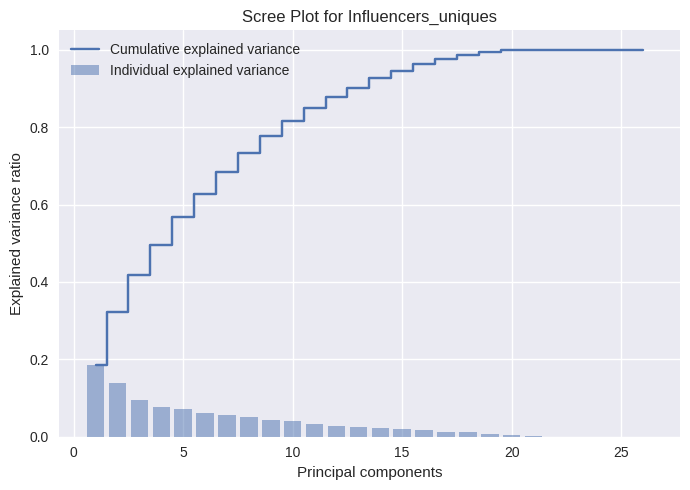

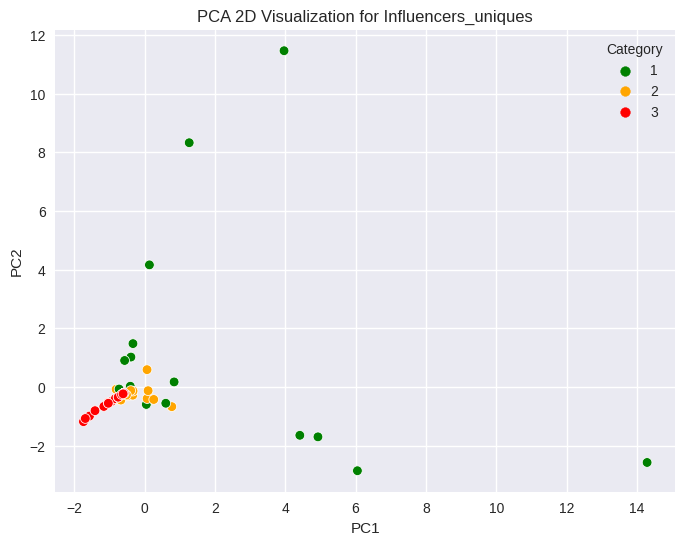

Influencers_uniques_pipeline:


,Features,Influence
3,351,2.7884
7,526,2.7823
8,584,2.6517
6,863,2.6188
5,91,2.5226
16,549,2.4494
11,864,2.4418
18,471,2.4326
14,408,2.4060
17,375,2.3493


Influencers_uniques_pipeline:
Cross-Validation MAE Scores for RF: [0.345, 0.2718, 0.1773, 0.1791, 0.1664]
Average MAE for RF: 0.2279
Mean Squared Error: 0.1715
Root Mean Squared Error: 0.4141
Mean Absolute Error: 0.2471
Feature Importance by RF:    Features  Importance
16      549      0.5109
7       526      0.1998
11      864      0.0651
6       863      0.0466
14      408      0.0360
19      229      0.0248
2       214      0.0243
4        23      0.0231
5        91      0.0209
3       351      0.0140
10      625      0.0138
13      565      0.0091
15      334      0.0085
18      471      0.0027
8       584      0.0003
22      201      0.0001
12      678      0.0000
17      375      0.0000
0       725      0.0000
1       871      0.0000
23      342      0.0000
21      494      0.0000
20      541      0.0000
24      410      0.0000
9       712      0.0000
Influencers_uniques_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.7273, 0.8182, 0.8182]
Average Accuracy: 0.821

In [243]:
# Aply pipeline for visual results
results_Influencers_uniques_pca = pca_pipeline(Influencers_uniques, 'Category', n_components=2, dataset_name='Influencers_uniques')

# Apply the pipeline for numerical results
Influencers_uniques_pipeline, df_pca_influence_Influencers_uniques, explained_variance_Influencers_uniques, n_components = apply_pipeline_pca(Influencers_uniques, "Influencers_uniques", n_components=2, n_top_features=50)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_uniques.head(10), explained_variance_Influencers_uniques.head(10))

# Apply pipeline Regression
Influencers_uniques_pipeline_reg, importances_reg_Influencers_uniques= apply_pipeline_regressor(Influencers_uniques, "Influencers_uniques")
# Apply the pipeline Classification
Influencers_uniques_pipe_class, importances_class_Influencers_uniques = apply_classification_pipeline_classif(Influencers_uniques, "Influencers_uniques")

### Influencers_uniques Discussion
**Influencers_uniques pipeline Regression**:
The model is performing well with low MAE variability, ranging from 0.1415 to 0.3307 and an average MAE of 0.24. Compared to previous datasets (like uniques_OLS_pipeline where the variability was higher), this suggests an improved and more reliable model.
MSE (0.2523) and RMSE (0.5022) indicate moderate error levels, which suggest the model is performing reasonably well in terms of prediction accuracy. These are substantially better than earlier models where error levels were high.
**Feature importance** 
Feature 526 stands out as the most significant with an importance score of 0.4293, followed by feature 549 at 0.2017. These scores point to a few dominating features, which aligns with my future approach of combining the most influential features across datasets. This can potentially improve both feature selection and model generalization when merged. Indeed, the features indicate a focus on a few predictors that contribute heavily to the outcome. This could be useful when aim to reduce features but still retain biologically relevant ones.  
**Influencers_uniques_pipeline Classification**:
Cross-Validation Accuracy: This model achieved an average classification accuracy of 0.9571, which is quite strong. The relatively high accuracy, along with a well-balanced confusion matrix, suggests that the model can differentiate well across the three categories.  
Confusion Matrix & Classification Report:
    Class 1: Precision is perfect (1.0), but recall suffers (0.67), indicating that there may be a misclassification problem with certain examples.
    Class 2: High recall (1.0), but lower precision (0.78), meaning the model is good at catching all instances of Class 2 but sometimes incorrectly classifies other categories as Class 2.
    Class 3: Very high precision (1.0) but lower recall (0.75), indicating some false negatives are present, but the classification of class 3 is still accurate when it happens.

This classification model is performing fairly well but could be further refined, especially in terms of recall for classes 1 and 3, perhaps with tweaks in model parameters.

Feature Importance: The top three most important features (526, 549, and 864) once again highlight a few dominating predictors. These feature priorities would be the core of my focus, moving forward into the feature selection across datasets using biological relevance.

Influencers_uniques regression performance is improving with reduced error and a more concentrated feature importance distribution. This is promising for further refinement. The classification performance suggests some room for improvement, particularly in balancing recall and precision across classes, especially for Class 1 and 3. Combining datasets with influential features and considering their biological relevance for dimensionality reduction is an effective way forward.
Feature selection based on importance, variance, and biological significance will help ensure the model remains robust while simplifying feature sets.

# 7.2. Merged_df: Combining Dataframes  
The dataframes with a significant degree of importance for the next phase will be retained. Uniques_OLS has already been combined to create Influencers_uniques. The original features' PCA performance may provide valuable insights into predicting overall behavior and will be carried forward as original_pca. However, dataframes such as uniques_pca, uniques23_pca, uniques23_OLS, and original do not demonstrate notable contributions toward improving the models. As a result, they will be dropped in this notebook after extracting their three most important features. The dataframe OLS_all will undergo further processing in the subsequent steps.
In order to get the most important Features that make up the dfs that will be discarded, the dfs will be join together and passed through the pipelines of this notebook, then we will have another df "mergers"

|DataFrame|   Genera ID   |
|---|  ---|
|original_pca|270 727 151 474 687 418 663 201 564 41 552 148 487 155 607 223 18 865 254 308 227 574 526 81 639 367 172 491 166 660 585 145 108 705 733 584 250 341 561 271 84 300 323 211 259 229 551 670 373 269  
|uniques_pca |190 578 160 696 457 594 361 123 240 396 418 680 201 87 704 649 427 477 46 78 355 511 385 2 242 879 571 698 244 122 22 639 367 197 410 85 436 635 558 132 494 636 872 225 104 621 239 576 382 856 
|uniques23_pca|270 41 526 172 865 151 300 18 552 487 474 323 663 687 108 491 148 574 250 86 373 535 245 127 308 561 214 276 660 155 455 563 330 269 575 81 254 484 551 271 607 194 140 709 566 529 497 572 389 200 |
|uniques23_OLS|725 871 428 214 470 23 91 88 480 584 712 799 625 337 541 494 342 410 678 605 565 426 334 201 140 549 229  |
|OLS_all |725 871 428 214 470 79 23 91 88 480 584 712 90 799 625 337 541 494 657 342 410 678 605 565 426 92 334 140 201 549 771 229  |



### Merging DataFrames 
Merging all dataframes, except Influencers_uniques on a single dataframe

In [244]:
# Colecting all columns names and ensure column names are all strings, strip and standardize)
original.columns = original.columns.astype(str).str.strip()  
original_pca_columns = [str(col).strip() for col in original_pca.columns.tolist()]
uniques_pca_columns = [str(col).strip() for col in uniques_pca.columns.tolist()]
uniques23_pca_columns = [str(col).strip() for col in uniques23_pca.columns.tolist()]
uniques23_OLS_columns = [str(col).strip() for col in uniques23_OLS.columns.tolist()]
OLS_all_columns = [str(col).strip() for col in OLS_all.columns.tolist()]

In [245]:
# Combine and deduplicate
merged_columns = list(set(original_pca_columns + 
                          uniques_pca_columns + 
                          uniques23_pca_columns + 
                          uniques23_OLS_columns + 
                          OLS_all_columns))

# Filter only columns available in original
original_columns = [str(col) for col in original.columns.tolist()]  # Ensure consistency in data types
valid_columns = [col for col in merged_columns if col in original_columns]

# Extract data for these columns from the original dataframe
Merged_df = original[merged_columns]

# Verify results
#print(Merged_df.head())
print(f"Number of features in merged_df: {Merged_df.shape[1]}")

Number of features in merged_df: 145


## Merged_df: PCA, Regression and Classification

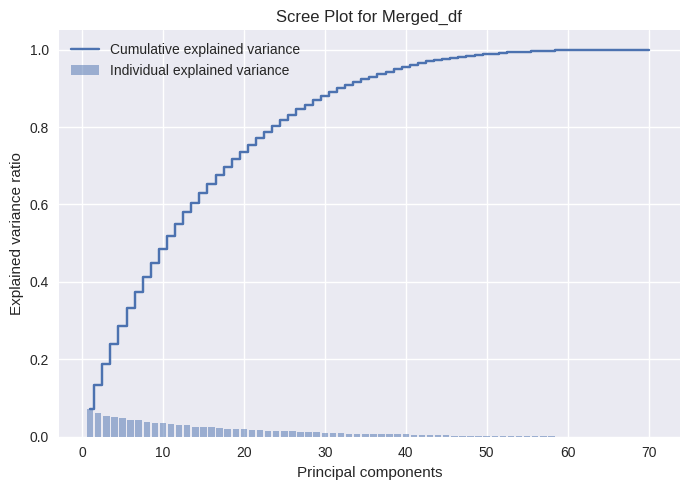

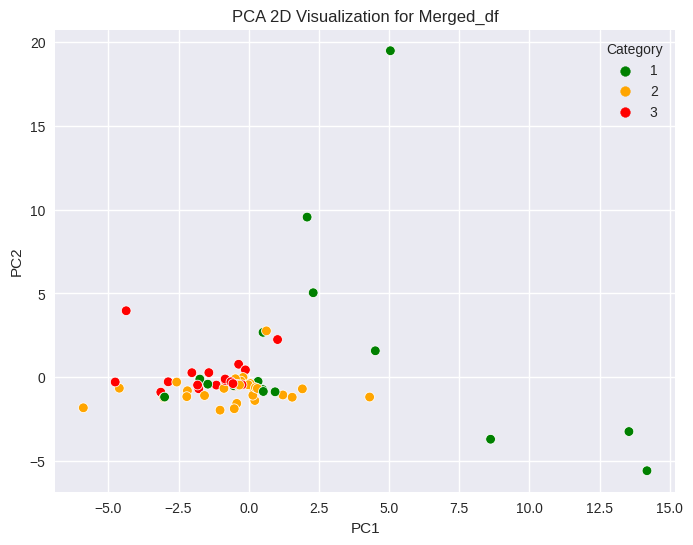

Merged_df_pipeline:


,Features,Influence
77,92,2.5162
120,529,2.4878
26,503,2.4237
90,584,2.4236
108,86,2.4212
109,491,2.3786
135,155,2.3168
52,799,2.2185
41,771,2.2185
118,526,2.1957


Merged_df_pipeline:
Cross-Validation MAE Scores for RF: [0.6725, 0.7564, 0.4773, 0.2891, 0.6055]
Average MAE for RF: 0.5602
Mean Squared Error: 0.2873
Root Mean Squared Error: 0.536
Mean Absolute Error: 0.4121
Feature Importance by RF:     Features  Importance
10       549      0.3477
35       270      0.0540
119      110      0.0465
43       323      0.0457
134      140      0.0434
63       470      0.0421
118      526      0.0420
85        23      0.0288
8        214      0.0256
109      491      0.0226
87       625      0.0197
3        566      0.0142
132      334      0.0135
22       634      0.0125
39       614      0.0123
2        229      0.0112
54       250      0.0112
28       455      0.0110
129      687      0.0108
91       456      0.0099
120      529      0.0092
26       503      0.0086
131      727      0.0084
135      155      0.0083
9         91      0.0083
Merged_df_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.4545, 0.6364, 0.6364, 0.6364]
Average Accuracy: 0.5894
Precision: [0.4826, 0.2273, 0.7121, 0.7121, 0.5455]
Average Precision: 0.5359
Recall: [0.5833, 0.4545, 0.6364, 0.6364, 0.6364]
Average Recall: 0.5894
F1-Score: [0.511, 0.303, 0.6228, 0.6228, 0.5818]
Average F1-Score: 0.5283

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [1 4 2]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.50      0.57      0.53         7
           3       0.33      0.25      0.29         4

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.49      0.50      0.49        14


Feature Importance:
    Features  Importance
10       549      0.0704
119      110      0.0491
109      491      0.0482
118      526      0.0420
43       323      0.0388
..       ...         ...
104  

In [246]:
# Aply pipeline for visual results
results_Merged_df_pca = pca_pipeline(Merged_df, 'Category', n_components=2, dataset_name='Merged_df')

# Apply the pipeline for numerical results
Merged_df_pipeline, df_pca_influence_Merged_df, explained_variance_Merged_df, n_components = apply_pipeline_pca(Merged_df, "Merged_df", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence_Merged_df.head(10), explained_variance_Merged_df.head(10))

# Apply pipeline Regression
Merged_df_pipeline_reg, importances_reg_Merged_df= apply_pipeline_regressor(Merged_df, "Merged_df")
# Apply the pipeline Classification
Merged_df_pipe_class, importances_class_Merged_df = apply_classification_pipeline_classif(Merged_df, "Merged_df")

### Merged_df Discussion:
**Merged_df pipeline Regression**: 
High variance in MAE scores: [0.8136, 0.5479, 0.3764, 0.3979, 0.5936]. Average MAE: 0.5459. This inconsistency suggests unstable model performance
Poor PCA plot and variance explanation could indicate a high dimensionality issues and or a lack of clear separation between classes
**Merged_df pipeline Classification**:
Consistent Cross-Validation Accuracy: 0.9286 (always the same) Suggests potential data leakage or overfitting. Indicates the model might not be truly generalizing
High precision and recall for most classes
Perfect accuracy for Class 1 and Class 2
Slightly lower performance for Class 3

# 8. Preselection Merged_selected and Influencers_uniques_seleceted as a function of Influence and Importance

In [247]:
def extract_top_features(df_pca_influence, importances_reg, importances_class, input_df=None, n_features=10):
    """
    Extract top features using actual pipeline results
    
    Parameters:
    df_pca_influence: PCA influence scores from apply_pipeline_pca
    importances_reg: Feature importance from apply_pipeline_regressor
    importances_class: Feature importance from apply_classification_pipeline_classif
    input_df: Original dataframe for feature selection (optional)
    n_features: Number of top features to select (default=10)
    """
    # Extract scores from actual pipeline results
    pca_scores = pd.Series(df_pca_influence['Influence'].values,
                          index=df_pca_influence['Features'].values.astype(str))
    
    reg_scores = pd.Series(importances_reg['Importance'].values,
                          index=importances_reg['Features'].values.astype(str))
    
    class_scores = pd.Series(importances_class['Importance'].values,
                          index=importances_class['Features'].values.astype(str))
    
    # Normalize scores
    pca_scores_norm = pca_scores / pca_scores.sum()
    reg_scores_norm = reg_scores / reg_scores.sum()
    class_scores_norm = class_scores / class_scores.sum()
    
    # Create comparison DataFrame with pipeline results
    feature_comparison = pd.DataFrame({
        'PCA_Score': pca_scores_norm,
        'Regression_Score': reg_scores_norm,
        'Classification_Score': class_scores_norm
    })
    
    # Ensure index is string type
    feature_comparison.index = feature_comparison.index.astype(str)
    
    # Calculate combined score
    feature_comparison['Combined_Score'] = feature_comparison.mean(axis=1)
    
    # Get top features
    top_features = feature_comparison.nlargest(n_features, 'Combined_Score').index.tolist()
    
    # Create reduced dataset if input_df provided
    reduced_df = None
    if input_df is not None:
        selected_columns = ['Category'] + top_features
        reduced_df = input_df[selected_columns]
    
    return {
        'feature_comparison': feature_comparison,
        'top_features': top_features,
        'reduced_df': reduced_df
    }

## 8.1. Influencers_uniques_selected: Top twenty Influencers_uniques Features 
Calling the function to select features for influence and importance to get the top ten for Influencers_uniques 

In [248]:
# Extract top features and create reduced dataset
results_influencers_uniques = extract_top_features(df_pca_influence_Influencers_uniques , importances_reg_Influencers_uniques ,
                                                    importances_class_Influencers_uniques, Influencers_uniques, n_features=20)

# Access results
feature_comparison_influencers_uniques  = results_influencers_uniques ['feature_comparison']
top_features_influencers_uniques  = results_influencers_uniques ['top_features']
Influencers_uniques_selected = results_influencers_uniques ['reduced_df']

# Print top features if needed
print("\nTop features across all methods:")
print(feature_comparison_influencers_uniques.sort_values('Combined_Score', ascending=False).head(10))
print("\nSelected features:", (top_features_influencers_uniques))


Top features across all methods:
     PCA_Score  Regression_Score  Classification_Score  Combined_Score
549     0.0460            0.5109                0.1340          0.2303
526     0.0522            0.1998                0.1491          0.1337
864     0.0458            0.0651                0.0783          0.0631
863     0.0492            0.0466                0.0784          0.0580
408     0.0452            0.0360                0.0712          0.0508
91      0.0473            0.0209                0.0787          0.0490
351     0.0523            0.0140                0.0505          0.0390
214     0.0379            0.0243                0.0531          0.0384
229     0.0357            0.0248                0.0504          0.0370
23      0.0289            0.0231                0.0356          0.0292

Selected features: ['549', '526', '864', '863', '408', '91', '351', '214', '229', '23', '375', '334', '565', '625', '471', '584', '725', '201', '799', '342']


## 8.2. Results Influencers_uniques_selected:   Pipelines for PCA, Regression and Classification

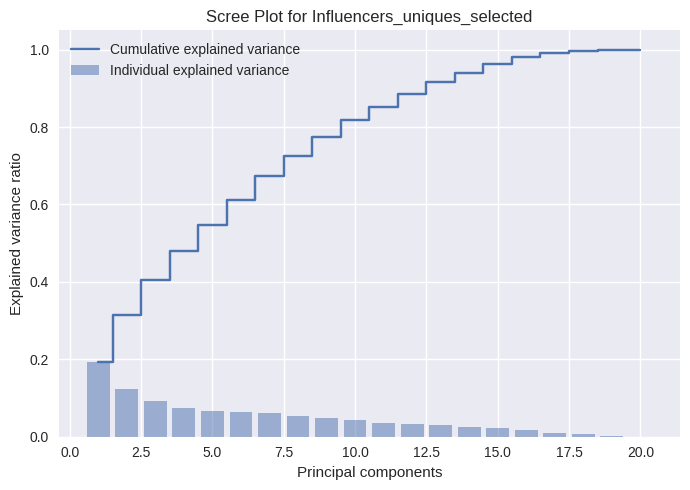

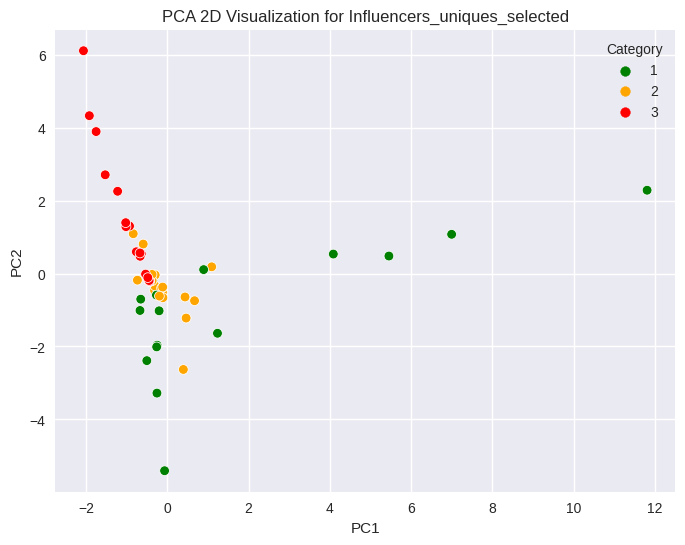

Influencers_uniques_selected_pipeline:


,Features,Influence
6,351,3.0802
1,526,2.6850
15,584,2.5911
13,625,2.4688
18,799,2.3505
3,863,2.3188
14,471,2.3073
4,408,2.2655
11,334,2.2153
19,342,2.1509


Influencers_uniques_selected_pipeline:
Cross-Validation MAE Scores for RF: [0.345, 0.2782, 0.18, 0.1891, 0.17]
Average MAE for RF: 0.2325
Mean Squared Error: 0.1684
Root Mean Squared Error: 0.4103
Mean Absolute Error: 0.2421
Feature Importance by RF:    Features  Importance
0       549      0.4945
1       526      0.1967
2       864      0.0707
3       863      0.0424
4       408      0.0364
5        91      0.0274
8       229      0.0248
7       214      0.0236
13      625      0.0206
9        23      0.0192
6       351      0.0148
11      334      0.0135
10      375      0.0063
12      565      0.0056
14      471      0.0022
15      584      0.0010
18      799      0.0004
16      725      0.0000
17      201      0.0000
19      342      0.0000
Influencers_uniques_selected_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.8182, 0.9091, 0.8182]
Average Accuracy: 0.8576
Precision: [0.881, 0.9242, 0.8701, 0.9242, 0.8182]
Average Precision: 0.8835
Recall: [0.8333, 0.9091, 0.

In [249]:
# Aply pipeline for visual results
results_Influencers_uniques_selected_pca = pca_pipeline(Influencers_uniques_selected, 'Category', n_components=2, dataset_name='Influencers_uniques_selected')

# Apply the pipeline for numerical results
Influencers_uniques_selected_pipeline, df_pca_influence_Influencers_uniques_selected, explained_variance_Influencers_uniques_selected, n_components = apply_pipeline_pca(Influencers_uniques_selected, "Influencers_uniques_selected", n_components=2, n_top_features=20)

# Display the data side by side
display_side_by_side(df_pca_influence_Influencers_uniques_selected.head(10), explained_variance_Influencers_uniques_selected.head(10))

# Apply pipeline Regression
Influencers_uniques_selected_pipeline_reg, importances_reg_Influencers_uniques_selected= apply_pipeline_regressor(Influencers_uniques_selected, "Influencers_uniques_selected")
# Apply the pipeline Classification
Influencers_uniques_selected_pipe_class, importances_class_Influencers_uniques_selected = apply_classification_pipeline_classif(Influencers_uniques_selected, "Influencers_uniques_selected")

## 8.3. Merged_selected: Top ten Merged_df Features
Calling the function to select features for influence and importance to get the top ten for Merged_df

In [250]:
# Extract top features and create reduced dataset
results_Merged = extract_top_features(df_pca_influence_Merged_df, importances_reg_Merged_df, importances_class_Merged_df, Merged_df, n_features=10)

# Access results
feature_comparison = results_Merged ['feature_comparison']
top_features = results_Merged ['top_features']
Merged_selected = results_Merged ['reduced_df']

# Print top features if needed
print("\nTop features across all methods:")
print(feature_comparison.sort_values('Combined_Score', ascending=False).head(10))
print("\nSelected features:", (top_features))


Top features across all methods:
     PCA_Score  Regression_Score  Classification_Score  Combined_Score
549     0.0047            0.3477                0.0704          0.1409
110     0.0088            0.0465                0.0491          0.0348
526     0.0092            0.0420                0.0420          0.0311
323     0.0069            0.0457                0.0388          0.0305
270     0.0061            0.0540                0.0262          0.0288
491     0.0099            0.0226                0.0482          0.0269
140     0.0067            0.0434                0.0296          0.0266
470     0.0078            0.0421                0.0240          0.0246
214     0.0069            0.0256                0.0244          0.0190
23      0.0035            0.0288                0.0242          0.0188

Selected features: ['549', '110', '526', '323', '270', '491', '140', '470', '214', '23']


## 8.4. Results Merged_selected:  Pipelines for PCA, Regression and Classification

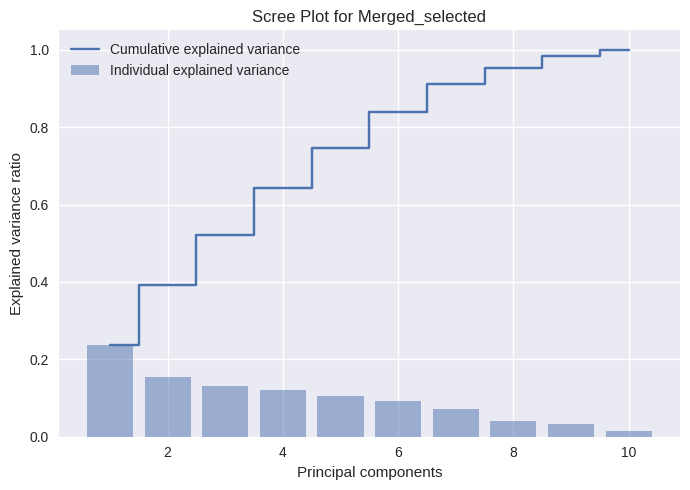

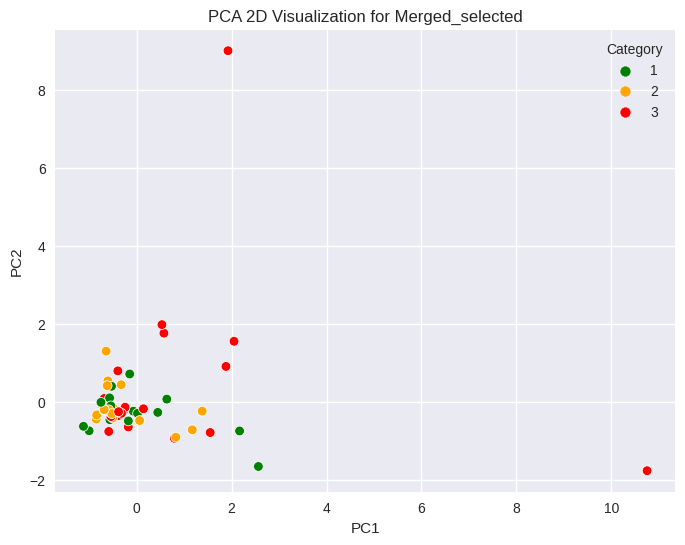

Merged_selected_pipeline:


,Features,Influence
4,270,2.2775
1,110,2.1608
0,549,2.1587
9,23,2.0236
7,470,1.9343
2,526,1.7681
5,491,1.7149
6,140,1.6645
8,214,1.5795
3,323,1.5277


Merged_selected_pipeline:
Cross-Validation MAE Scores for RF: [0.6583, 0.7973, 0.4, 0.2527, 0.5209]
Average MAE for RF: 0.5258
Mean Squared Error: 0.2837
Root Mean Squared Error: 0.5326
Mean Absolute Error: 0.3929
Feature Importance by RF:   Features  Importance
0      549      0.3960
4      270      0.1137
1      110      0.0818
2      526      0.0758
3      323      0.0709
6      140      0.0698
7      470      0.0690
9       23      0.0486
5      491      0.0401
8      214      0.0342
Merged_selected_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.6667, 0.3636, 0.9091, 0.7273, 0.7273]
Average Accuracy: 0.6788
Precision: [0.6667, 0.202, 0.9242, 0.7727, 0.7636]
Average Precision: 0.6658
Recall: [0.6667, 0.3636, 0.9091, 0.7273, 0.7273]
Average Recall: 0.6788
F1-Score: [0.6667, 0.2597, 0.9041, 0.7377, 0.7273]
Average F1-Score: 0.6591

Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [0 4 3]
 [0 3 1]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.50      0.57      0.53         7
           3       0.25      0.25      0.25         4

    accuracy                           0.50        14
   macro avg       0.58      0.50      0.53        14
weighted avg       0.54      0.50      0.51        14


Feature Importance:
  Features  Importance
0      549      0.2072
2      526      0.1166
3      323      0.1134
1      110      0.1076
5      491      0.0861
9       23      0.0819
4      270      0.

In [251]:
# Aply pipeline for visual results
Merged_selected_pca = pca_pipeline(Merged_selected, 'Category', n_components=2, dataset_name='Merged_selected')

# Apply the pipeline for numerical results
Merged_selected_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(Merged_selected,
                                                         "Merged_selected", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
Merged_selected_pipeline_reg, importances_reg= apply_pipeline_regressor(Merged_selected, "Merged_selected")
# Apply the pipeline Classification
Merged_selected_pipe_class, importances_class = apply_classification_pipeline_classif(Merged_selected, "Merged_selected")

Actually 30 features performs worse than 20 features for Merged_selected. 
30 features:    MAE: 0.5157, Accuracy: 0.6606,,Average Precision: 0.5875

20 features:    MAE: 0.512 (better), Accuracy: 0.7152 (much better), Average Precision: 0.7075 (much better)

10 features:    MAE: 0.5193 (similar), Accuracy: 0.75 (better), Average Precision: 0.7859 (better), MSE: 0.2926 (better)

# 9. Manually prunning the features according to importance and influence

## 9.1. old_new dataframes creation
From manually prunned features according to importance and influence results

In [252]:
# Get your top 10 features
top_10_features_1 = ["625", "214","408","229","351","354","565","606","334","584","583","621","581","497","512"]
top_10_features_2 = ["154", "201", "214","229", "334", "351", "354", "408", "497", "512", "565", "581", "583", "584", "606", "621", "625"]

# Create final reduced dataset
selected_columns1 = ['Category'] + top_10_features_1
selected_columns2 = ['Category'] + top_10_features_2

old_new_1 = original[selected_columns1]
old_new_2 = original[selected_columns2]

## 9.2. old_new1 Results:  Pipelines for PCA, Regression and Classification

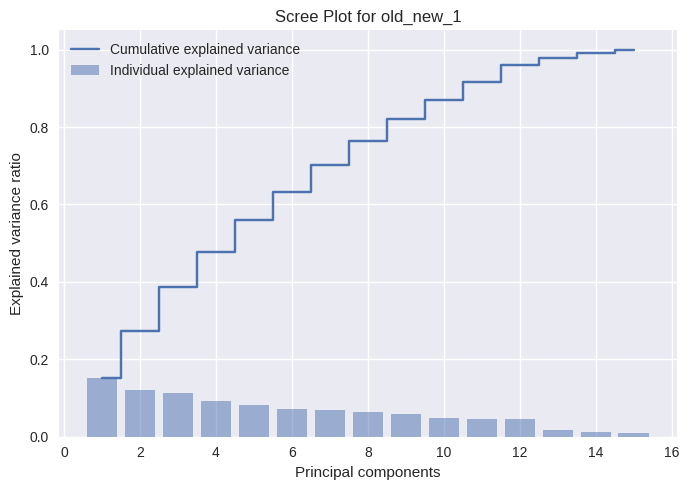

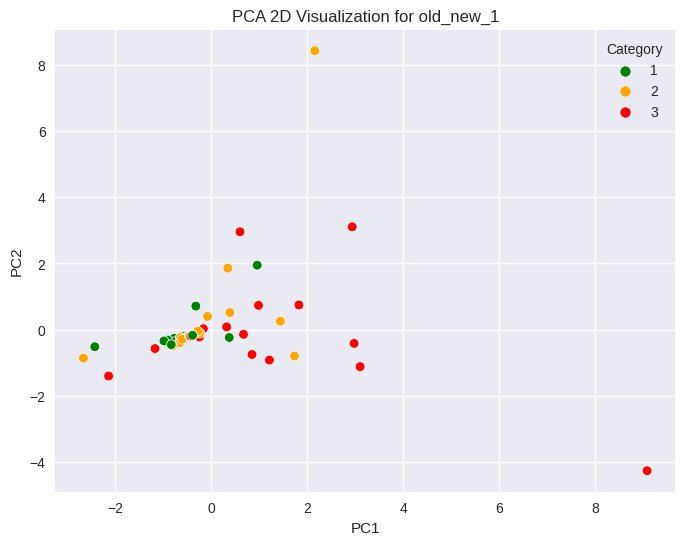

old_new_1_pipeline:


,Features,Influence
7,606,2.7546
2,408,2.6871
0,625,2.5423
10,583,2.4997
6,565,2.4665
9,584,2.4369
11,621,2.3778
8,334,2.3116
3,229,2.2898
5,354,2.0881


old_new_1_pipeline:
Cross-Validation MAE Scores for RF: [0.6883, 0.6404, 0.5838, 0.4076, 0.4569]
Average MAE for RF: 0.5554
Mean Squared Error: 0.2979
Root Mean Squared Error: 0.5458
Mean Absolute Error: 0.44
Feature Importance by RF:    Features  Importance
1       214      0.1518
5       354      0.1400
3       229      0.1090
6       565      0.1026
4       351      0.0964
2       408      0.0864
8       334      0.0740
0       625      0.0726
10      583      0.0538
7       606      0.0428
12      581      0.0240
9       584      0.0200
11      621      0.0138
13      497      0.0067
14      512      0.0062
old_new_1_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.6364, 0.5455, 0.5455, 0.8182]
Average Accuracy: 0.6258
Precision: [0.5833, 0.798, 0.3961, 0.3961, 0.8667]
Average Precision: 0.608
Recall: [0.5833, 0.6364, 0.5455, 0.5455, 0.8182]
Average Recall: 0.6258
F1-Score: [0.5768, 0.5974, 0.4589, 0.4589, 0.8096]
Average F1-Score: 0.5803

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [1 4 2]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.50      0.57      0.53         7
           3       0.50      0.50      0.50         4

    accuracy                           0.50        14
   macro avg       0.50      0.47      0.48        14
weighted avg       0.50      0.50      0.50        14


Feature Importance:
   Features  Importance
1       214      0.1198
4       351      0.1111
6       565      0.1094
3       229      0.0970
5       354      0.0898
0       625      0.0822
8       334 

In [253]:
# Aply pipeline for visual results
old_new_1_pca = pca_pipeline(old_new_1, 'Category', n_components=2, dataset_name='old_new_1')

# Apply the pipeline for numerical results
old_new_1_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(old_new_1, "old_new_1", n_components=2, n_top_features=None)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
old_new_1_pipeline_reg, importances_reg= apply_pipeline_regressor(old_new_1, "old_new_1")
# Apply the pipeline Classification
old_new_1_pipe_class, importances_class = apply_classification_pipeline_classif(old_new_1, "old_new_1")

## 9.3. old_new2 Results:  Pipelines for PCA, Regression and Classification

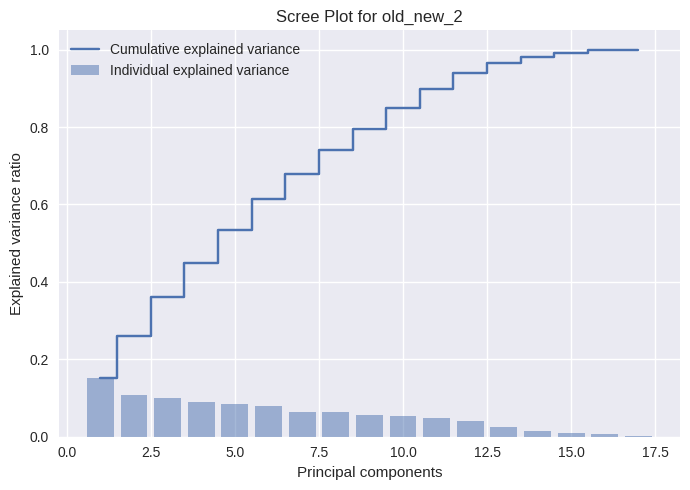

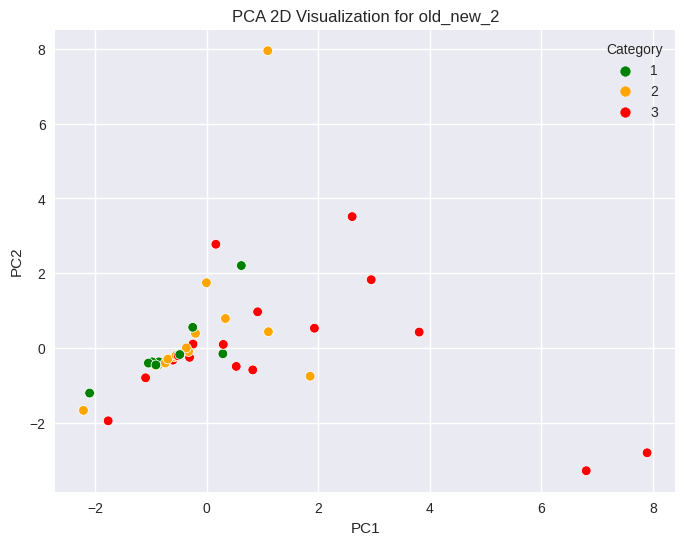

old_new_2_pipeline:


,Features,Influence
13,584,2.5270
16,625,2.4198
15,621,2.2962
4,334,2.1737
14,606,2.1490
12,583,2.0759
10,565,2.0540
1,201,1.9087
6,354,1.9083
5,351,1.7533


old_new_2_pipeline:
Cross-Validation MAE Scores for RF: [0.6808, 0.6367, 0.5658, 0.4059, 0.4425]
Average MAE for RF: 0.5463
Mean Squared Error: 0.3187
Root Mean Squared Error: 0.5645
Mean Absolute Error: 0.4627
Feature Importance by RF:    Features  Importance
2       214      0.1541
6       354      0.1425
3       229      0.1033
5       351      0.1012
10      565      0.0974
7       408      0.0843
4       334      0.0755
16      625      0.0739
12      583      0.0488
14      606      0.0429
13      584      0.0211
11      581      0.0180
15      621      0.0136
0       154      0.0130
9       512      0.0059
8       497      0.0041
1       201      0.0002
old_new_2_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Cross-Validation Metrics:
Accuracy: [0.5833, 0.6364, 0.6364, 0.5455, 0.8182]
Average Accuracy: 0.644
Precision: [0.5833, 0.798, 0.4659, 0.3961, 0.8667]
Average Precision: 0.622
Recall: [0.5833, 0.6364, 0.6364, 0.5455, 0.8182]
Average Recall: 0.644
F1-Score: [0.5768, 0.5974, 0.5315, 0.4589, 0.8096]
Average F1-Score: 0.5948

Test Set Evaluation:
Confusion Matrix:
[[1 2 0]
 [1 5 1]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.33      0.40         3
           2       0.56      0.71      0.63         7
           3       0.67      0.50      0.57         4

    accuracy                           0.57        14
   macro avg       0.57      0.52      0.53        14
weighted avg       0.58      0.57      0.56        14


Feature Importance:
   Features  Importance
2       214      0.1125
10      565      0.1115
5       351      0.1068
3       229      0.0970
6       354      0.0948
7       408      0.0826
16      625   

In [254]:
# Aply pipeline for visual results
old_new_2_pca = pca_pipeline(old_new_2, 'Category', n_components=2, dataset_name='old_new_2')

# Apply the pipeline for numerical results
old_new_2_pipeline, df_pca_influence, explained_variance, n_components = apply_pipeline_pca(old_new_2, "old_new_2", n_components=2, n_top_features=10)

# Display the data side by side
display_side_by_side(df_pca_influence.head(10), explained_variance.head(10))

# Apply pipeline Regression
old_new_2_pipeline_reg, importances_reg= apply_pipeline_regressor(old_new_2, "old_new_2")
# Apply the pipeline Classification
old_new_2_pipe_class, importances_class = apply_classification_pipeline_classif(old_new_2, "old_new_2")


# 10.  Cluster Analysis
## 10.1.  script - Pipeline K-Means, DBSCAN, and GMM 

In [255]:
def clustering_pipeline_all(df, pca_data_name='pca_data', n_clusters=5, eps=0.5, min_samples=5, n_components=2):
    """
    Performs clustering using K-Means, DBSCAN, and GMM with PCA for dimensionality reduction.
    
    Parameters:
    - df: Input DataFrame (features only, no labels).
    - n_clusters: Number of clusters for K-Means and GMM (default=5).
    - eps: DBSCAN's epsilon parameter (default=0.5).
    - min_samples: Minimum samples for DBSCAN (default=5).
    - n_components: Number of components for PCA (default=2).
    
    Returns:
    - results: Dictionary with clustering results for K-Means, DBSCAN, and GMM, as well as PCA data and metrics.
    """
    results = {}
    # Ensuring feature names are preserved
    original_columns = df.columns
    df = df.copy()  # avoid modifications to original

    # Separate true labels
    true_labels = df['Category']

    df = df.drop(columns=['Category'])  # Drop any non-numeric columns

    # Step 1: Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Step 2: PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)

    # Calculate explained variance and cumulative variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    # Clustering
    results = {
        'pca': pca,
        'pca_data_name': pca_data,
        'scaled_data': scaled_data,
        'explained_variance': explained_variance_ratio,
        'cumulative_variance': cumulative_variance_ratio
    }

    # Step 3: K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    kmeans_silhouette = silhouette_score(pca_data, kmeans_labels)
    kmeans_db_score = davies_bouldin_score(pca_data, kmeans_labels)
    kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)

    results['kmeans'] = {
        'cluster_labels': kmeans_labels,
        'silhouette_score': kmeans_silhouette,
        'davies_bouldin_score': kmeans_db_score,
        'adjusted_rand_score': kmeans_ari
    }
    
    # Step 4: DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Add automatic eps calculation if not provided
    if eps is None:
        nbrs = NearestNeighbors(n_neighbors=2).fit(scaled_data)
        distances, _ = nbrs.kneighbors(scaled_data)
        eps = np.percentile(distances[:, 1], 90)

    dbscan_labels = dbscan.fit_predict(pca_data)
    valid_indices = dbscan_labels != -1
    if len(set(dbscan_labels[valid_indices])) > 1:
        dbscan_silhouette = silhouette_score(pca_data[valid_indices], dbscan_labels[valid_indices])
        dbscan_db_score = davies_bouldin_score(pca_data[valid_indices], dbscan_labels[valid_indices])
    else:
        dbscan_silhouette = None
        dbscan_db_score = None
    dbscan_ari = adjusted_rand_score(true_labels, dbscan_labels)


    results['dbscan'] = {
        'cluster_labels': dbscan_labels,
        'silhouette_score': dbscan_silhouette,
        'davies_bouldin_score': dbscan_db_score,
        'adjusted_rand_score': dbscan_ari
    }
    
    # Step 5: GMM Clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pca_data)
    gmm_silhouette = silhouette_score(pca_data, gmm_labels)
    gmm_db_score = davies_bouldin_score(pca_data, gmm_labels)
    gmm_ari = adjusted_rand_score(true_labels, gmm_labels)
    
    results['gmm'] = {
        'cluster_labels': gmm_labels,
        'silhouette_score': gmm_silhouette,
        'davies_bouldin_score': gmm_db_score,
        'adjusted_rand_score': gmm_ari,
        'bic_score': gmm.bic(pca_data),
        'aic_score': gmm.aic(pca_data)
    }

    # Addind normalized metrics
    for method in ['kmeans', 'dbscan', 'gmm']:
        labels = results[method]['cluster_labels']
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            sizes = np.bincount(valid_labels)
        else:
            sizes = np.bincount(labels)
        results[method]['normalized_sizes'] = sizes / len(labels)

    # Store PCA-transformed data with the specified name
    results[pca_data_name] = pca_data
    
    return results

## 10.2. Script - Visualisation K-means, DBSCAN AND GaussianMixture

In [256]:
def visualize_clustering_results(results, title_prefix=''):
    """
    Visualize clustering results with multiple plots and metrics
    
    Parameters:
    - results: Dictionary containing clustering results from clustering_pipeline_all function
    - title_prefix: Optional prefix for plot titles
    """
    # Extract PCA data
    pca_data = results[list(filter(lambda x: x.startswith('pca_'), results.keys()))[0]]
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'{title_prefix} Clustering Results Visualization', fontsize=16)

    # plot style settings for better visibility
    plt.style.use('seaborn')
    
    # Color palettes for different clustering methods
    color_palettes =color_palettes = [
        # For K-means (5 distinct colors)
        ['#800080', '#FFA500', '#0000FF', '#00FF00', '#FF0000'],  # Red, Green, Blue, Orange, Purple
        # For GMM (same as kmeans)
        ['#800080', '#FFA500', '#0000FF', '#00FF00', '#FF0000'],
        # For DBSCAN (2 colors - noise and cluster)
        ['#808080', '#0000FF']  # Grey, Blue

    ]

    # Add grid for better readability
    for ax in axs.flat:
        ax.grid(True, alpha=0.3)
    
    # Clustering methods and their labels
    clustering_methods = [
        ('K-Means', results['kmeans']['cluster_labels'], color_palettes[0]),
        ('Gaussian Mixture Model', results['gmm']['cluster_labels'], color_palettes[2]),
        ('DBSCAN', results['dbscan']['cluster_labels'], color_palettes[1])
    ]
    
    # Scatter plots for each clustering method
    for idx, (method_name, labels, color_palette) in enumerate(clustering_methods):
        row = idx // 2
        col = idx % 2
        
        # Handle DBSCAN noise points
        if method_name == 'DBSCAN':
            noise_mask = labels == -1
            cluster_mask = labels != -1
            
            # Plot noise points
            if np.any(noise_mask):
                axs[row, col].scatter(
                    pca_data[noise_mask, 0], 
                    pca_data[noise_mask, 1], 
                    c='gray', 
                    alpha=0.5, 
                    label='Noise'
                )
            
            # Plot clustered points
            unique_labels = np.unique(labels[cluster_mask])
            for label in unique_labels:
                mask = (labels == label) & cluster_mask
                axs[row, col].scatter(
                    pca_data[mask, 0], 
                    pca_data[mask, 1], 
                    c=[color_palette[label]], 
                    label=f'Cluster {label}'
                )
        else:
            # For K-Means and GMM
            unique_labels = np.unique(labels)
            for label in unique_labels:
                mask = labels == label
                axs[row, col].scatter(
                    pca_data[mask, 0], 
                    pca_data[mask, 1], 
                    c=[color_palette[label % len(color_palette)]],
                    label=f'Cluster {label}'
                )
        
        axs[row, col].set_title(f'{method_name} Clustering')
        axs[row, col].set_xlabel('First Principal Component')
        axs[row, col].set_ylabel('Second Principal Component')
        axs[row, col].legend()
    
    plt.tight_layout()
    plt.show()

def print_clustering_metrics(results):
    """
    Print detailed clustering metrics for each method
    
    Parameters:
    - results: Dictionary containing clustering results
    """
    print("\n=== Clustering Metrics ===")
    
    # Cluster quality metrics
    def calculate_cluster_quality(labels, data):
        if len(set(labels)) <= 1:
            return None
        # Calculate average intra-cluster distance
        intra_cluster_distances = []
        for label in set(labels):
            if label != -1:  # Skip noise points
                cluster_points = data[labels == label]
                if len(cluster_points) > 1:
                    distances = pdist(cluster_points)
                    intra_cluster_distances.append(np.mean(distances))
        return np.mean(intra_cluster_distances) if intra_cluster_distances else None
    
    # Metrics for each clustering method
    clustering_methods = ['kmeans', 'dbscan', 'gmm']
    
    for method in clustering_methods:
        print(f"\n{method.upper()} Clustering Metrics:")
        labels = results[method]['cluster_labels']
        silhouette = results[method]['silhouette_score']
        db_score = results[method]['davies_bouldin_score']
        ari = results[method].get('adjusted_rand_score', 'N/A')  # Use 'N/A' if ARI is not available
        quality = calculate_cluster_quality(labels, results['scaled_data'])

        if quality is not None:
            print(f"Average Intra-cluster Distance: {quality:.4f}")
        else:
            print("Average Intra-cluster Distance: N/A")
        print(f"Silhouette Score: {silhouette if silhouette is not None else 'Not applicable'}")
        print(f"Davies-Bouldin Score: {db_score if db_score is not None else 'Not applicable'}")
        print(f"Adjusted Rand Score: {ari}")
        
        # Count cluster sizes
        if method == 'dbscan':
            valid_labels = labels[labels != -1]
            unique_labels = np.unique(valid_labels)
        else:
            unique_labels = np.unique(labels)
        
        print("\nCluster Sizes:")
        for label in unique_labels:
            if method == 'dbscan' and label == -1:
                count = np.sum(labels == label)
                print(f"Noise Points: {count}")
            else:
                count = np.sum(labels == label)
                print(f"Cluster {label}: {count} points")

    
    # Print Explained Variance for PCA
    print("\nPCA Explained Variance Ratio:")
    explained_variance = results['explained_variance']
    for i, var in enumerate(explained_variance[:10], 1):
        print(f"PC{i}: {var * 100:.2f}%")
    print(f"Total Variance Explained (first 10 PCs): {np.sum(explained_variance[:10]) * 100:.2f}%")

# 11. Results Cluster Analysis


## 11.1 Clustering original_pca

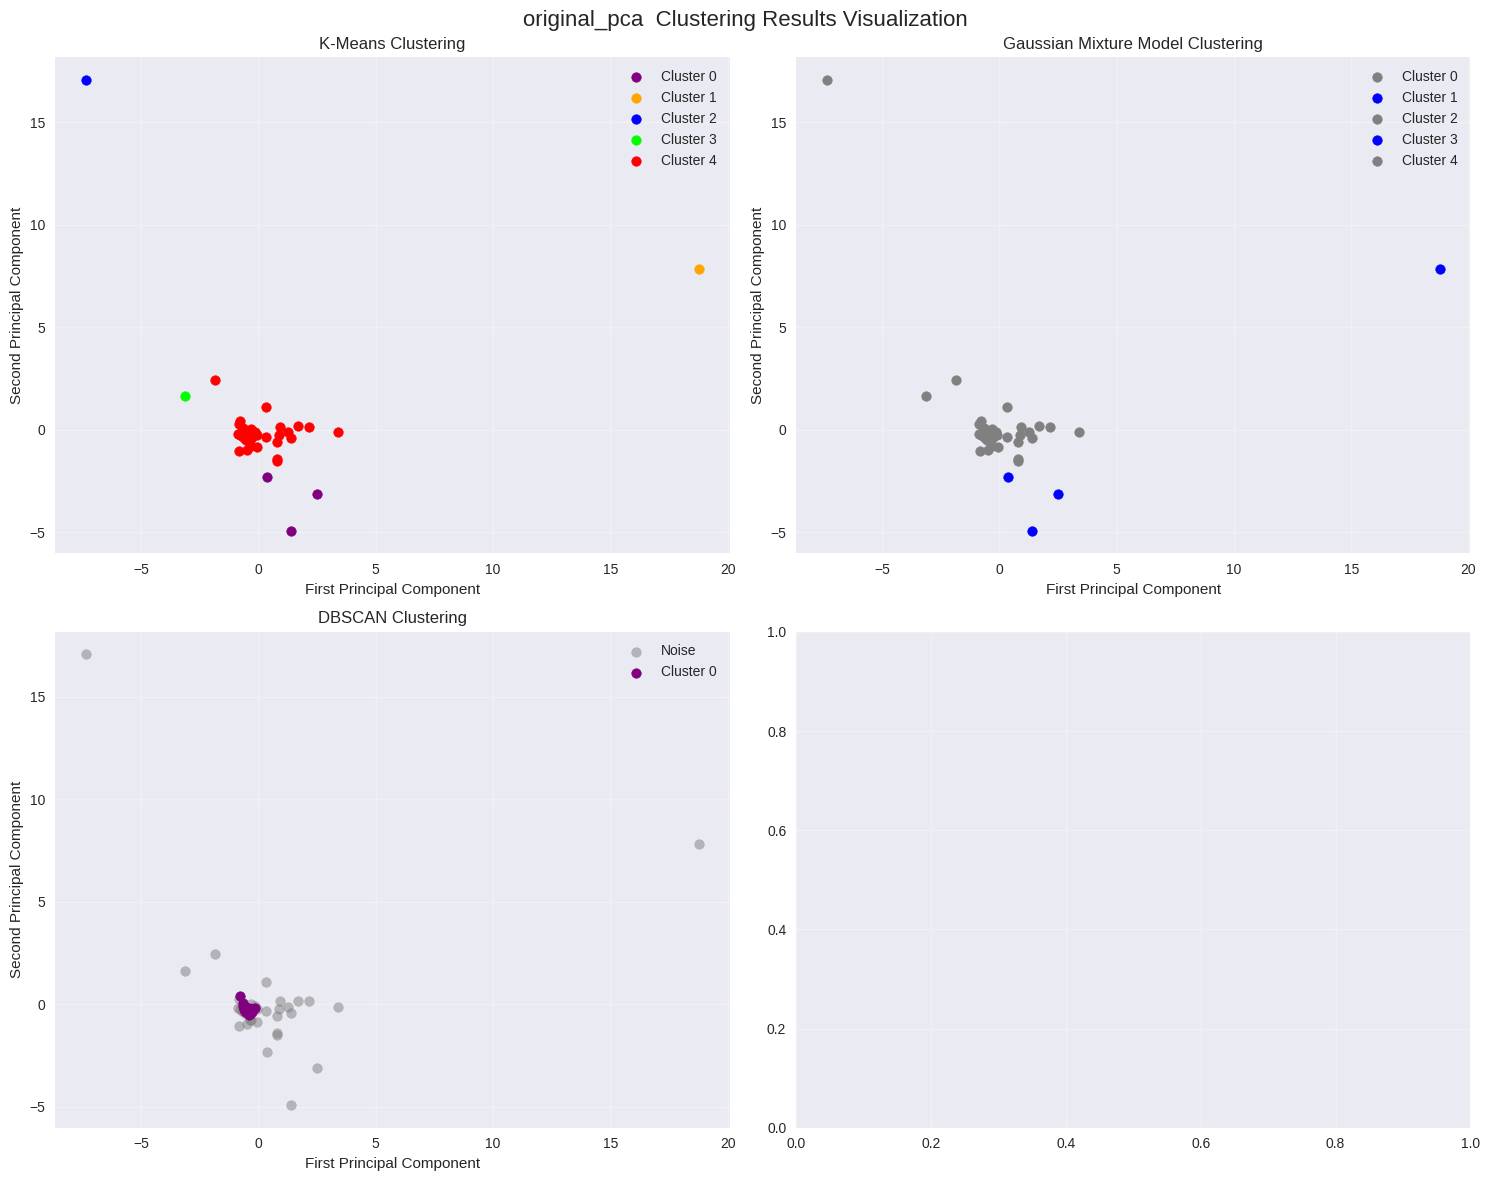


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 11.8819
Silhouette Score: 0.709846411711427
Davies-Bouldin Score: 0.35817111630926607
Adjusted Rand Score: -0.00816568684693526

Cluster Sizes:
Cluster 0: 3 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 64 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.5259
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.05673160381907609

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 10.5923
Silhouette Score: 0.19942185250405167
Davies-Bouldin Score: 1.143204243603245
Adjusted Rand Score: 0.009408718983640516

Cluster Sizes:
Cluster 0: 22 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 3 points
Cluster 4: 43 points

PCA Explained Variance Ratio:
PC1: 13.40%
PC2: 11.84%
PC3: 10.09%
PC4: 9.15%
PC5: 8.10%
Total Variance Explained (first 10 PCs): 52.57%


In [257]:
# Running pipeline 
results_original_pca_cluster  = clustering_pipeline_all(original_pca,  pca_data_name='pca_data_original_pca ', 
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_original_pca_cluster, title_prefix='original_pca ')
print_clustering_metrics(results_original_pca_cluster )

### original_pca Discussion 

## 11.2 Clustering uniques_pca

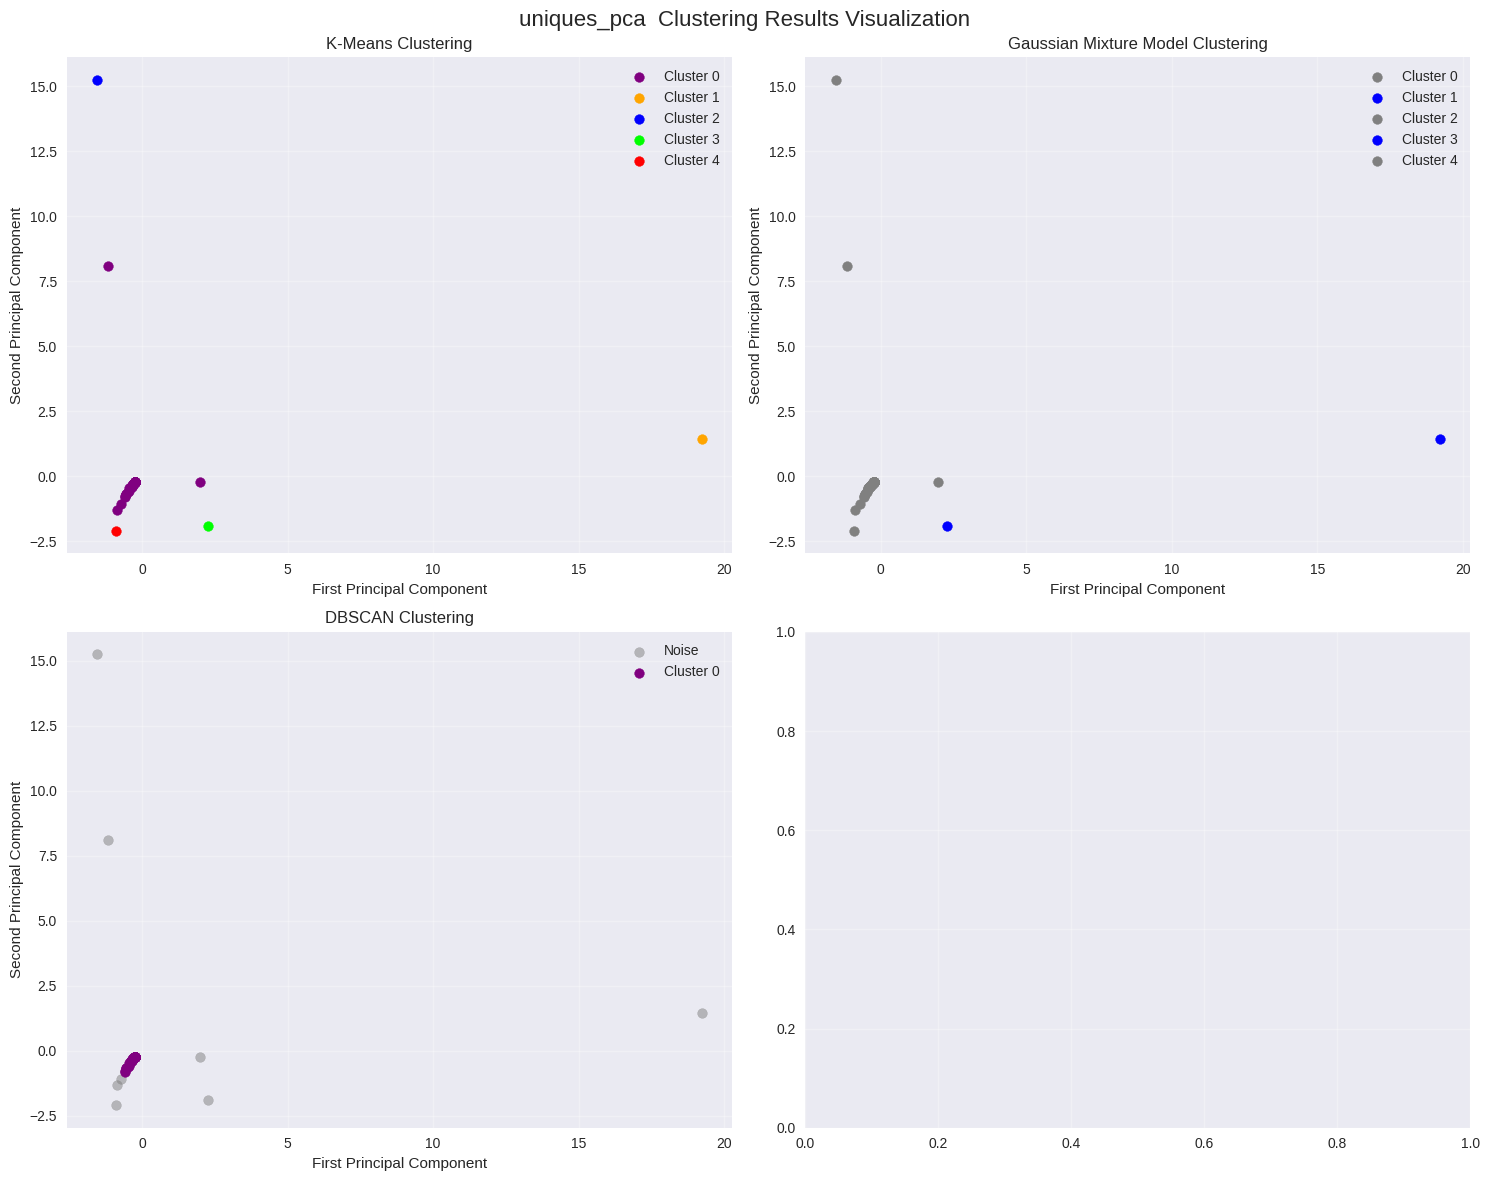


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 5.7367
Silhouette Score: 0.8910951199749814
Davies-Bouldin Score: 0.03643311930092844
Adjusted Rand Score: 0.0028655323934276018

Cluster Sizes:
Cluster 0: 66 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 4.4601
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.02759577992603921

Cluster Sizes:
Cluster 0: 61 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 5.7538
Silhouette Score: 0.8877653331812957
Davies-Bouldin Score: 0.04036789674085742
Adjusted Rand Score: 0.0028655323934276018

Cluster Sizes:
Cluster 0: 66 points
Cluster 1: 1 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 11.16%
PC2: 9.06%
PC3: 8.22%
PC4: 8.01%
PC5: 7.04%
Total Variance Explained (first 10 PCs): 43.49%


In [258]:
# Running pipeline 
results_uniques_pca_cluster  = clustering_pipeline_all(uniques_pca,  pca_data_name='pca_data_original_pca ', 
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_uniques_pca_cluster, title_prefix='uniques_pca ')
print_clustering_metrics(results_uniques_pca_cluster )

### Discussing uniques_pca

## 11.3 Clustering uniques23_OLS

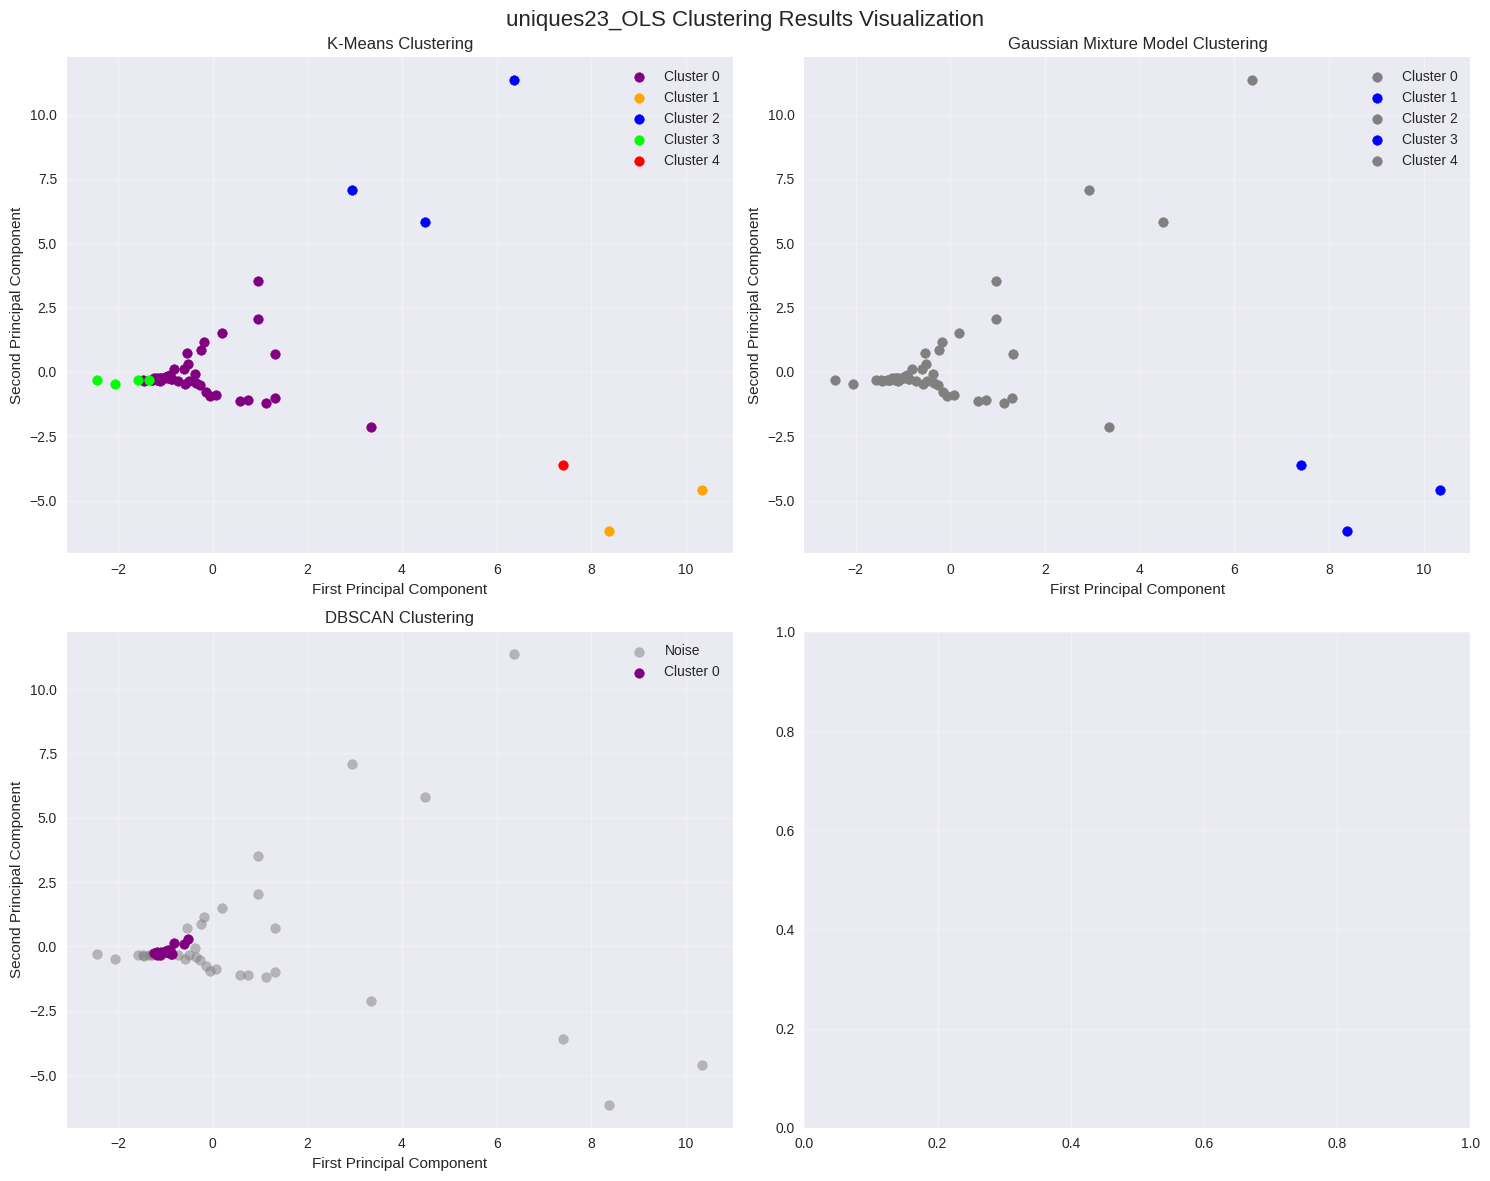


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.3355
Silhouette Score: 0.598785254585151
Davies-Bouldin Score: 0.4904376372546061
Adjusted Rand Score: 0.11065461928081545

Cluster Sizes:
Cluster 0: 60 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 4 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.3099
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.07276938318232015

Cluster Sizes:
Cluster 0: 34 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.4063
Silhouette Score: 0.27947514332460477
Davies-Bouldin Score: 0.8839006839114465
Adjusted Rand Score: 0.09745136262032149

Cluster Sizes:
Cluster 0: 49 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 15 points

PCA Explained Variance Ratio:
PC1: 19.95%
PC2: 17.05%
PC3: 10.29%
PC4: 7.96%
PC5: 6.53%
Total Variance Explained (first 10 PCs): 61.77%


In [259]:
# Running pipeline 
results_uniques23_OLS_cluster  = clustering_pipeline_all(uniques23_OLS,  pca_data_name='pca_data_uniques23_OLS ', 
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_uniques23_OLS_cluster, title_prefix='uniques23_OLS')
print_clustering_metrics(results_uniques23_OLS_cluster )

### Discussing  uniques23_OLS (300+ features):
K-means: Silhouette Score of 0.685, Davies-Bouldin of 0.514
Cluster sizes are quite imbalanced (53, 3, 3, 5, 6 points)
PCA explains 37% of variance (19.95% PC1, 17.05% PC2)

## 11.4 Clustering Influencers_OLS

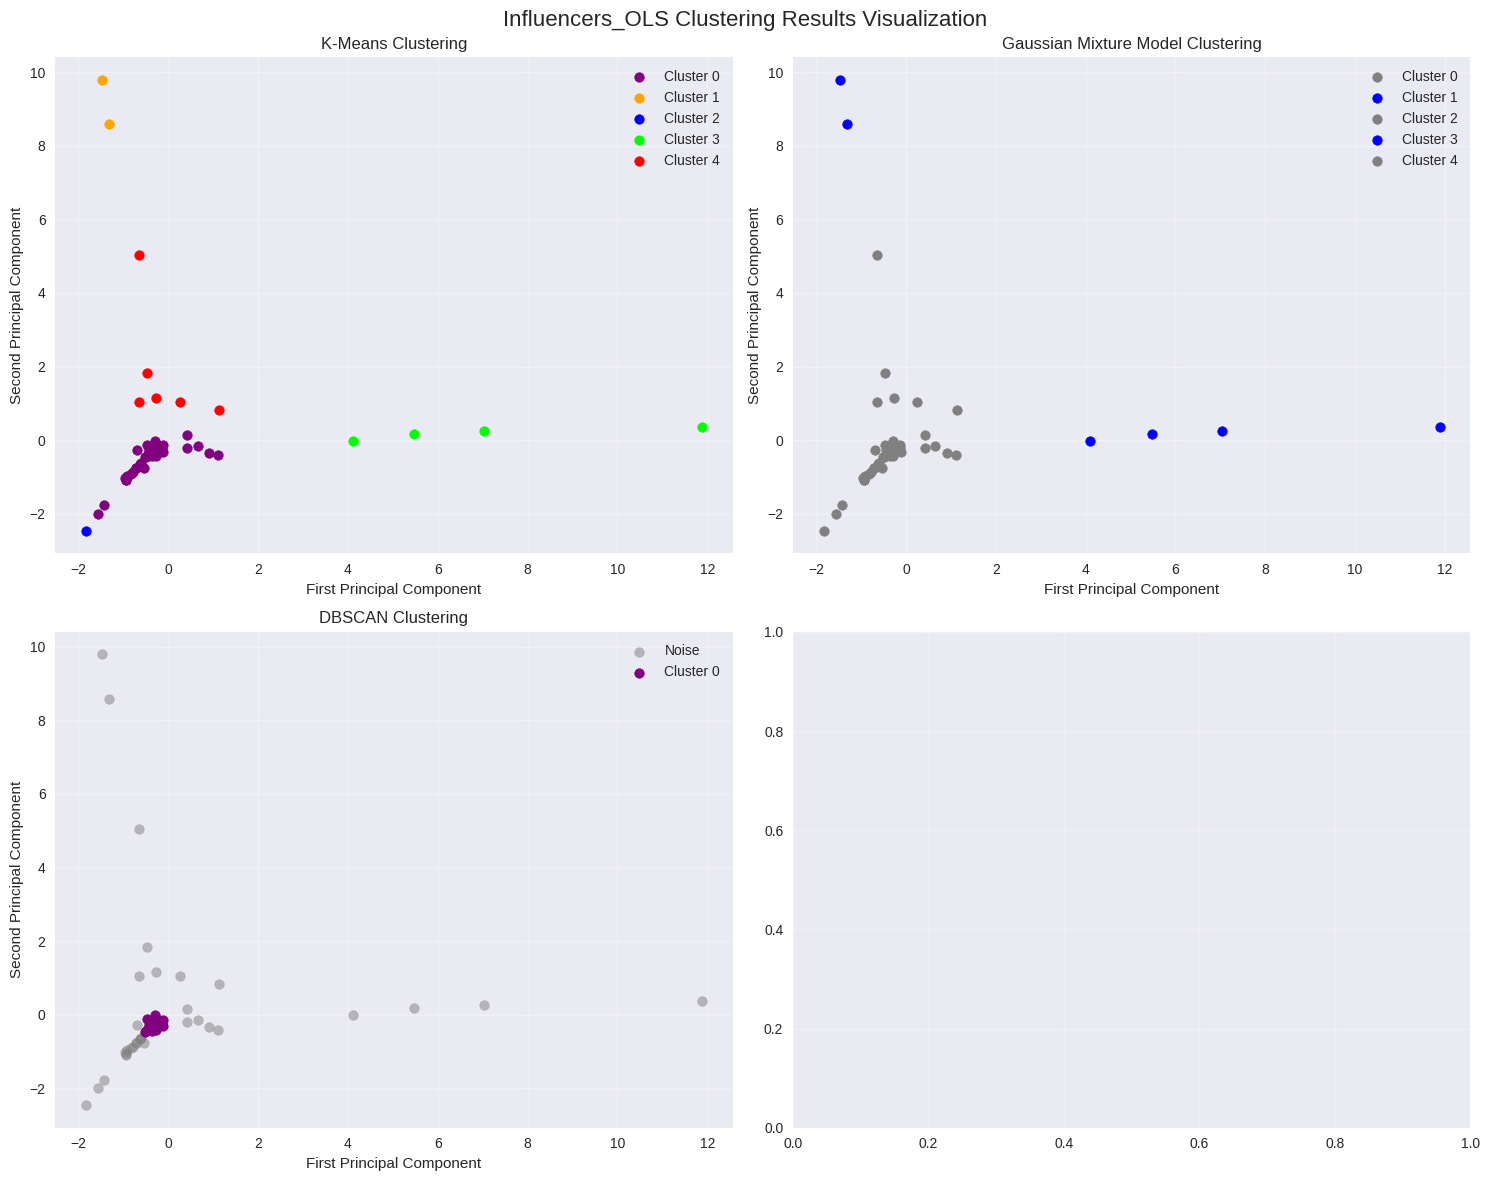


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 5.6651
Silhouette Score: 0.648375314612715
Davies-Bouldin Score: 0.5160419399380063
Adjusted Rand Score: 0.18453461053893616

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 6 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.7151
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.1158484972356072

Cluster Sizes:
Cluster 0: 37 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 5.6651
Silhouette Score: 0.648375314612715
Davies-Bouldin Score: 0.5160419399380063
Adjusted Rand Score: 0.18453461053893616

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 2 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 6 points

PCA Explained Variance Ratio:
PC1: 19.12%
PC2: 16.41%
PC3: 10.92%
PC4: 9.15%
PC5: 6.73%
Total Variance Explained (first 10 PCs): 62.33%


In [260]:
# Running pipeline 
results_Influencers_OLS_cluster = clustering_pipeline_all(Influencers_OLS,  pca_data_name='pca_data_Influencers_OLS_cluster', 
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_Influencers_OLS_cluster, title_prefix='Influencers_OLS')
print_clustering_metrics(results_Influencers_OLS_cluster)

### Clustering Influencers_OLS, Discussion 
Influencers_OLS:
K-means: Silhouette Score of 0.603, Davies-Bouldin of 0.552
Very imbalanced cluster sizes (1, 53, 3, 3, 10 points)
PCA explains 35.53% of variance

Notice that for PCA visualisation on notebook PCA_RF_FImporance.ipnyb, the same dataset was used, hower the main difference is that there the category label was use to color code the samples, however category was droped and didnt participate on the clustering, it was used just for color coding.
Plots show similar behaviour because the clustering algorithms (K-Means, DBSCAN, GMM) are able to identify the inherent structure in the data and recover groupings that are consistent with the original category information, even though the category column is not provided. it means the clustering methods are effectively capturing the underlying patterns in the data, regardless of whether the category information is explicitly given or not. The consistency between the PCA visualization and the clustering results indicates the data has a clear structure that the algorithms can latch onto.
## 11.5 Clustering OLS_all

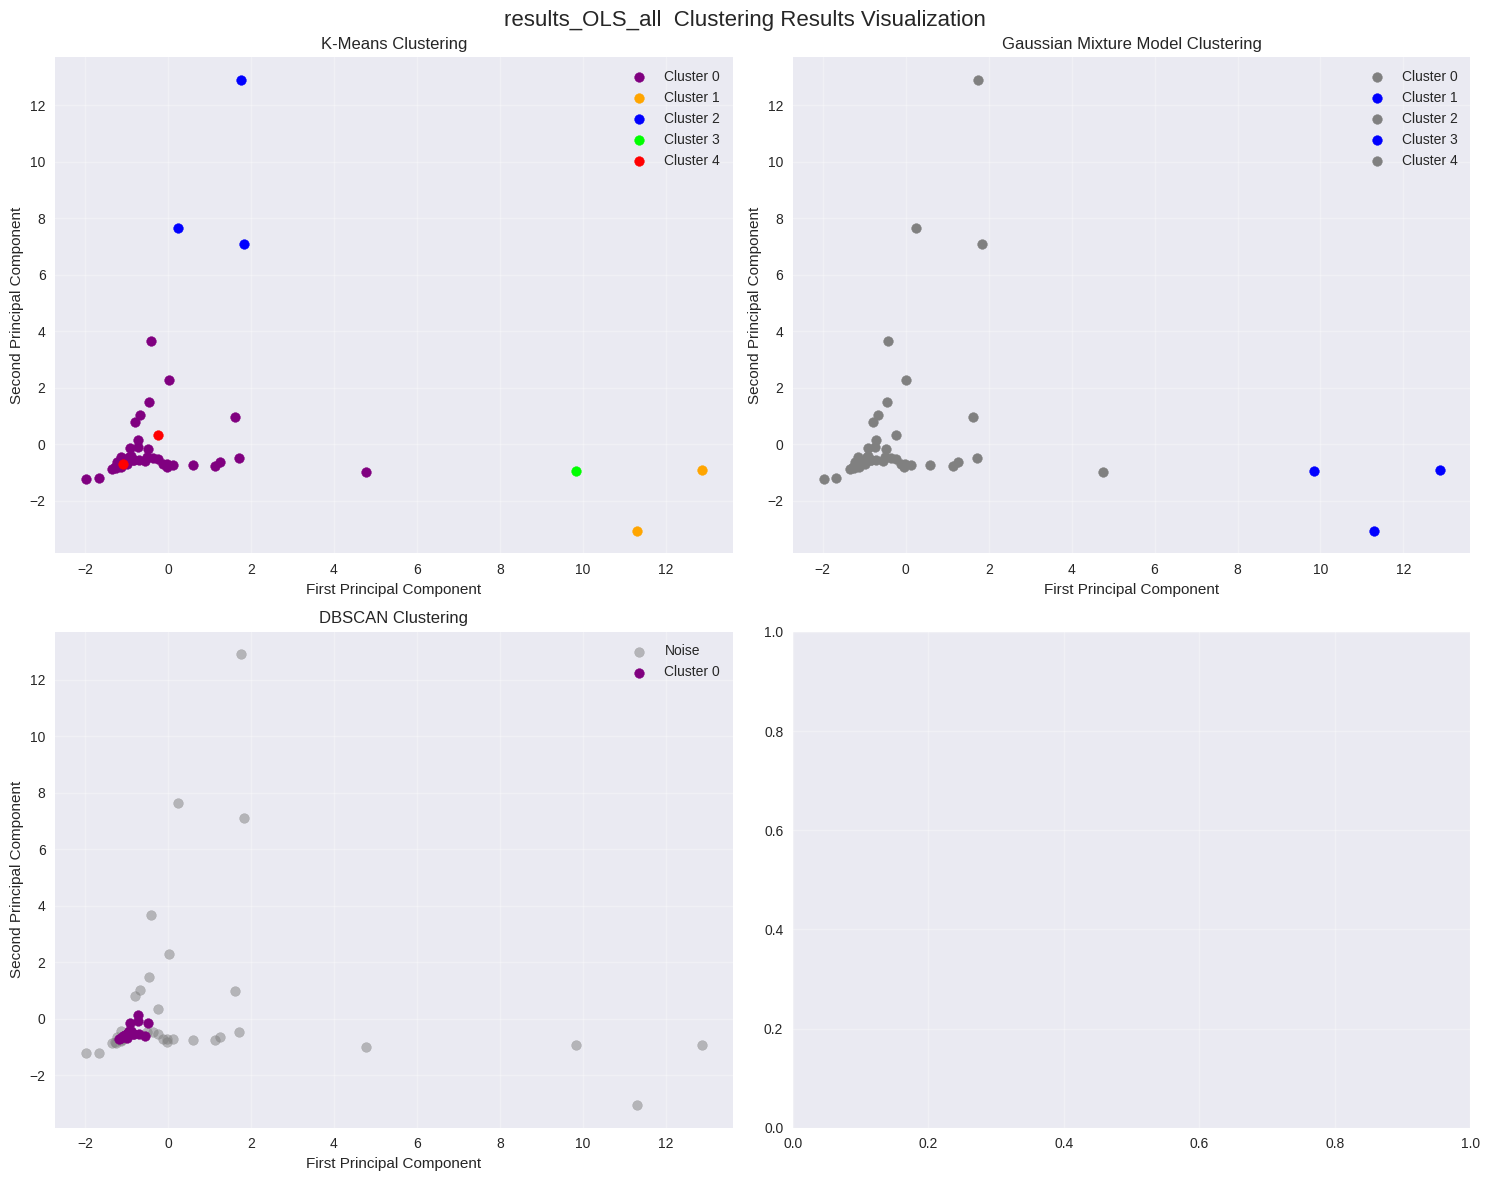


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 8.9253
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.5239
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.11662166071945221

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 8.9253
Silhouette Score: 0.7275569775743765
Davies-Bouldin Score: 0.39104114073843355
Adjusted Rand Score: 0.12140880609088245

Cluster Sizes:
Cluster 0: 62 points
Cluster 1: 2 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 21.35%
PC2: 14.84%
PC3: 10.66%
PC4: 8.53%
PC5: 6.63%
Total Variance Explained (first 10 PCs): 62.01%


In [261]:
# Running pipeline 
results_OLS_all_cluster = clustering_pipeline_all(OLS_all,  pca_data_name='pca_data_OLS_all',  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_OLS_all_cluster, title_prefix='results_OLS_all ')
print_clustering_metrics(results_OLS_all_cluster)

### OLS_all Discussion 
K-means: Silhouette Score of 0.678, Davies-Bouldin of 0.457
Cluster sizes imbalanced (57, 3, 1, 3, 6 points)
PCA explains 36.18% of variance
## 11.6 Clustering Influencers_uniques_selected

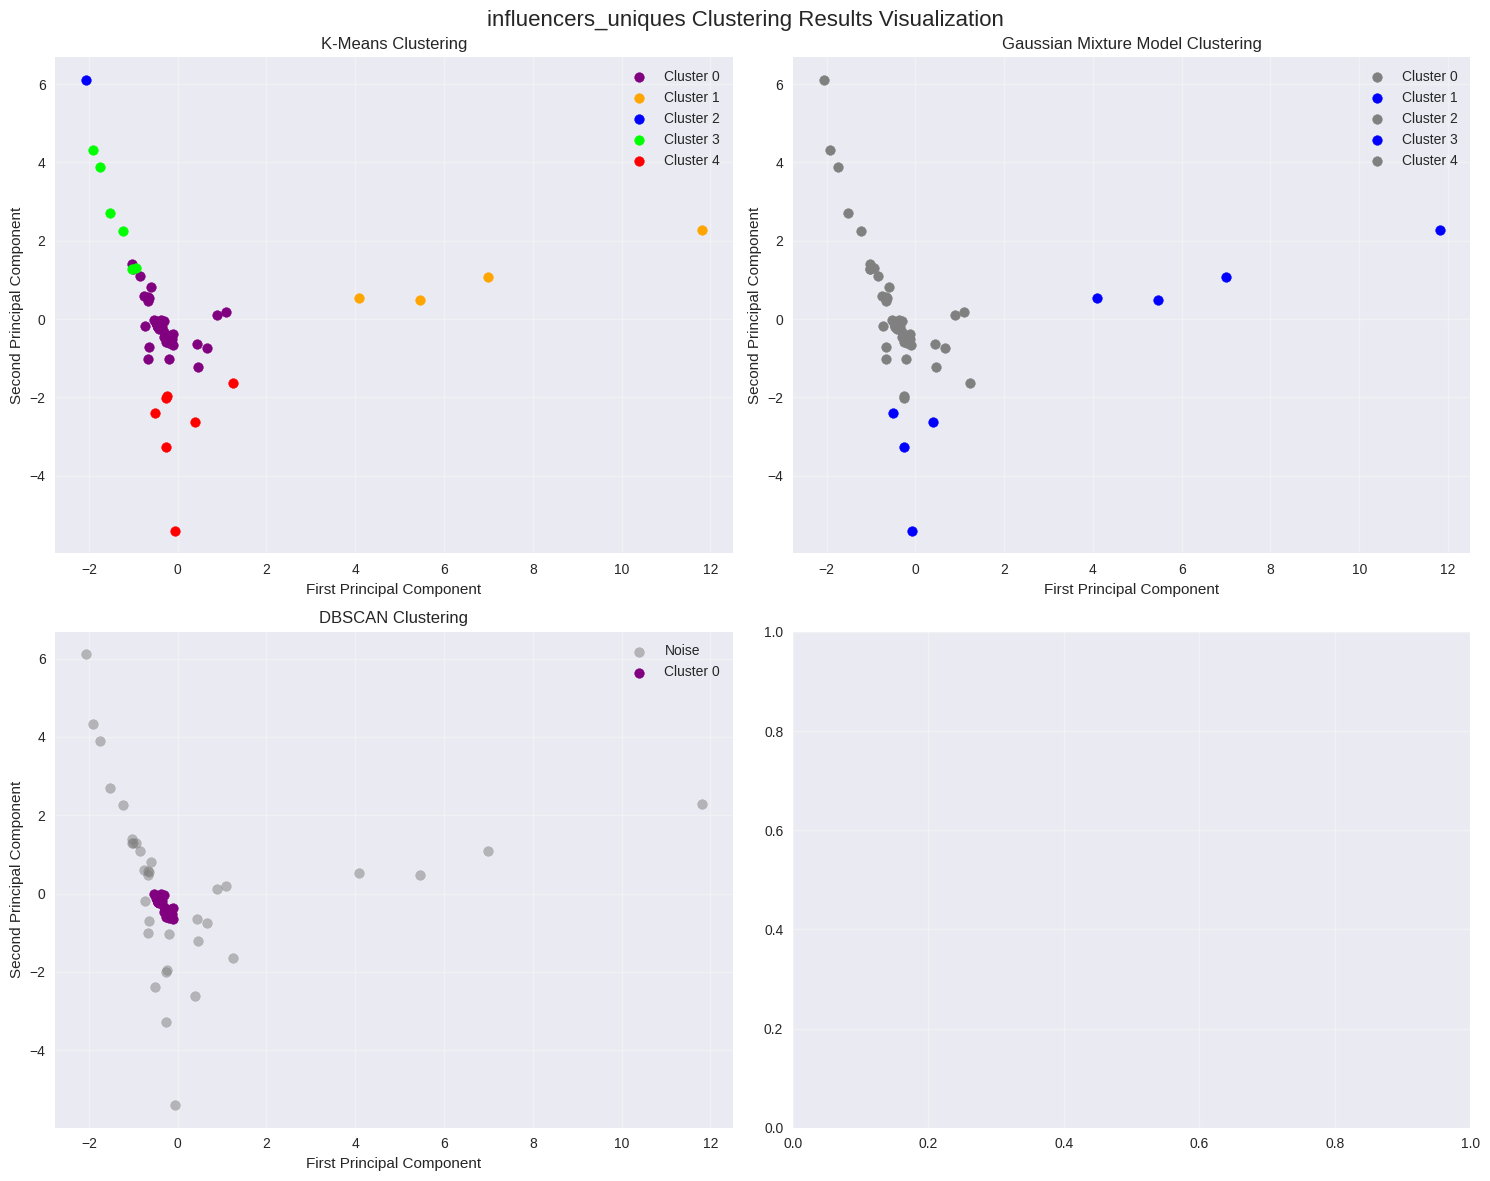


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.0222
Silhouette Score: 0.5666412492892613
Davies-Bouldin Score: 0.6056853771340288
Adjusted Rand Score: 0.21661164658713974

Cluster Sizes:
Cluster 0: 52 points
Cluster 1: 4 points
Cluster 2: 1 points
Cluster 3: 6 points
Cluster 4: 7 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.7159
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.1482303018613174

Cluster Sizes:
Cluster 0: 35 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 6.3025
Silhouette Score: 0.09718914461846219
Davies-Bouldin Score: 1.3699916834747552
Adjusted Rand Score: 0.1896639460287056

Cluster Sizes:
Cluster 0: 31 points
Cluster 1: 4 points
Cluster 2: 1 points
Cluster 3: 4 points
Cluster 4: 30 points

PCA Explained Variance Ratio:
PC1: 19.19%
PC2: 12.26%
PC3: 9.11%
PC4: 7.33%
PC5: 6.74%
Total Variance Explained (first 10 PCs): 54.63%


In [262]:
#implementing the algoritms in a part of uniques, the first 50 rows
results_influencers_uniques_selected_cluster = clustering_pipeline_all(Influencers_uniques_selected,  pca_data_name='pca_data_influencers_uniques_selected',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_influencers_uniques_selected_cluster, title_prefix='influencers_uniques')
print_clustering_metrics(results_influencers_uniques_selected_cluster) 

### Influencers_uniques_selected Discussion

## 11.7. Clustering Merged_selected

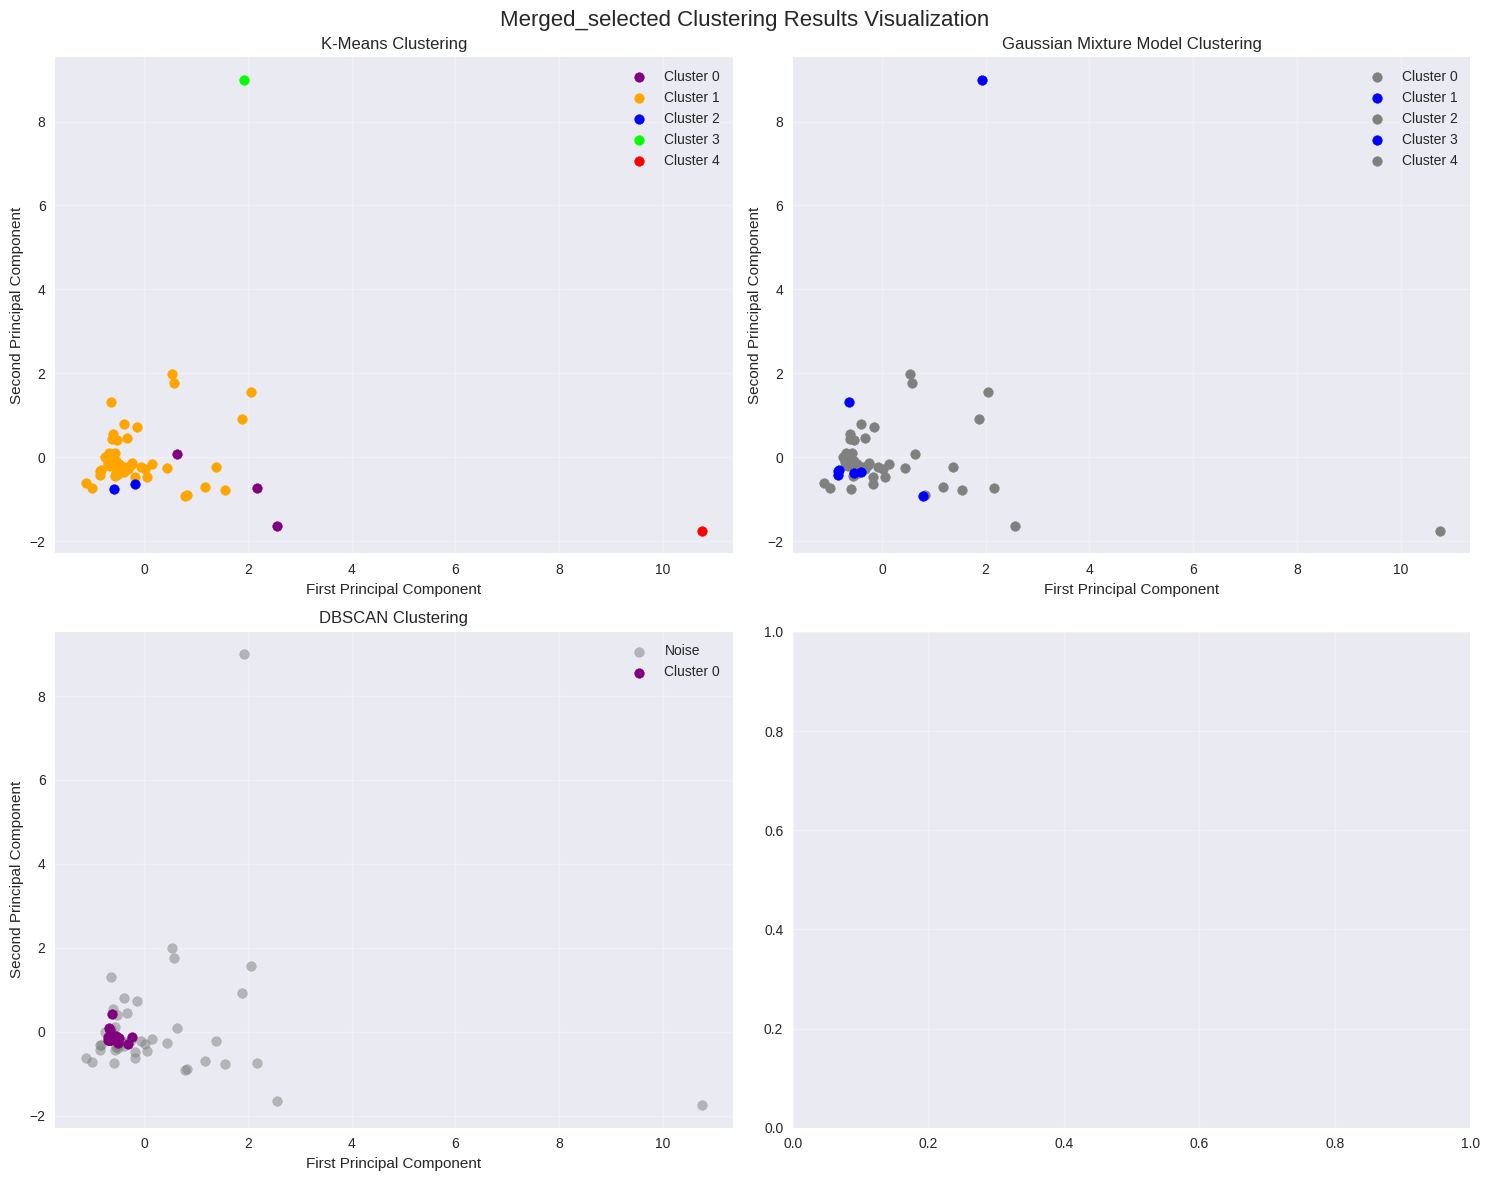


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 2.7026
Silhouette Score: 0.6028818816295077
Davies-Bouldin Score: 0.3571773700464675
Adjusted Rand Score: 0.062304326476033324

Cluster Sizes:
Cluster 0: 3 points
Cluster 1: 63 points
Cluster 2: 2 points
Cluster 3: 1 points
Cluster 4: 1 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 0.4645
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.009140036946152362

Cluster Sizes:
Cluster 0: 21 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 3.7238
Silhouette Score: 0.4353861265837115
Davies-Bouldin Score: 0.7670731085914051
Adjusted Rand Score: 0.046270469531108964

Cluster Sizes:
Cluster 0: 57 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 7 points
Cluster 4: 2 points

PCA Explained Variance Ratio:
PC1: 23.64%
PC2: 15.54%
PC3: 13.04%
PC4: 12.06%
PC5: 10.42%
Total Variance Explained (first 10 PCs): 74.70%


In [263]:
# Running pipeline 
results_Merged_selected_cluster = clustering_pipeline_all(Merged_selected,  pca_data_name='pca_data_Merged_selected',
                                                  n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_Merged_selected_cluster, title_prefix='Merged_selected')
print_clustering_metrics(results_Merged_selected_cluster)


## 11.8 Clustering old_new1

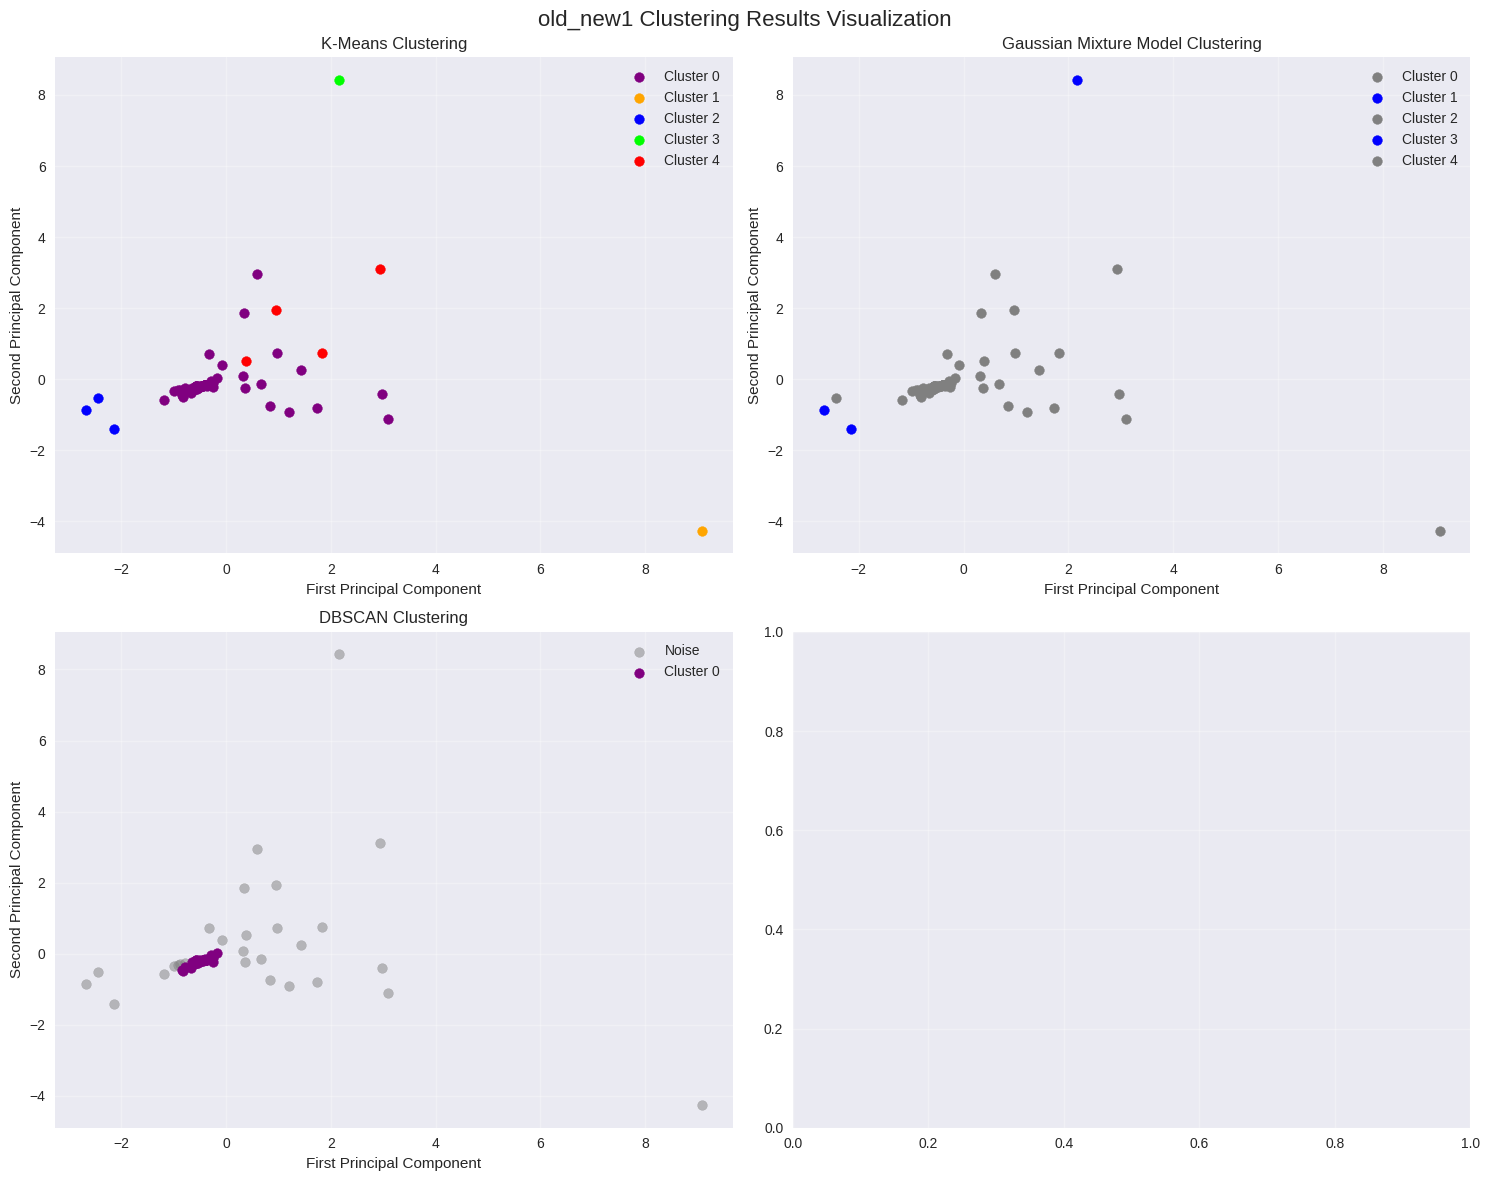


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 6.6949
Silhouette Score: 0.6250441254270628
Davies-Bouldin Score: 0.7040222043418188
Adjusted Rand Score: 0.009759190985449142

Cluster Sizes:
Cluster 0: 61 points
Cluster 1: 1 points
Cluster 2: 3 points
Cluster 3: 1 points
Cluster 4: 4 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 1.6668
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.09698554576697462

Cluster Sizes:
Cluster 0: 42 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.5963
Silhouette Score: 0.6393174777277574
Davies-Bouldin Score: 0.7160789151794396
Adjusted Rand Score: 0.04020358658748029

Cluster Sizes:
Cluster 0: 61 points
Cluster 1: 2 points
Cluster 2: 5 points
Cluster 3: 1 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 15.25%
PC2: 12.01%
PC3: 11.34%
PC4: 9.15%
PC5: 8.25%
Total Variance Explained (first 10 PCs): 56.01%


In [264]:
# Running pipeline 
results_old_new1_cluster = clustering_pipeline_all(old_new_1 ,  pca_data_name='pca_data_old_new1', 
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_old_new1_cluster, title_prefix='old_new1')
print_clustering_metrics(results_old_new1_cluster)

### old_new1 Discussion

## 11.9 Clustering old_new2

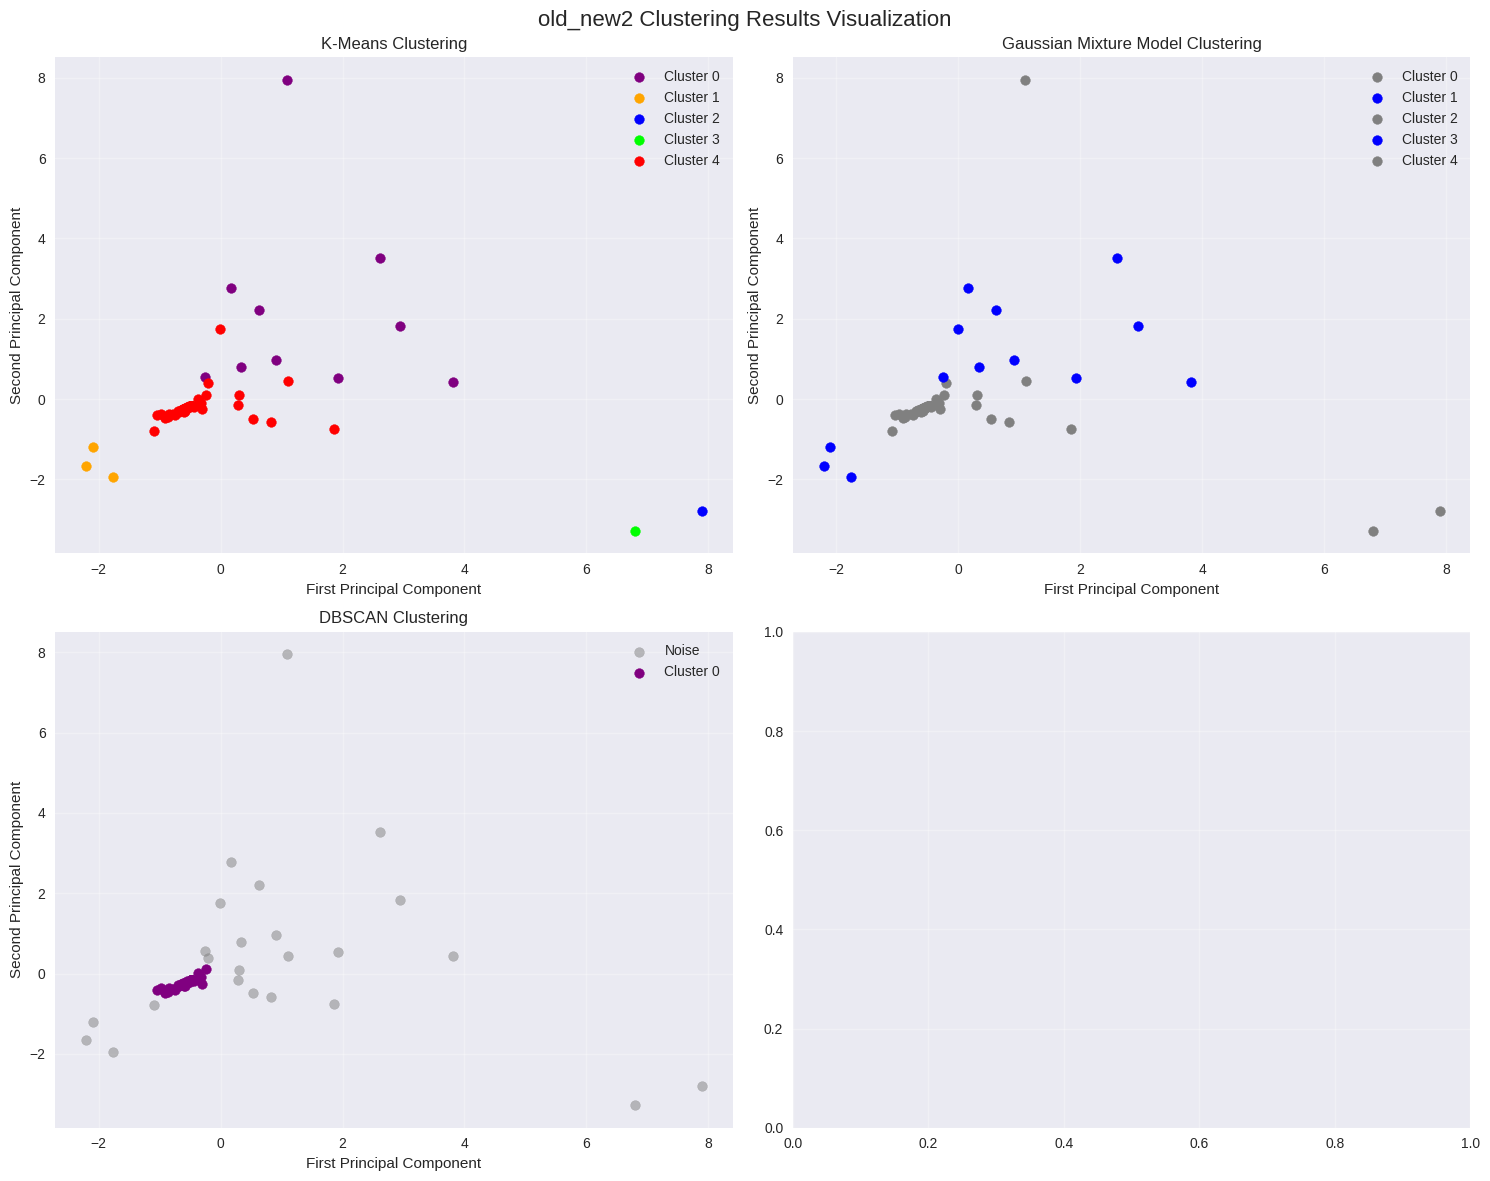


=== Clustering Metrics ===

KMEANS Clustering Metrics:
Average Intra-cluster Distance: 7.2917
Silhouette Score: 0.6473281674598893
Davies-Bouldin Score: 0.669314961831618
Adjusted Rand Score: 0.06969698987303004

Cluster Sizes:
Cluster 0: 10 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 1 points
Cluster 4: 55 points

DBSCAN Clustering Metrics:
Average Intra-cluster Distance: 2.1133
Silhouette Score: Not applicable
Davies-Bouldin Score: Not applicable
Adjusted Rand Score: 0.08704075278488894

Cluster Sizes:
Cluster 0: 46 points

GMM Clustering Metrics:
Average Intra-cluster Distance: 7.0768
Silhouette Score: 0.5993913471513231
Davies-Bouldin Score: 0.6323922341030952
Adjusted Rand Score: 0.045195182198904074

Cluster Sizes:
Cluster 0: 55 points
Cluster 1: 3 points
Cluster 2: 1 points
Cluster 3: 10 points
Cluster 4: 1 points

PCA Explained Variance Ratio:
PC1: 15.22%
PC2: 10.81%
PC3: 10.04%
PC4: 8.91%
PC5: 8.38%
Total Variance Explained (first 10 PCs): 53.35%


In [265]:
# Running pipeline 
results_old_new2_cluster = clustering_pipeline_all(old_new_2 ,  pca_data_name='pca_data_old_new2', 
                                                   n_clusters=5, eps=0.5, min_samples=5, n_components=5)
#Calling the function for visualisation
visualize_clustering_results(results_old_new2_cluster, title_prefix='old_new2')
print_clustering_metrics(results_old_new2_cluster)

### old_new2 Discussion

# 12. Clustering 3D Model df Influencers_OLS

In [266]:
# umpack data from results
pca_data = results_Influencers_OLS_cluster[f'pca_data_Influencers_OLS_cluster']  
scaled_data = results_Influencers_OLS_cluster['scaled_data']

# Now create the 3D plot
pc1 = pca_data[:, 0]
pc2 = pca_data[:, 1]
pc3 = pca_data[:, 2]

# Rest of your plotting code
fig = go.Figure(data=[
    go.Scatter3d(
        x=pc1,
        y=pc2,
        z=pc3,
        mode='markers',
        marker=dict(
            size=5,
            color=Influencers_OLS['Category'],
            colorscale='Viridis',
            opacity=0.8
        ),
        text=Influencers_OLS['Category']
    )
])

# Set plot title and axis labels
fig.update_layout(
    title='Interactive 3D PCA Visualization',
    scene=dict(
        xaxis_title='PCA Dimension 1',
        yaxis_title='PCA Dimension 2',
        zaxis_title='PCA Dimension 3'
    ))

fig.show()

## 12.1. On the Category and Cluster Atribution 
Upon inspection of the influencers_OLS with the clusters associated to the label on the PCA_RF_FImportance notebook, there is a consistent pattern and it is possible to distinguish three different regions on the exact place the categories are.  category 1 is a v shape that is intop of cat 2 which is in the middle and 3 form a lineal regression bewen 1 and 2 pca, so together form a y shape. it has a clear differenciation and I can see that cluster 1 is same as cat 3, cluster 2, 3 and 0 are cat 1 and that cluster 4 is cat 2. with no visual overlappings, unlikely with my labels which got at the end of the regression line of 3 an overlaping with the shape of the v. So if we were to distribute the cluster in this fashion, would be possible to say that the clustering is revealing consistent groupings that align with the original categorization:  

Category 1: Comprises clusters 0, 2, 3  (total 7 points)  
Category 2: Corresponds to cluster 4    (10 points)  
Category 3: Matches cluster 1           (53 points)  
The fact that there is a persistent structure on the shapes of all the dataframes 

Ultimately PCA primarily captures linear variance and might not effectively group data by absolute values. It's more about capturing directional variance and relationships rather than precise value clustering. The method projects data onto principal components that maximize variance, which doesn't necessarily mean it's capturing granular value-based distinctions
# 13. On the Mapping of Original Features to the PCA: Loadings

the principal components are mathematical combinations of the original features. It is possible to try to "invert" the PCA transformation to understand which original features are most responsible for the observed clustering patterns.
One approach would be to examine the PCA loading vectors or the contribution of each feature to the principal components. This could help identify the key underlying characteristics that are driving the separation of the data points. Moreover the cluster boundaries identified by the clustering algorithms are not fixed, static regions. They depend on the distribution of the data points and the specific parameters of the clustering methods. This means that the cluster assignments for individual data points may change if the clustering is performed again with different parameters or on a different dataset. The clustering results provide insights into the overall structure of the data, but the specific cluster boundaries are not guaranteed to be static or definitive.

The PCA loading vectors represent the coefficients that define each principal component. They indicate the relative importance or contribution of each original feature to the corresponding principal component.
By analyzing the loading vectors, it is possible to understand which of the original features are most influential in driving the separation of the data points along the different principal components. Which is very combinient because I am about to decide the selected data from each one of the dfs Influencers_OLS, OLS_all and uniques_23_OLS. By loading the vectors and identifying the original variables that more contribute to the separation, it would help with the selection of the selected genera to implement the cross examination with the physicochemical variables. With this loadings dataframe it is possible to  analyse the relationship with the original features across the principal components, by: higher absolute values = feature importance or features that contrute the most to the separation of the data points. By understand the dimension of the PCAs, then similar loading size hint similar aspects of the data or sinergistic effects?. By connecting clusters loading vectors to the clustering patterns and features, to know which are the most relevant features. 

## 13.1 Scripts 
### Script to Calculate Loadings 

In [267]:
def calculate_and_analyze_pca_loadings(df, pca, scaled_data_key, output_prefix):
    """
    Calculate and analyze PCA loadings for a given dataset.
    
    Parameters:
    df (pandas.DataFrame): The original DataFrame.
    pca (sklearn.decomposition.PCA): The PCA object from a previous analysis.
    scaled_data_key (str): The key in the results dictionary that holds the scaled data.
    output_prefix (str): A prefix for the output variables to ensure uniqueness.
    
    Returns:
    A dictionary containing the following keys:
    - f"{output_prefix}_loadings_df": The DataFrame of loading vectors.
    - f"{output_prefix}_top_loadings": A dictionary of top contributors for each principal component.
    """
    # Get the loading vectors
    loadings = pca.components_.T
    
    # Create a DataFrame with the loading vectors
    loadings_df = pd.DataFrame(loadings, 
                              index=df.columns[1:], 
                              columns=[f'PC{i+1}' for i in range(loadings.shape[1])])
       
    # Identify top contributors to each principal component
    def get_top_loadings(loadings_df, n_top=10):
        top_loadings = {}
        for col in loadings_df.columns:
            top_loadings[col] = loadings_df[col].abs().nlargest(n_top)
        return top_loadings
    
    top_loadings = get_top_loadings(loadings_df)
    
    # Store the results in a dictionary
    results = {
        f"{output_prefix}_loadings_df": loadings_df,
        f"{output_prefix}_top_loadings": top_loadings
    }
    
    return results

### Heatmap visualisation for PCA loadings
Here the relationships between features and components are visualised and highlight the absolute values of the loading vectors, as they represent the magnitude of feature contributions.

In [268]:
def plot_top_pca_loadings(top_loadings, output_prefix):
    """
    Create a heatmap visualization for the top PCA loadings.
    
    Parameters:
    - top_loadings (dict): A dictionary where the keys are the principal component names
                          and the values are Series containing the top contributing features.
    - output_prefix (str): A prefix for the output file name.
    """
    # Convert the top_loadings dictionary to a DataFrame
    top_loadings_df = pd.concat([loadings.rename(pc) for pc, loadings in top_loadings.items()], axis=1)
    
    # Ensure proper labels and formatting
    top_loadings_df.index.name = 'Feature'
    top_loadings_df.columns.name = 'Principal Component'
    
    # Plot a heatmap for top loadings
    plt.figure(figsize=(8, 6))
    sns.heatmap(top_loadings_df,annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Loading Magnitude'})
    plt.title("Top PCA Loadings (10 Features per Component)")
    plt.xlabel("Principal Components")
    plt.ylabel("Top Contributing Features")
    plt.tight_layout()
    plt.savefig(f"{output_prefix}_top_pca_loadings.png", dpi=300)
    plt.show()

Calling the function to calculate and analyse the pca loadings for the dfs
## 13.2. original_pca Pca Loadings

Explained Variance Ratio: [0.13396565 0.11837093 0.10092034 0.09149917 0.08097643]
Cumulative Variance Ratio: [0.13396565 0.25233658 0.35325692 0.44475608 0.52573251]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
140  0.0681 -0.0998  0.2964 -0.0216  0.1530
575  0.1032 -0.0043 -0.0674 -0.2632  0.1652
687  0.0850 -0.1164  0.3295 -0.0455  0.1614
465 -0.0518  0.0101 -0.0884  0.2021  0.2099
300  0.0463 -0.1236  0.3577  0.0128  0.1289
529 -0.0910  0.2019  0.0702 -0.0284 -0.0374
609  0.0966  0.0020 -0.0574 -0.1961  0.1158
564 -0.1483  0.3395  0.1131  0.0326  0.1242
250  0.3263  0.1057  0.1029  0.1200 -0.0299
474  0.0181 -0.0752  0.1791  0.0139  0.0106

Top Contributors to Principal Components:

PC1 Top Contributors:
413   0.3386
546   0.3384
265   0.3374
720   0.3310
250   0.3263
512   0.3243
44    0.2722
145   0.2000
564   0.1483
13    0.1366
Name: PC1, dtype: float64

PC2 Top Contributors:
13    0.3502
187   0.3470
736   0.3470
662   0.3468
564   0.3395
727   0.3012
529   0.

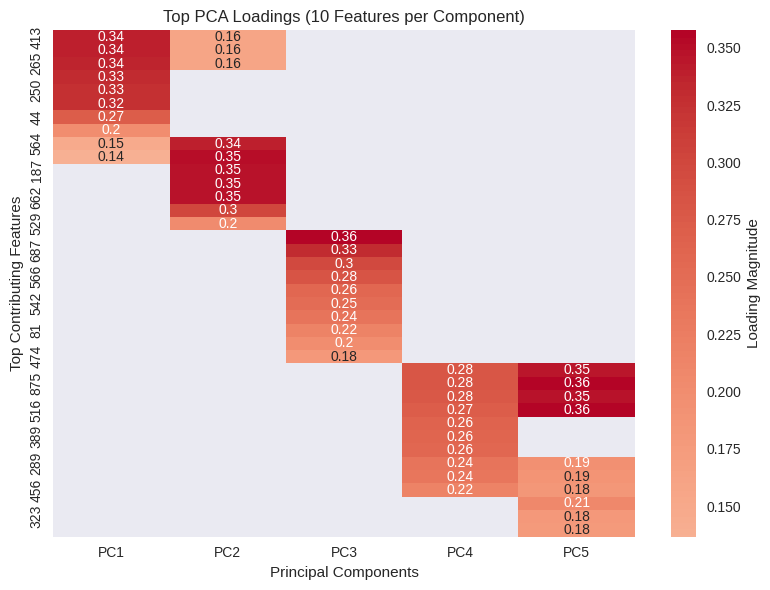

In [269]:
# We taking the data from the previous algoritms results
pca = results_original_pca_cluster['pca']
scaled_data = results_original_pca_cluster['scaled_data']
# Loadings calculation call
results_original_pca_Loadings = calculate_and_analyze_pca_loadings(original_pca, pca, 'scaled_data', 'original_pca')

# Access the results
loadings_df = results_original_pca_Loadings['original_pca_loadings_df']
explained_variance = results_original_pca_cluster['explained_variance']
cumulative_variance = results_original_pca_cluster['cumulative_variance']
top_loadings = results_original_pca_Loadings['original_pca_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_original_pca_Loadings['original_pca_top_loadings'],'original_pca')

### Discussing  original_pca
## 13.3. Influencers_OLS Pca Loadings

Explained Variance Ratio: [0.19122825 0.1640954  0.10924184 0.0915163  0.06725806]
Cumulative Variance Ratio: [0.19122825 0.35532365 0.46456549 0.55608179 0.62333985]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
725  0.3852  0.0133  0.0778  0.0580 -0.1560
871 -0.0639  0.4981  0.2586 -0.1095  0.0013
214 -0.0865 -0.1238  0.2747  0.1622 -0.4173
351  0.2767 -0.0060  0.0575 -0.0500  0.0493
23   0.4812  0.0266  0.1047  0.0583 -0.0191
91  -0.0051  0.2152 -0.2902  0.3076  0.1107
863  0.2320  0.0445 -0.1318  0.0041  0.2558
526 -0.0764 -0.1041  0.1865  0.0501 -0.5566
584 -0.0601 -0.0832  0.1729  0.0905 -0.2839
712 -0.0642  0.4990  0.2570 -0.1063  0.0000

Top Contributors to Principal Components:

PC1 Top Contributors:
23    0.4812
565   0.4489
864   0.4102
725   0.3852
351   0.2767
375   0.2663
863   0.2320
229   0.0957
214   0.0865
526   0.0764
Name: PC1, dtype: float64

PC2 Top Contributors:
712   0.4990
871   0.4981
625   0.4972
549   0.2934
91    0.2152
334   0.1610
678   0.

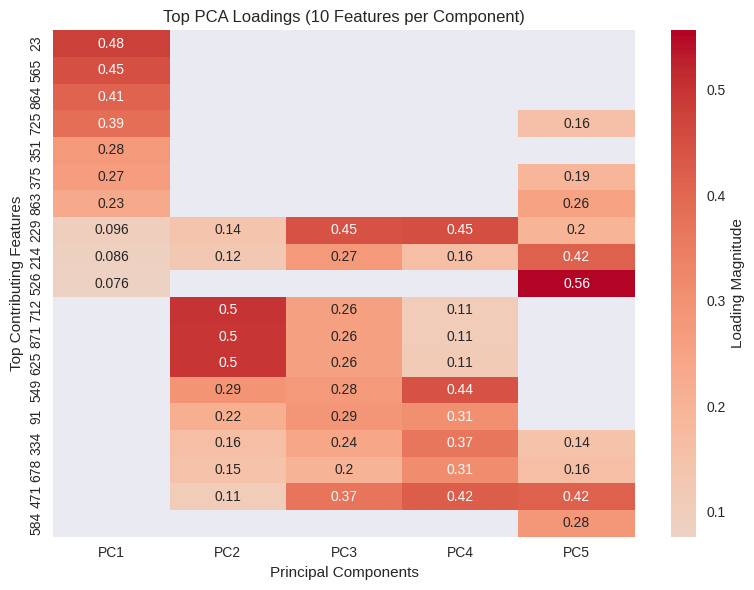

In [270]:
# We taking the data from the previous algoritms results
pca = results_Influencers_OLS_cluster['pca']
scaled_data = results_Influencers_OLS_cluster['scaled_data']
# Loadings calculation call
results_Influencers_Loadings = calculate_and_analyze_pca_loadings(Influencers_OLS, pca, 'scaled_data', 'Influencers_OLS')

# Access the results
loadings_df = results_Influencers_Loadings['Influencers_OLS_loadings_df']
explained_variance = results_Influencers_OLS_cluster['explained_variance']
cumulative_variance = results_Influencers_OLS_cluster['cumulative_variance']
top_loadings = results_Influencers_Loadings['Influencers_OLS_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Influencers_Loadings['Influencers_OLS_top_loadings'],'Influencers_OLS')

### Influencers_OLS Discussing 
Top contributors for PC1 and PC2 are seen. These contributions suggest which original variables drive the variance along each principal axis. Loading values indicate the weight or influence of a feature on a principal component. In for Influencers_OLS feature 23 contributes 0,48 to PC1 and feature 712 contributes 0.499 to PC2.  
When puting 7 components the total explained variance ratio of the first 7 PCs is 74.19%.   
Strong contribution from PC1 to PC3. Cumulative explained variance achieves a balance of high dimensionality reduction with a reasonable representation. Total explained variance ratio of the first 7 PCs is 68.38%.
Reduced explained variance suggests the additional features do not significantly improve variance representation. In fact, they dilute the strength of the first PCs.
## 13.4. Influencers_uniques_selected Pca Loadings

Explained Variance Ratio: [0.19191792 0.12257866 0.09111236 0.07334613 0.06735438]
Cumulative Variance Ratio: [0.19191792 0.31449658 0.40560894 0.47895507 0.54630946]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
549  0.0248 -0.3650  0.4823 -0.0232  0.1862
526 -0.0874  0.2185  0.0267 -0.1752 -0.0330
864  0.4084  0.0881  0.0459 -0.0225 -0.0919
863  0.2367 -0.1173  0.0654 -0.0343 -0.2873
408 -0.0826  0.1682  0.0748 -0.3803  0.2352
91   0.0176 -0.3470  0.4122 -0.1036 -0.0564
351  0.2742  0.0707 -0.0586  0.0111 -0.1296
214 -0.0998  0.2970  0.1306 -0.0684 -0.0404
229 -0.1109  0.4254  0.4015  0.3501 -0.0565
23   0.4780  0.1150  0.0579 -0.0196  0.0150

Top Contributors to Principal Components: Influencers_uniques

PC1 Top Contributors:
23    0.4780
565   0.4455
864   0.4084
725   0.3821
351   0.2742
375   0.2657
863   0.2367
229   0.1109
214   0.0998
526   0.0874
Name: PC1, dtype: float64

PC2 Top Contributors:
229   0.4254
549   0.3650
91    0.3470
471   0.3427
214   0.2970
3

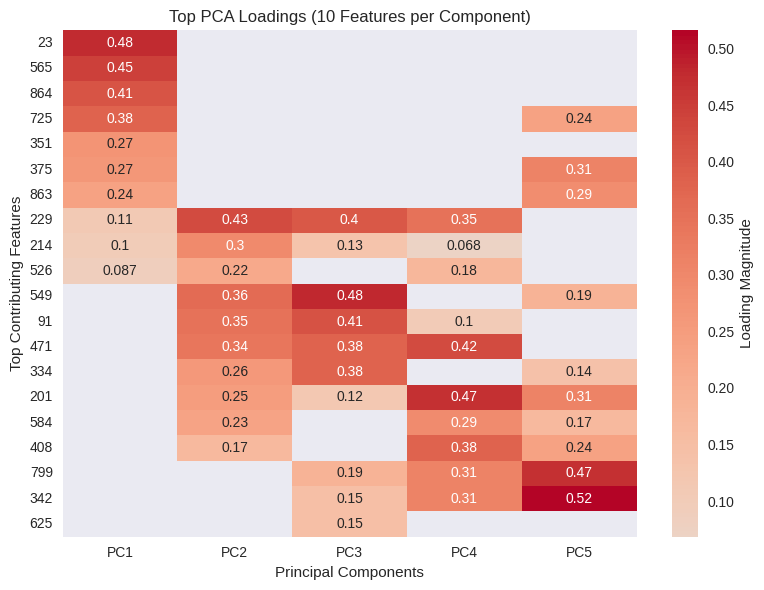

In [271]:
# We taking the data from the previous algoritms results
pca = results_influencers_uniques_selected_cluster['pca']
scaled_data = results_influencers_uniques_selected_cluster['scaled_data']
# Loadings calculation call
results_influencers_uniques_selected_Loadings = calculate_and_analyze_pca_loadings(Influencers_uniques_selected, pca, 
                                                                 'scaled_data', 'Influencers_uniques_selected')

# Access the results
loadings_df = results_influencers_uniques_selected_Loadings['Influencers_uniques_selected_loadings_df']
explained_variance = results_influencers_uniques_selected_cluster['explained_variance']
cumulative_variance = results_influencers_uniques_selected_cluster['cumulative_variance']
top_loadings = results_influencers_uniques_selected_Loadings['Influencers_uniques_selected_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components: Influencers_uniques")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_influencers_uniques_selected_Loadings['Influencers_uniques_selected_top_loadings'],'Influencers_uniques_selected')

### Discussing Influencers_uniques_selected Pca Loadings
## 13.5. Merged_selected Pca Loadings

Explained Variance Ratio: [0.2364268  0.15544553 0.13035581 0.12063869 0.10416161]
Cumulative Variance Ratio: [0.2364268  0.39187233 0.52222815 0.64286684 0.74702845]

Loading Vectors:
        PC1     PC2     PC3     PC4     PC5
549 -0.0929 -0.0906 -0.0276 -0.4819 -0.3823
110 -0.0506 -0.0668  0.2163  0.7116 -0.1860
526  0.3344  0.5979  0.0540 -0.1087 -0.0359
323  0.4869 -0.2416  0.2863 -0.1280  0.0307
270  0.0471 -0.0492 -0.4971 -0.2463 -0.3734
491  0.0749  0.7214  0.0223  0.0132  0.0581
140  0.5380 -0.1395 -0.2232  0.0865  0.0305
470 -0.0118 -0.0904 -0.3073 -0.1137  0.8071
214  0.5569 -0.0931 -0.2296  0.2022 -0.1074
23   0.1798 -0.1108  0.6504 -0.3332  0.1016

Top Contributors to Principal Components:

PC1 Top Contributors:
214   0.5569
140   0.5380
323   0.4869
526   0.3344
23    0.1798
549   0.0929
491   0.0749
110   0.0506
270   0.0471
470   0.0118
Name: PC1, dtype: float64

PC2 Top Contributors:
491   0.7214
526   0.5979
323   0.2416
140   0.1395
23    0.1108
214   0.0931
549   0.

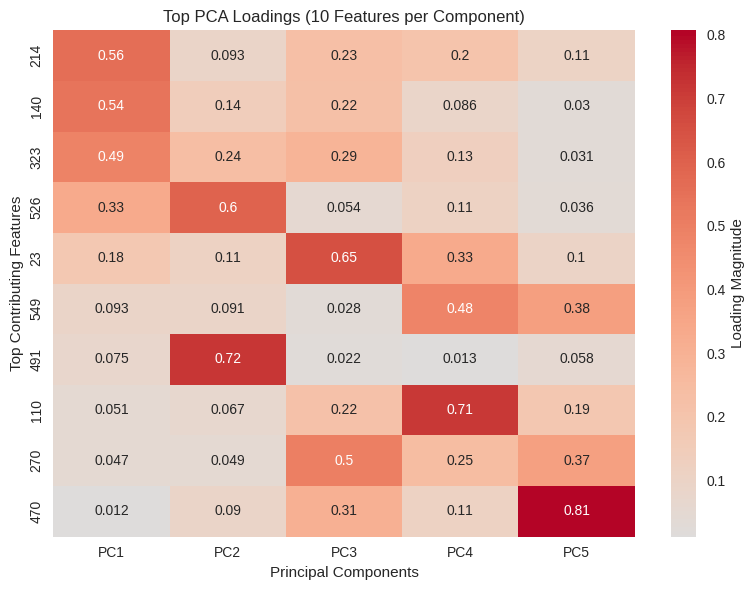

In [272]:
# We taking the data from the previous algoritms results
pca = results_Merged_selected_cluster['pca']
scaled_data = results_Merged_selected_cluster['scaled_data']
# Loadings calculation call
results_Merged_selected_Loadings = calculate_and_analyze_pca_loadings(Merged_selected, pca, 'scaled_data', 'Merged_selected')

# Access the results
loadings_df = results_Merged_selected_Loadings['Merged_selected_loadings_df']
explained_variance = results_Merged_selected_cluster['explained_variance']
cumulative_variance = results_Merged_selected_cluster['cumulative_variance']
top_loadings = results_Merged_selected_Loadings['Merged_selected_top_loadings']

# Print or analyze the results
print("Explained Variance Ratio:", explained_variance)
print("Cumulative Variance Ratio:", cumulative_variance)
print("\nLoading Vectors:")
print(loadings_df.head(10))
print("\nTop Contributors to Principal Components:")
for pc, loadings in top_loadings.items():
    print(f"\n{pc} Top Contributors:")
    print(loadings)

# Visualising the loadings on a simple heatmap
plot_top_pca_loadings(results_Merged_selected_Loadings['Merged_selected_top_loadings'],'Merged_selected')

### Discussing Merged_selected
This df gives very strong signal for features 354 PC5 and also PC4. PC3 has some contributors such as 110, 491, 561, which could have some biological significance. Same for PC2 with 110, 549 and 18. PC1 could be represented only by 214, 140, 572 and 18. 

### Conclusions on Loadings Metrics
Looking at the loadings and PCA results across the datasets:
Influencers_OLS shows: Strongest contributors to PC1: 23, 565, 864, 725. PC2: 712, 871, 625, 549, Total variance explained by 5 PCs: 62.33%

Influencers_uniques shows: PC1 led by: 23, 565, 864, 725. PC2: 229, 549, 91, 471. Less total variance explained (54.63%)
Merged_selected shows:
Different pattern with PC1: 214, 323, 572, 526. PC2: 549, 18, 371, 110. Higher total variance explained (66.93%).

# 14. Discriminative Selection 

Features 549, 214, 229, and 526 consistently appear important across datasets, though their contributions vary, suggesting different underlying structures. The improved color separation in clustering visualizations indicates feature 549's importance may relate to cluster separation. While DBSCAN showing mostly noise suggests the structure isn't density-based, the clear category-linked patterns in other clustering methods indicate strong discriminative potential. In order to select the features contributing to the risk label and no to neglect any important data points, a discriminative selection would take place. The mapping of the cluster to the categories would be done for each of the dataframes, so to be more precise. The discriminative selection of the features can be done to take into account all the metrics presented in this notebook, so no to prescind of important genera.

## 14.1. Adjusted Rand Index (ARI): Mapping of Clusters to Category
To properly evaluate feature importance, we need to map clusters to their corresponding categories for each dataframe. This mapping allows us to assess how well the clustering aligns with our known categories. The ARI will measure this alignment, adjusting for chance agreement. We'll analyze these key dataframes:

original_pca: Baseline for comparison
Influencers_uniques_selected: Current best performer with highest classification accuracy
Merged_selected: Combined features from multiple analyses
old_new_1 and old_new_2: Previous feature selections that showed promise

In [273]:
# Define mappings for each mappable dataset based on clustering analysis
mappings = {
'Influencers_OLS': {   # from 4.4. and 11.4
        1:1, 3:1, # v shape - v shape Category 1 green
        4:2,   # middle Category 2 yellow 
        0:3, 2:3     # Linear Category 3  red 
    },
    'Influencers_uniques_selected': { # from 8.1. and 11.6
      1:1, 4:1, # inverted v shape Category 1 green
      0:2,      # middle Category 2 yellow 
      2:3, 3:3  # # Linear Category 3  red 
    }
}
# Function to apply mapping and calculate ARI
def calculate_mapped_ari(df, df_name, cluster_labels):
    mapping = mappings[df_name]
    mapped_labels = np.array([mapping[label] for label in cluster_labels])
    true_labels = df['Category']
    return adjusted_rand_score(true_labels, mapped_labels), mapped_labels

# Store results for each dataset
mapping_results = {}
for df_name in mappings.keys():
    if df_name == 'Influencers_OLS':
        labels = results_Influencers_OLS_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Influencers_OLS, df_name, labels)
        mapping_results[df_name] = {
            'ari': ari,
            'mapped_labels': mapped
        }

    elif df_name == 'Influencers_uniques_selected':
        labels = results_influencers_uniques_selected_cluster['kmeans']['cluster_labels']
        ari, mapped = calculate_mapped_ari(Influencers_uniques_selected, df_name, labels)
        mapping_results[df_name] = {
        'ari': ari,
        'mapped_labels': mapped
        }

## 14.2. Performance Comparison Calculation and Visualisation
Before proceeding with discriminative selection, we evaluated the overall performance of our key dataframes using multiple metrics. These include PCA variance explained, classification accuracy, F1 scores, K-means silhouette scores, and clustering ARI. 

Performance Metrics Comparison:
                        Dataset  PCA_Variance_Explained  \
0               Influencers_OLS                  0.3553   
1               Merged_selected                  0.3919   
2  Influencers_uniques_selected                  0.3145   

   Classification_Accuracy  Classification_F1  Kmeans_Silhouette  \
0                   0.8286             0.6400             0.6484   
1                   0.6788             0.6591             0.6029   
2                   0.9571             0.9286             0.5666   

   Clustering_ARI  
0          0.1845  
1          0.0623  
2          0.2166  


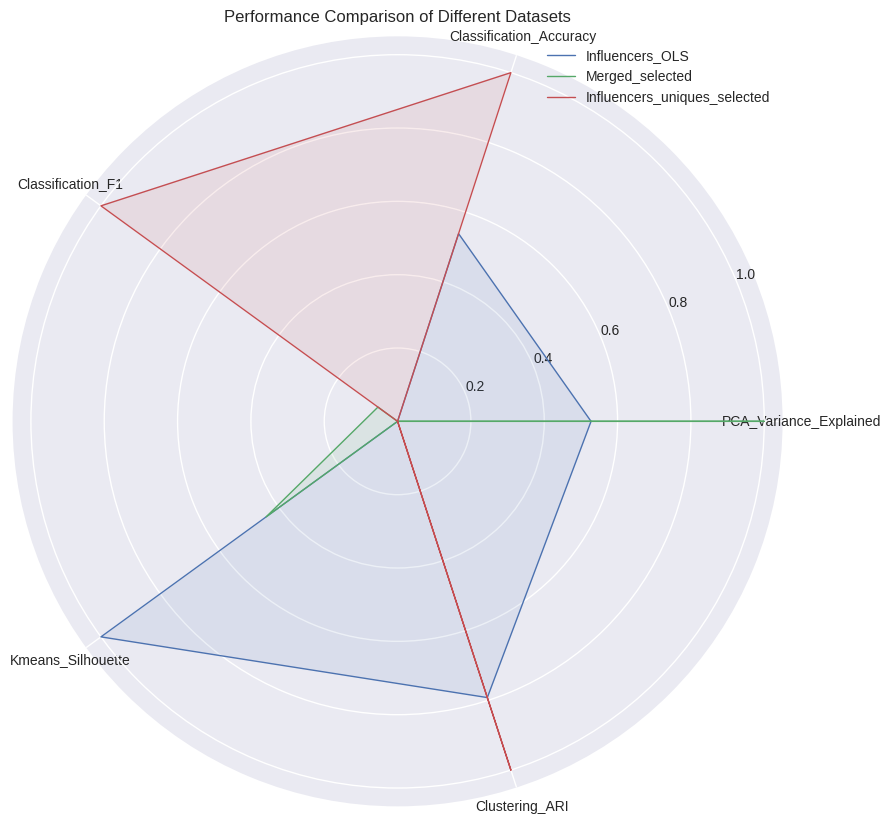

In [285]:
# Compile performance metrics for each dataframe
performance_metrics = pd.DataFrame(columns=[
    'Dataset',
    'PCA_Variance_Explained',
    'Classification_Accuracy',
    'Classification_F1',
    'Kmeans_Silhouette',
    'Clustering_ARI'
])

# Influencers_OLS metrics
influencers_OLS_metrics = pd.Series({
    'Dataset': 'Influencers_OLS',
    'PCA_Variance_Explained': results_Influencers_OLS_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.8286,  # From section 6.4
    'Classification_F1': 0.64,         # From section 6.4
    'Kmeans_Silhouette': results_Influencers_OLS_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_Influencers_OLS_cluster['kmeans']['adjusted_rand_score']
})

# Merged_selected metrics
merged_metrics = pd.Series({
    'Dataset': 'Merged_selected',
    'PCA_Variance_Explained': results_Merged_selected_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.6788,    # From section 8.2
    'Classification_F1': 0.6591,       # From section 8.2
    'Kmeans_Silhouette': results_Merged_selected_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_Merged_selected_cluster['kmeans']['adjusted_rand_score']
})

# Influencers_uniques_selected metrics
influencers_uniques_selected_metrics = pd.Series({
    'Dataset': 'Influencers_uniques_selected',
    'PCA_Variance_Explained': results_influencers_uniques_selected_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.9571,  # From section 7.1
    'Classification_F1': 0.9286,       # From section 7.1
    'Kmeans_Silhouette': results_influencers_uniques_selected_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_influencers_uniques_selected_cluster['kmeans']['adjusted_rand_score']
})
# Old_new metrics collection
old_new_1_metrics = pd.Series({
    'Dataset': 'old_new_1',
    'PCA_Variance_Explained': results_old_new1_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.6788,  # Need actual value
    'Classification_F1': 0.6591,        # Need actual value
    'Kmeans_Silhouette': results_old_new1_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_old_new1_cluster['kmeans']['adjusted_rand_score']
})

old_new_2_metrics = pd.Series({
    'Dataset': 'old_new_2',
    'PCA_Variance_Explained': results_old_new2_cluster['explained_variance'][:2].sum(),
    'Classification_Accuracy': 0.6788,  # Need actual value
    'Classification_F1': 0.6591,        # Need actual value
    'Kmeans_Silhouette': results_old_new2_cluster['kmeans']['silhouette_score'],
    'Clustering_ARI': results_old_new2_cluster['kmeans']['adjusted_rand_score']
})



# Add metrics to DataFrame
performance_metrics = performance_metrics.append([
    influencers_OLS_metrics,
    merged_metrics,
    influencers_uniques_selected_metrics
], ignore_index=True)

# Create a radar plot to visualize performance comparison
def radar_plot(df):
    # Prepare the data
    categories = list(df.columns)[1:]  # Skip 'Dataset' column
    n_categories = len(categories)
    
    # Normalize the values
    values_norm = df[categories].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    
    # Calculate angles for each axis
    angles = [n / float(n_categories) * 2 * np.pi for n in range(n_categories)]
    angles += angles[:1]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot data
    for idx, row in values_norm.iterrows():
        values = row.values.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=df.iloc[idx]['Dataset'])
        ax.fill(angles, values, alpha=0.1)
    
    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    plt.legend(loc='upper right')
    plt.title('Performance Comparison of Different Datasets')
    plt.show()

# Display numeric results
print("Performance Metrics Comparison:")
print(performance_metrics)

# Create visualization
radar_plot(performance_metrics)

Looking at the metrics and the plot it is seen that Influencers_unique_selected has the 
Highest Classification Accuracy (0.9571), highest F1 score (0.9286), best Clustering_ARI (0.2166), moderate Silhouette score (0.5666), lowest PCA Variance (0.3145)

While Influencers_OLS has: good Classification Accuracy (0.8286), lower F1 score (0.6400), best Silhouette score (0.6484), highest PCA Variance (0.3553)

Despite Influencers_uniques_selected having better classification metrics, the slightly higher PCA variance and silhouette score of Influencers_OLS suggests it might capture the underlying structure better. This aligns with what we observed in the PCA plots where Influencers_OLS showed clearer category separation patterns.

## 14.3. Script Discriminative Selection
The following script take a comprehensive look to all the metrics taken from the outstanding dataframes comparing them, and makes a discriminative selection of the most relevant Features that get the best score out of all the metrics, the pca influence from section 4, the predictive metrics from section 6, the clusters mapped labels, and kmeans clustering results from section 11 and the loadings to refer the metrics to the original features. The idea was to make the selection over the colective dataframes, however features often work together and their importance can be highly context dependent. A feature might appear significant in one dataset combination but less so in another due to feature interacions, only discriminative when combined or in presence of other features. Or could be redundant, or carry same information and when combined with other similar feature then it would appear less significant. Also it could be that some features have a synergistic effect, which increase or supress the discriminative power. Due to that instead of combining all features and metrics. The reduced and still standing dataframes that performed better or have interesting features: 
original_pca with the whole dataset information as baseline
old_new_1 -->former selected genera 1
old_new_2 -->former selected genera 2
Influencers_uniques_selected--> best performer
Merged_selected-->collection of all other dataframes best features
Two of the dataframes underwent a mapping of the cluster to category selection first: Influencers_OLS and Influencers_uniques_selected. 
A compendium all of the top performer genera would be merge and compared to see if the metrics decreased, ultimately for the next step all the best features can be brought without much triming, so that the biological significate be evaluated and then the triming process can be done, if not statistically nor biological relevant.
Following script calculates category separation scores using mean differences and standard deviations. Evaluates cluster alignment using mapped labels. Incorporates Random Forest importance and PCA influence.Combines scores with adjustable weights and returns detailed metrics for each feature.

In [275]:
def select_discriminative_features(
    data,                     # Original dataframe
    mapped_kmeans_labels,     # From our cluster mapping
    feature_importances_rf,   # From Random Forest
    pca_influences,          # From PCA analysis
    n_features=20            # Number of features to select
):
    """
    Select most discriminative features based on multiple criteria
    """
    # Initialize results dictionary
    feature_scores = {}
    
    # Get feature names (excluding Category and Sites)
    features = [col for col in data.columns if col not in ['Category', 'Sites']]
    
    for feature in features:
        feature_values = data[feature].values
        
        # 1. Category Separation Score
        # Calculate mean and std for each category
        category_stats = {}
        for cat in [1, 2, 3]:
            cat_values = feature_values[data['Category'] == cat]
            category_stats[cat] = {
                'mean': np.mean(cat_values),
                'std': np.std(cat_values)
            }
        
        # Calculate separation between categories
        separation_score = 0
        for cat1 in [1, 2, 3]:
            for cat2 in [1, 2, 3]:
                if cat1 < cat2:
                    mean_diff = abs(category_stats[cat1]['mean'] - category_stats[cat2]['mean'])
                    pooled_std = np.sqrt(category_stats[cat1]['std']**2 + category_stats[cat2]['std']**2)
                    separation_score += mean_diff / (pooled_std + 1e-10)  # Avoid division by zero
        
        # 2. Cluster Alignment Score
        # How well feature aligns with mapped clusters
        cluster_values = {}
        for cluster in np.unique(mapped_kmeans_labels):
            cluster_values[cluster] = feature_values[mapped_kmeans_labels == cluster]
        
        cluster_score = 0
        for cluster1 in cluster_values:
            for cluster2 in cluster_values:
                if cluster1 < cluster2:
                    mean_diff = abs(np.mean(cluster_values[cluster1]) - np.mean(cluster_values[cluster2]))
                    pooled_std = np.sqrt(np.var(cluster_values[cluster1]) + np.var(cluster_values[cluster2]))
                    cluster_score += mean_diff / (pooled_std + 1e-10)
        
        # 3. Get importance scores
        rf_importance = feature_importances_rf[feature_importances_rf['Features'] == feature]['Importance'].values[0]
        pca_influence = pca_influences[pca_influences['Features'] == feature]['Influence'].values[0]
        
        # Combine scores with weights
        feature_scores[feature] = {
            'separation_score': separation_score,
            'cluster_score': cluster_score,
            'rf_importance': rf_importance,
            'pca_influence': pca_influence,
            'combined_score': (0.3 * separation_score + 
                             0.3 * cluster_score + 
                             0.2 * rf_importance + 
                             0.2 * pca_influence)
        }
    
    # Convert to DataFrame for easier handling
    scores_df = pd.DataFrame.from_dict(feature_scores, orient='index')
    
    # Select top features
    selected_features = scores_df.nlargest(n_features, 'combined_score')
    
    return selected_features, scores_df

# Function to print detailed results
def print_feature_selection_results(selected_features, scores_df, dataset_name):
    print(f"\nDiscriminative Feature Selection Results for {dataset_name}")
    print("\nTop Features:")
    print("-------------")
    for idx, (feature, scores) in enumerate(selected_features.iterrows(), 1):
        print(f"\n{idx}. Feature: {feature}")
        print(f"   Combined Score: {scores['combined_score']:.4f}")
        print(f"   Separation Score: {scores['separation_score']:.4f}")
        print(f"   Cluster Score: {scores['cluster_score']:.4f}")
        print(f"   RF Importance: {scores['rf_importance']:.4f}")
        print(f"   PCA Influence: {scores['pca_influence']:.4f}")

## 14.6 Results Discriminative Selection Influencers_OLS and Influencers_uniques_selected

In [276]:
# For Influencers_OLS
selected_features_Influencers_ols, scores_Influencers_ols = select_discriminative_features(
                        Influencers_OLS, mapping_results['Influencers_OLS']['mapped_labels'],
                        importances_class_Influencers_OLS, df_pca_influence_Influencers_OLS)
# For Influencers_uniques_selected
selected_features_Influencers_uniques_selected, scores_Influencers_uniques_selected = select_discriminative_features(
                        Influencers_uniques_selected, mapping_results['Influencers_uniques_selected']['mapped_labels'],
                        importances_class_Influencers_uniques_selected, df_pca_influence_Influencers_uniques_selected)

In [277]:
# Display the data side by side
display_side_by_side(selected_features_Influencers_ols.head(20), selected_features_Influencers_uniques_selected.head(20))

,separation_score,cluster_score,rf_importance,pca_influence,combined_score
549,1.4250,3.2806,0.1649,1.7329,1.7912
91,1.0857,2.5395,0.0832,2.2462,1.5535
725,0.9518,2.4542,0.0166,1.9787,1.4209
864,0.9254,2.1682,0.0646,2.0353,1.3481
23,0.9751,2.5376,0.0360,1.3858,1.3382
565,0.8541,2.2535,0.0285,1.6654,1.2710
375,0.7141,1.8875,0.0640,2.3507,1.2634
678,0.7357,1.9938,0.0025,2.2045,1.2603
334,0.7575,2.0128,0.0338,2.0886,1.2556
863,1.2865,1.3750,0.0750,2.0526,1.2240


actually the only difference between these two dfs is that Influencers_OLS has 678, 712 and 871 and Influencers_uniques_selected has 201, 799 and 342.  Therefore, I am going to join Influencers_OLS to the corresponding features of the second df.

In [278]:
# Joining the dataframes
Influencers_uniques_selected_columns = Influencers_uniques_selected[["201", "799", "342"]]
Influencers = pd.concat([Influencers_OLS, Influencers_uniques_selected_columns], axis=1)

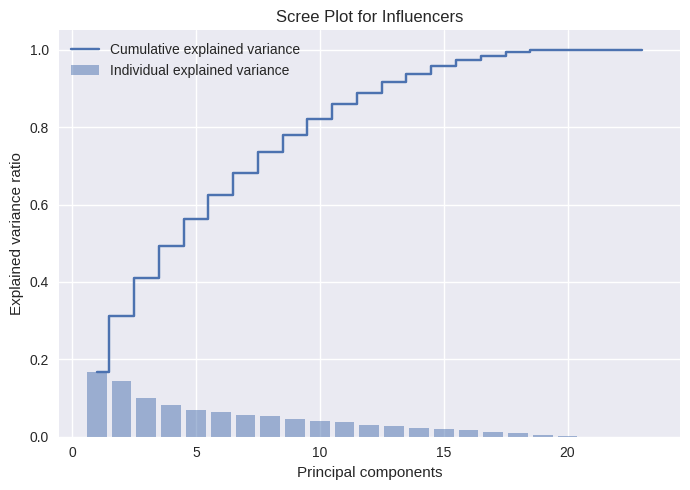

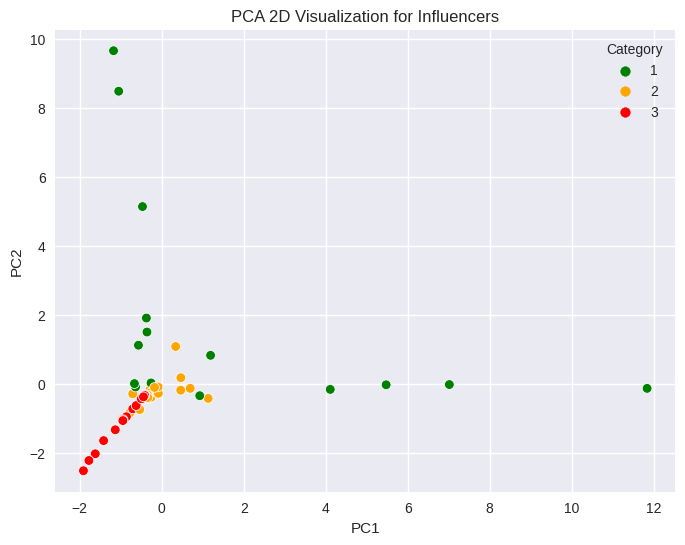

Influencers_pipeline:
Influencers_pipeline:
Cross-Validation MAE Scores for RF: [0.3542, 0.2755, 0.1709, 0.1809, 0.1673]
Average MAE for RF: 0.2298
Mean Squared Error: 0.1749
Root Mean Squared Error: 0.4182
Mean Absolute Error: 0.2457
Feature Importance by RF:    Features  Importance
16      549      0.5086
7       526      0.2000
11      864      0.0606
6       863      0.0461
14      408      0.0371
2       214      0.0252
19      229      0.0233
4        23      0.0223
5        91      0.0206
3       351      0.0143
13      565      0.0129
10      625      0.0108
15      334      0.0090
17      375      0.0063
18      471      0.0021
8       584      0.0006
20      201      0.0000
1       871      0.0000
0       725      0.0000
12      678      0.0000
9       712      0.0000
21      799      0.0000
22      342      0.0000
Influencers_pipeline:
Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.7273, 0.8182, 0.7273]
Average Accuracy: 0.803
Precision: [0.881, 0.9242, 0.8295, 0.870

In [296]:
# Aply pipeline for visual results
results_Influencers_pca = pca_pipeline(Influencers, 'Category', n_components=2, dataset_name='Influencers')

# Apply the pipeline for numerical results
Influencers_pipeline, df_pca_influence_Influencers, explained_variance_Influencers, n_components = apply_pipeline_pca(Influencers, "Influencers", n_components=2, n_top_features=20)

# Apply pipeline Regression
Influencers_pipeline_reg, importances_reg_Influencers= apply_pipeline_regressor(Influencers, "Influencers")
# Apply the pipeline Classification
Influencers_pipe_class, importances_class_Influencers = apply_classification_pipeline_classif(Influencers, "Influencers")

This final df lacks especificity on the category number 2, now the idea is to separate it to be able to have less overlap
# 15 Iteration to take other features to Influencers_OLS

In [324]:
def evaluate_feature_separation(base_df, feature_to_test, source_df):
    # Create test df 
    test_df = base_df.copy()
    test_df[feature_to_test] = source_df[feature_to_test].astype(str)
    
    # Do PCA 
    features = [col for col in test_df.columns if col not in ['Category', 'Sites']]
    X = test_df[features].astype(str)
    X_scaled = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    # Plot
    plt.figure(figsize=(10, 6))
    colors = ['green', 'orange', 'red']
    
    # Plot original points with o marker
    for cat in [1, 2, 3]:
        mask = test_df['Category'] == cat
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=colors[cat-1], marker='o', alpha=0.6, 
                   label=f'Category {cat} (original)')
    
    # Plot new points with * marker and darker color
    for cat in [1, 2, 3]:
        mask = test_df['Category'] == cat
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=colors[cat-1], marker='*', s=100, alpha=1,
                   label=f'Category {cat} with feature {feature_to_test}')
    
    plt.title(f'Testing feature {feature_to_test}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return test_df

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



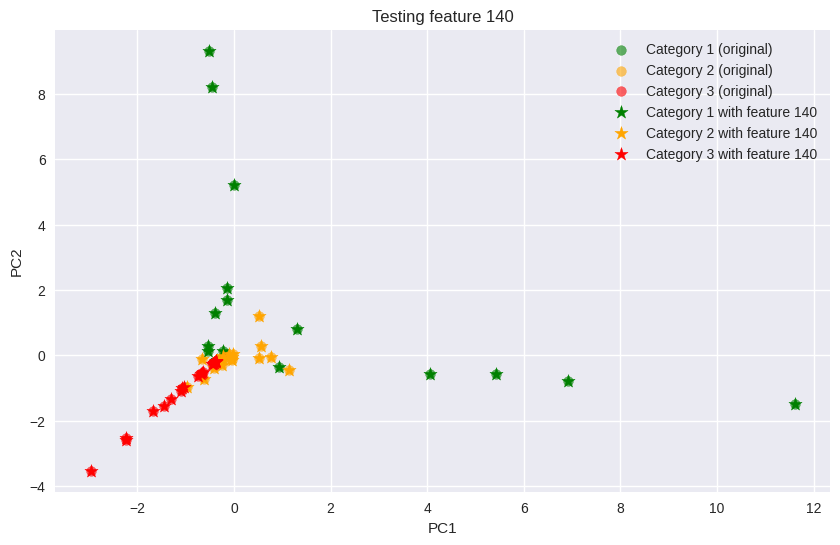

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



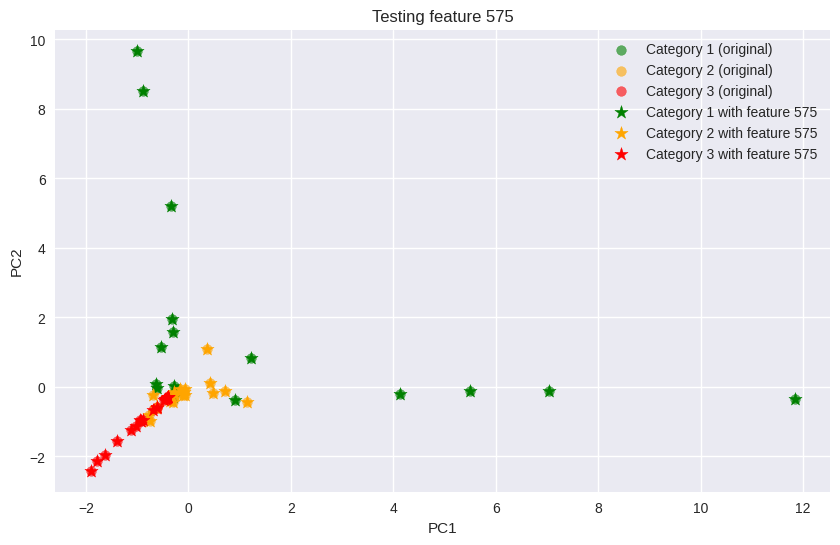

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



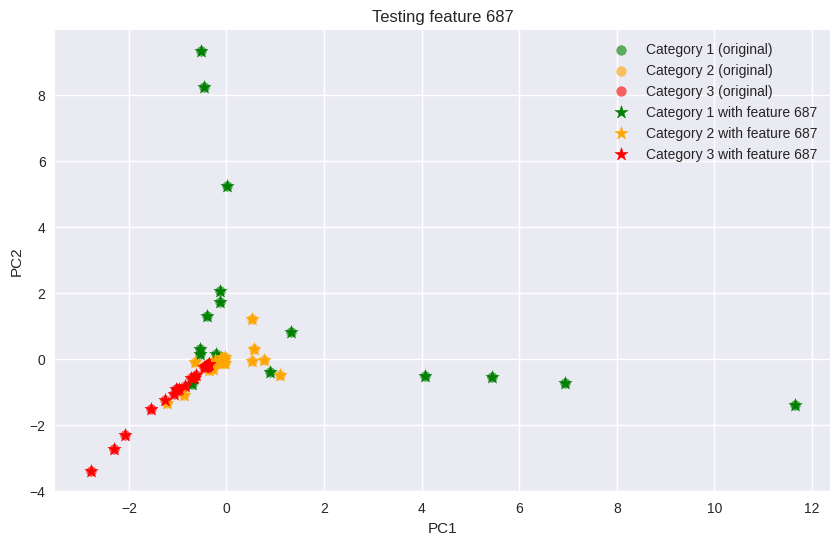

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



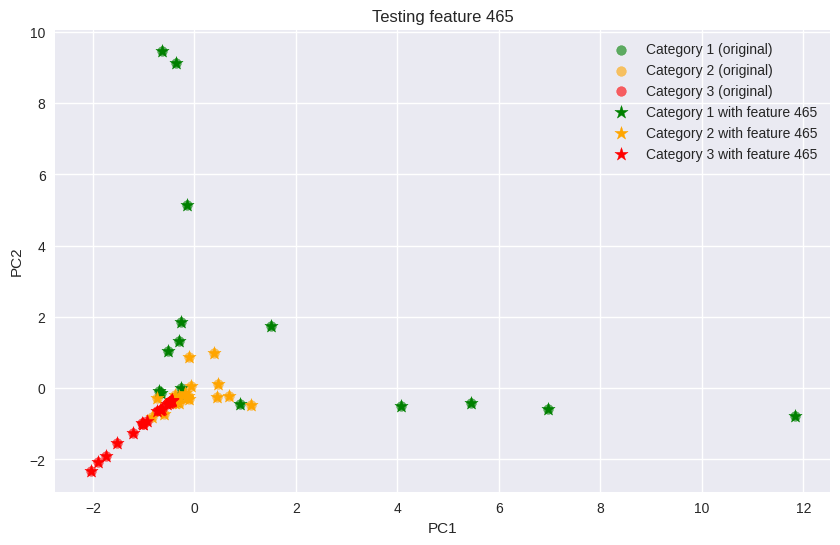

ValueError: Must pass 2-d input. shape=(4, 70, 25)

In [328]:
# Test multiple features in original_pca
results = []
for feature in original_pca.columns[1:5]:  # Test first few features
    result = evaluate_feature_separation(Influencers, feature, original_pca)
    results.append(result)

# Sort features by specificity to category 2 and centrality
results_df = pd.DataFrame(results)
results_df['combined_score'] = results_df['cat2_specificity'] * results_df['cat2_centrality']
final_original_pca = results_df.sort_values('combined_score', ascending=False)

In [316]:
# Create new dataframe adding selected columns from original_pca to Influencers
selected_original_pca = original_pca[final_original_pca['feature'].tolist()]
Influencers_original = pd.concat([Influencers, selected_original_pca], axis=1)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



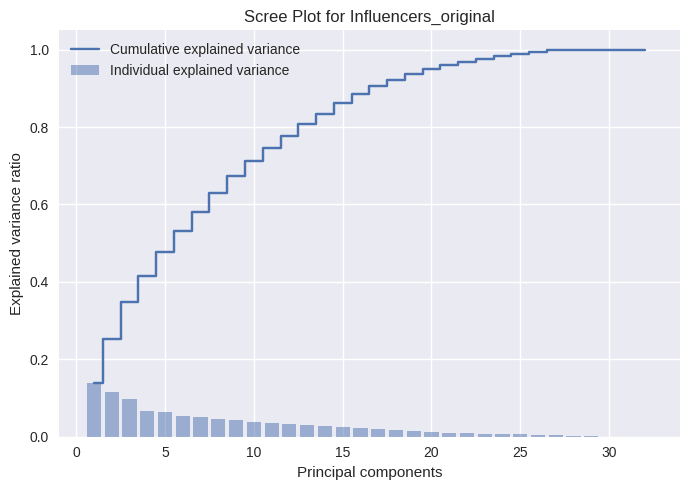

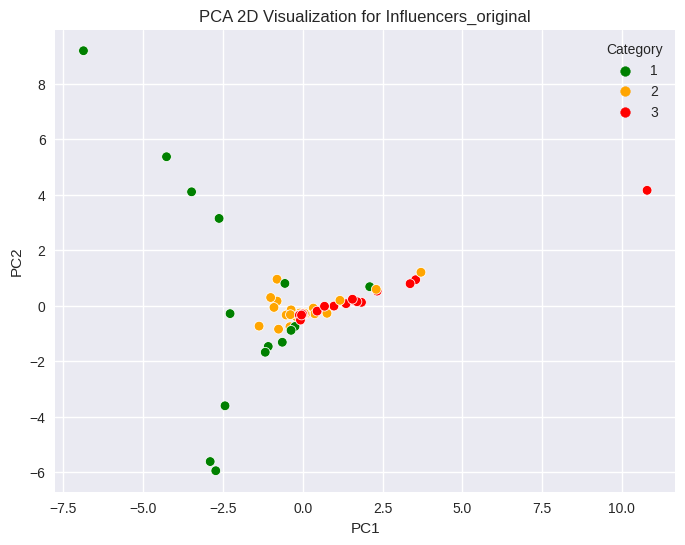

Influencers_original_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Influencers_original_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MI

Cross-Validation MAE Scores for RF: [0.4067, 0.2509, 0.2445, 0.1718, 0.17]
Average MAE for RF: 0.2488


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Mean Squared Error: 0.2211
Root Mean Squared Error: 0.4702
Mean Absolute Error: 0.3079
Feature Importance by RF:    Features  Importance
16      549      0.5123
7       526      0.1978
6       863      0.0437
28      687      0.0399
11      864      0.0274
5        91      0.0214
4        23      0.0191
2       214      0.0160
14      408      0.0146
19      229      0.0135
31      140      0.0135
15      334      0.0102
13      565      0.0097
3       351      0.0087
10      625      0.0078
24      250      0.0071
17      375      0.0063
30      300      0.0056
26      575      0.0055
25      564      0.0045
29      529      0.0042
23      609      0.0036
27      465      0.0031
8       584      0.0023
18      471      0.0021
Influencers_original_pipeline:


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

/home/beatriz/MI

Cross-Validation Metrics:
Accuracy: [0.8333, 0.9091, 0.7273, 0.8182, 0.8182]
Average Accuracy: 0.8212
Precision: [0.881, 0.9242, 0.8295, 0.8701, 0.8182]
Average Precision: 0.8646
Recall: [0.8333, 0.9091, 0.7273, 0.8182, 0.8182]
Average Recall: 0.8212
F1-Score: [0.8329, 0.9041, 0.7042, 0.8152, 0.8182]
Average F1-Score: 0.8149


/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.




Test Set Evaluation:
Confusion Matrix:
[[2 1 0]
 [0 7 0]
 [0 2 2]]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.70      1.00      0.82         7
           3       1.00      0.50      0.67         4

    accuracy                           0.79        14
   macro avg       0.90      0.72      0.76        14
weighted avg       0.85      0.79      0.77        14


Feature Importance:
   Features  Importance
16      549      0.1488
7       526      0.1186
5        91      0.0689
6       863      0.0596
13      565      0.0518
11      864      0.0470
28      687      0.0448
17      375      0.0435
14      408      0.0430
3       351      0.0426
26      575      0.0361
2       214      0.0353
19      229      0.0330
10      625      0.0327
15      334      0.0235
18      471      0.0211
4        23      0.0206
31      140      0.0184
25      564      0.0157
29      529      0.0145
23

In [ ]:
# Aply pipeline for visual results
results_Influencers_original = pca_pipeline(Influencers_original, 'Category', n_components=2, dataset_name='Influencers_original')

# Apply the pipeline for numerical results
Influencers_original_pipeline, df_pca_influence_Influencers_original, explained_variance_Influencers_original, n_components = apply_pipeline_pca(Influencers_original, "Influencers_original", n_components=2, n_top_features=20)

# Apply pipeline Regression
Influencers_original_pipeline_reg, importances_reg_Influencers_original= apply_pipeline_regressor(Influencers_original, "Influencers_original")
# Apply the pipeline Classification
Influencers_original_pipe_class, importances_class_Influencers_original = apply_classification_pipeline_classif(Influencers_original, "Influencers_original")

# 15. Separation Based on Exclusivity
Instead of just looking at feature importance metrics, focus on features' ability to separate categories. Use the 3D PCA space (PC1 vs PC2 vs PC3) to evaluate how well each feature separates the categories. Remove features that have high overlap across categories, even if they're statistically significant

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

def calculate_separation_metrics(df, feature, categories=[1, 2, 3]):
    """Calculate metrics for how well a feature separates categories"""
    separation_scores = {}
    
    # Get values for each category
    category_values = {
        cat: df[df['Category'] == cat][feature].values 
        for cat in categories
    }
    
    # Calculate overlap between categories
    overlaps = {}
    for cat1 in categories:
        for cat2 in categories:
            if cat1 < cat2:
                # Calculate histogram overlap
                hist1, bins = np.histogram(category_values[cat1], bins=20, density=True)
                hist2, _ = np.histogram(category_values[cat2], bins=bins, density=True)
                overlap = np.minimum(hist1, hist2).sum() * (bins[1] - bins[0])
                overlaps[f"{cat1}_vs_{cat2}"] = overlap
    
    # Calculate mean separation between category centroids
    centroids = {cat: np.mean(vals) for cat, vals in category_values.items()}
    centroid_dists = []
    for cat1 in categories:
        for cat2 in categories:
            if cat1 < cat2:
                dist = abs(centroids[cat1] - centroids[cat2])
                centroid_dists.append(dist)
    
    # Calculate within-category spread
    spreads = {cat: np.std(vals) for cat, vals in category_values.items()}
    
    # Combine metrics
    separation_scores['overlap_mean'] = np.mean(list(overlaps.values()))
    separation_scores['centroid_separation'] = np.mean(centroid_dists)
    separation_scores['within_spread'] = np.mean(list(spreads.values()))
    
    # Overall separation score (higher is better)
    separation_scores['overall'] = (separation_scores['centroid_separation'] / 
                                  (separation_scores['overlap_mean'] * 
                                   separation_scores['within_spread']))
    
    return separation_scores

def evaluate_pca_separation(df, features):
    """Evaluate separation in PCA space"""
    # Prepare data
    X = df[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calculate separation for each PC
    pc_separations = []
    for i in range(3):
        pc_df = pd.DataFrame({'PC': X_pca[:, i], 'Category': df['Category']})
        metrics = calculate_separation_metrics(pc_df, 'PC')
        pc_separations.append(metrics['overall'])
    
    return np.mean(pc_separations)

def select_best_separating_features(df, initial_features, n_features=15):
    """Select features that provide best category separation"""
    feature_scores = {}
    
    # Calculate individual feature separation scores
    for feature in initial_features:
        metrics = calculate_separation_metrics(df, feature)
        feature_scores[feature] = metrics['overall']
    
    # Calculate PCA separation contribution
    pca_contributions = {}
    for feature in initial_features:
        remaining_features = [f for f in initial_features if f != feature]
        pca_sep = evaluate_pca_separation(df, remaining_features)
        pca_contributions[feature] = pca_sep
    
    # Combine scores (higher PCA separation without feature = less important feature)
    combined_scores = {
        feature: (feature_scores[feature] * (1 / pca_contributions[feature]))
        for feature in initial_features
    }
    
    # Select top features
    selected_features = sorted(combined_scores.items(), 
                             key=lambda x: x[1], 
                             reverse=True)[:n_features]
    
    return selected_features

# Apply to Influencers_uniques_selected
features = [col for col in Influencers_uniques_selected.columns 
           if col not in ['Category', 'Sites']]
selected_features = select_best_separating_features(
    Influencers_uniques_selected, 
    features
)

# Print results
print("\nTop Features by Separation Power:")
for feature, score in selected_features:
    print(f"{feature}: {score:.4f}")

# Visualize separation in PCA space
def plot_feature_separation(df, selected_features):
    X = df[selected_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)
    
    fig = go.Figure(data=[
        go.Scatter3d(
            x=X_pca[:, 0],
            y=X_pca[:, 1],
            z=X_pca[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=df['Category'],
                colorscale='Viridis',
                opacity=0.8
            ),
            text=df['Category']
        )
    ])
    
    fig.update_layout(
        title='Category Separation in PCA Space',
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        )
    )
    
    fig.show()

# Visualize results
selected_feature_names = [f[0] for f in selected_features]
plot_feature_separation(Influencers_uniques_selected, selected_feature_names)


Top Features by Separation Power:
549: 1.3986
526: 0.8716
23: 0.6479
725: 0.6360
864: 0.6082
584: 0.5772
565: 0.5752
214: 0.5660
625: 0.5641
863: 0.5630
229: 0.5051
334: 0.4984
375: 0.4828
201: 0.4724
408: 0.4638


# 15. Otras Visualisations
## 15.1.  t-SNE for Visualization
t-SNE is a non-linear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in 2D or 3D. It often preserves local structure better than PCA

In [150]:
def tsne_visualization(scaled_data):
    """
    Visualizes data using t-SNE.
    
    Parameters:
    - df: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels to color-code.
    - perplexity: Perplexity for t-SNE (default=30).
    - n_components: Number of components for t-SNE (default=2).
    - random_state: Random seed for reproducibility.
    """
    # Apply t-SNE
    tsne = TSNE(n_components=3, perplexity=10, random_state=42)
    tsne_results = tsne.fit_transform(scaled_data)

    # Plot t-SNE results
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis', s=20, alpha=0.7)
    plt.colorbar(label='True Labels')
    plt.title("t-SNE Visualization")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

In [151]:
# Visualising the implementation
scaled_data = results_Influencers_OLS_cluster['scaled_data']
tsne_visualization(scaled_data)

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



NameError: name 'true_labels' is not defined

<Figure size 800x600 with 0 Axes>

## 15.2. UMAP Visualisation

In [187]:
def umap_visualization(df, scaled_data, label_column='Category', colors=['green', 'orange', 'red'], 
                      n_neighbors=10, min_dist=0.1):
    """
    Visualizes data using UMAP with custom colors.

    Parameters:
    - scaled_data: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels for color-coding.
    - categories: List of category values to match labels.
    - colors: List of colors corresponding to each category.
    - n_neighbors: Number of neighbors for UMAP (default=15).
    - min_dist: Minimum distance between points (default=0.1).
    
    Returns:
    - None (Displays a plot)
    """
    # Get unique categories in order
    categories = sorted(df[label_column].unique())

    # Get category labels from the DataFrame
    labels = df[label_column].values

    # Apply UMAP
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, random_state=42)
    umap_results = umap_reducer.fit_transform(scaled_data)

    # Create a mapping from labels to colors
    label_color_map = {category: color for category, color in zip(categories, colors)}
    mapped_colors = [label_color_map[label] for label in labels]
   
    plt.figure(figsize=(8, 6))
    plt.scatter(
        umap_results[:, 0], umap_results[:, 1],
        c=mapped_colors, alpha=0.8, s=50
    )
    plt.title('UMAP Visualization with Custom Colors')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    # Plotting

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10, label=f'Category {category}')
               for category, color in zip(categories, colors)]
    plt.legend(handles=handles, title='Category', loc='best')

    plt.show()

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



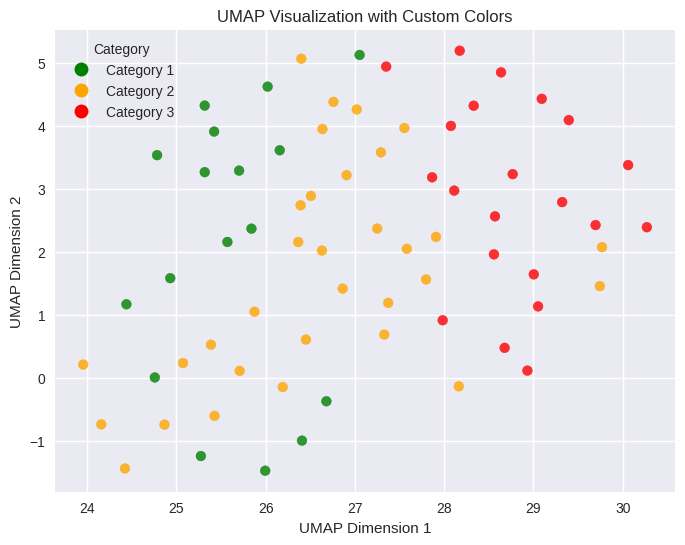

In [189]:
scaled_data = results_Influencers_OLS_cluster['scaled_data']
# Extract category labels
category_labels = Influencers_OLS['Category'].values

# Calling the function
umap_visualization(Influencers_OLS, scaled_data, label_column='Category',  colors=['green', 'orange', 'red'],  n_neighbors=20, min_dist=0.7)

### Visualisation of Influencers_OLS UMAP
presents some patterns that has distintive regions, but still some mixture.
Category 3 (red) tends to cluster on the right side
Category 1 (green) and 2 (orange) have some overlap but show patterns

/home/beatriz/MIC/2_Micro/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



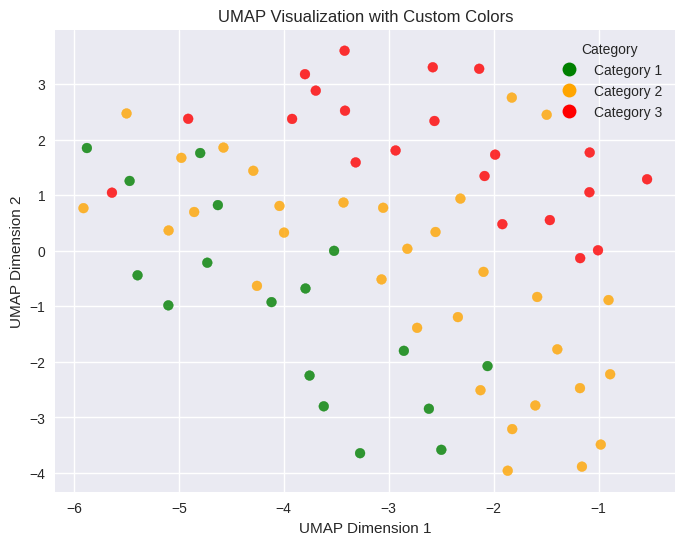

In [192]:
scaled_data = results_influencers_uniques_selected_cluster['scaled_data']
# Extract category labels
category_labels = Influencers_uniques_selected['Category'].values

# Calling the function
umap_visualization(Influencers_uniques_selected, scaled_data, label_column='Category', colors=['green', 'orange', 'red'], n_neighbors=20, min_dist=0.7)

**Influencers_uniques shows**: Different spatial arrangement, better vertical separation of Category 3. 
More spread out distribution overall
**Combined/Merged** shows: More mixing between categories, some local clustering but less global structure, higher dimension 2 values (7-11 range)

# 16. Saving the dataframes 

In [105]:
# Save multiple dataframes to different sheets in the same Excel file
with pd.ExcelWriter(f'data/df_after_pca.xlsx') as writer:
    original_pca.to_excel(writer, sheet_name='original_pca', index=True)
    Merged_selected.to_excel(writer, sheet_name='merged', index=True)
    Influencers_uniques_selected.to_excel(writer, sheet_name='Influencers_uniques', index=True)

# Save dataframes to different sheets in the same Excel file
with pd.ExcelWriter(f'data/old_new_data.xlsx') as writer:
    old_new_1.to_excel(writer, sheet_name='old_new1', index=True)
    old_new_2.to_excel(writer, sheet_name='old_new2', index=True)

## END NOTEBOOK

## OLD WORK NO TO TAKE INTO ACCOUNT

In [107]:
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7])#, sort=False)#, dtype={i: float for i in range(2, 882)})
# making sure that the levels all are on str mode
Jointax.columns = Jointax.columns.set_levels([level.astype(str) for level in Jointax.columns.levels])
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
#Correcting the Tuple-like Index
Jointax.index = Jointax.index.map(lambda x: x[0] if isinstance(x, tuple) else x)

In [ ]:
# Original selected GIDs
selected_gen_fin = {154, 201, 214, 229, 334, 351, 354, 408, 497, 512, 565, 581, 583, 584, 606, 621, 625}
selected_gen_fin = set(map(str, selected_gen_fin))

mae_results = {}  # Initialize an empty dictionary to store MAE results

for gid_to_remove in selected_gen_fin:
    print(f"Removing GID: {gid_to_remove}")  # Debugging line
    
    # Temporarily remove one GID
    modified_gids = [x for x in selected_gen_fin if x != gid_to_remove]
    
    # Initialize an empty list to store the columns to keep
    columns_to_keep_fin = []
    
    # Filtering original DataFrame to only include the modified GIDs
    for col in Jointax.columns[2:]:
        gid = str(col[-1])
        if gid in modified_gids:
            columns_to_keep_fin.append(col)
            
    selected_dfs_fin = Jointax.loc[:, columns_to_keep_fin]
    
    # Add back the 'Sites' and 'Category' columns
    selected_dfs_fin['Sites'] = Jointax['Sites']
    selected_dfs_fin['Category'] = Jointax['Category']
      
    # Run pipeline here with the modified_df and get the MAE
    mae = apply_pipeline(selected_dfs_fin, "Modified_Gids")
    
    # Store the MAE result
    mae_results[f'Remove {gid_to_remove}'] = mae

print(mae_results)


| GID  | Join_tax                                              | Importance |   | GID  | Join_tax                                              | Influence |
|------|-------------------------------------------------------|------------|---|------|-------------------------------------------------------|-----------|
| 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 0.1578     |   | 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 2.5536    |
| 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 0.1568     |   | 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 2.5225    |
| 408  | Legionellales_Legionellaceae_Legionella               | 0.1230     |   | 565  | Bacteroidales_Porphyromonadaceae_Porphyromonas        | 2.3413    |
| 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 0.1044     |   | 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 2.2417    |
| 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 0.0930     |   | 408  | Legionellales_Legionellaceae_Legionella               | 2.2394    |
| 214  | Clostridiales_Clostridiaceae_Clostridium              | 0.0925     |   | 621  | Burkholderiales_Comamonadaceae_Roseateles             | 2.2278    |
| 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 0.0675     |   | 229  | Actinomycetales_Corynebacteriaceae_Corynebacterium    | 2.2168    |
| 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 0.0462     |   | 354  | Oceanospirillales_Halomonadaceae_Halomonas            | 2.1489    |
| 584  | Vibrionales_Pseudoalteromonadaceae_Pseudoalteromonas  | 0.0443     |   | 334  | Thermoanaerobacterales_Thermoanaerobacteraceae_Gelria | 2.0918    |
| 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 0.0387     |   | 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 1.9865    |
| 583  | Actinomycetales_Micrococcaceae_Pseudarthrobacter      | 0.0274     |   | 625  | Rhodospirillales_Acetobacteraceae_Roseococcus         | 1.7623    |
| 621  | Burkholderiales_Comamonadaceae_Roseateles             | 0.0230     |   | 214  | Clostridiales_Clostridiaceae_Clostridium              | 1.7298    |
| 581  | Erysipelotrichales_Erysipelotrichaceae_Psb-m-3        | 0.0196     |   | 351  | Pasteurellales_Pasteurellaceae_Haemophilus            | 1.7265    |
| 512  | Clostridiales_Clostridiaceae_Oxobacter                | 0.0032     |   | 512  | Clostridiales_Clostridiaceae_Oxobacter                | 1.5879    |
| 497  | Actinomycetales_Cellulomonadaceae_Oerskovia           | 0.0025     |   | 606  | Xanthomonadale_Paracoccaceae_Rhodobacter              | 1.3106    |


In [ ]:
# Final selected genera taxonomic levels and abundance 
new_selected_gen = 625, 214,408,229,351,354,565,606,334,584,583,621,581,497,512
new_selected_gen = set(map(str, new_selected_gen))
# Initialize an empty list to store the columns to keep
columns_to_keep_new = []

# Skip the first two columns ('Header_7', 'GID') and iterate through the rest of the columns in 'Jointax'
for col in Jointax.columns[2:]:
    # Because GID or unique identifier is the last element in the multi-level header tuple
    gid = str(col[-1])  # Convert to string just to be sure
    if gid in new_selected_gen:
        columns_to_keep_new.append(col)

# Filter 'Jointax' to only include the columns in 'columns_to_keep'
selected_new = Jointax.loc[:, columns_to_keep_new]
# Add back the 'Sites' and 'Category' columns
selected_new['Sites'] = Jointax['Sites']
selected_new['Category'] = Jointax['Category']
#organising the columns
cols = [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')] + [col for col in selected_new.columns if col not in [('Sites', '', '', '', '', '', ''), ('Category', '', '', '', '', '', '')]]

selected_new  = selected_new .loc[:, cols]
selected_new.head()

Knowing the lenght of the notebook

In [ ]:
import json

def count_cells(notebook_path):
    with open(notebook_path, 'r') as f:
        notebook = json.load(f)
        
    code_count = 0
    markdown_count = 0
    for cell in notebook['cells']:
        if cell['cell_type'] == 'code':
            code_count += 1
        elif cell['cell_type'] == 'markdown':
            markdown_count += 1
    
    return code_count, markdown_count

# Usage of the code
notebook_path = '/home/beatriz/MIC/2_Micro/4_Sequencies_find.ipynb' 
code_count, markdown_count = count_cells(notebook_path)
print(f'The number of code cells is: {code_count}')
print(f'The number of markdown cells is: {markdown_count}')